## Visualization (Homogeneous fuels)
Visualization code to plot homogeneous fuels for different FSMs:
- BehavePlus V6 (US): F101, F102, F122, F165 (Hourly isochrones are provided for F101 and F165)
- FBP (Canada): 'C1', 'C2', 'C3','C4','C5','C6','D1','D2','M1','M2','M3','M4','O1a','O1b','S1','S2','S3'
- KITRAL (Chile): Fuels 1 - 31

*See Supplementary Materials for detailed visualization and analysis.

In [1]:
import os, glob, warnings
import compress_pickle
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.plot_utils import *

from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")

In [2]:
BASE_PATH = '/Users/minho/Documents/GitHub/Cell2FireML/plot/results/'

## 1. BehavePlus (US)

#### (i) Plot fire spread by hourly isochrones for F101 and F165 
Use function compare_single_grids_v2 to plot hourly isochrones

f101_100_ws10_CS100_5HR


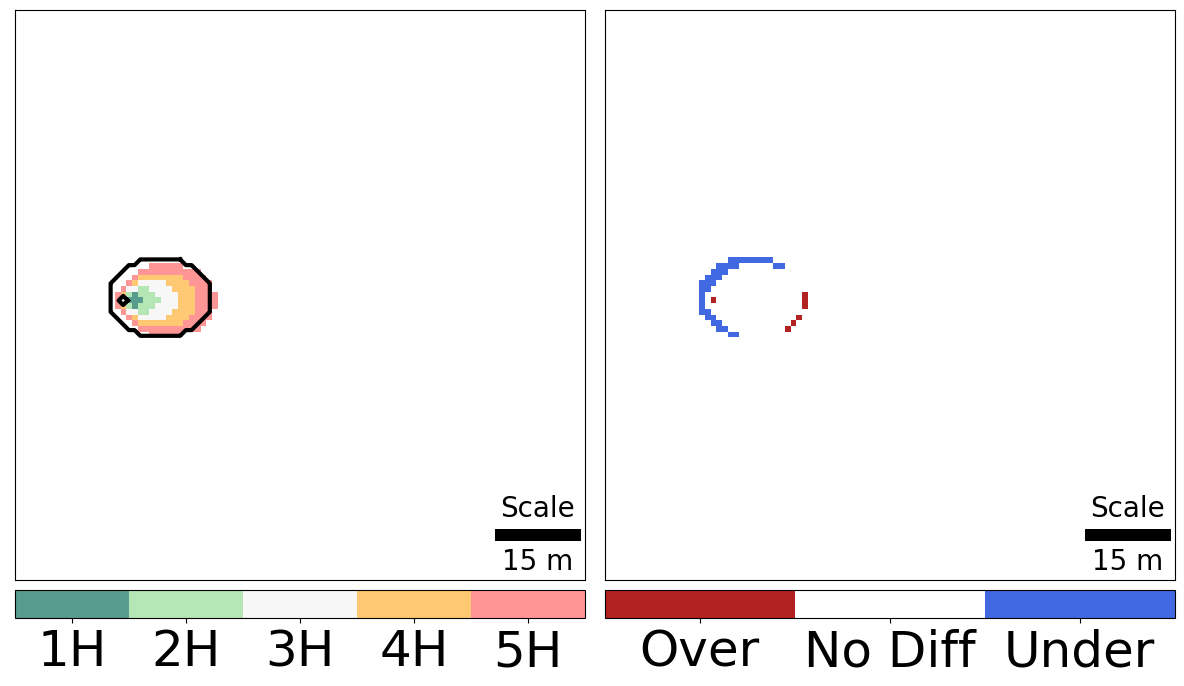

f101_100_ws20_CS100_5HR


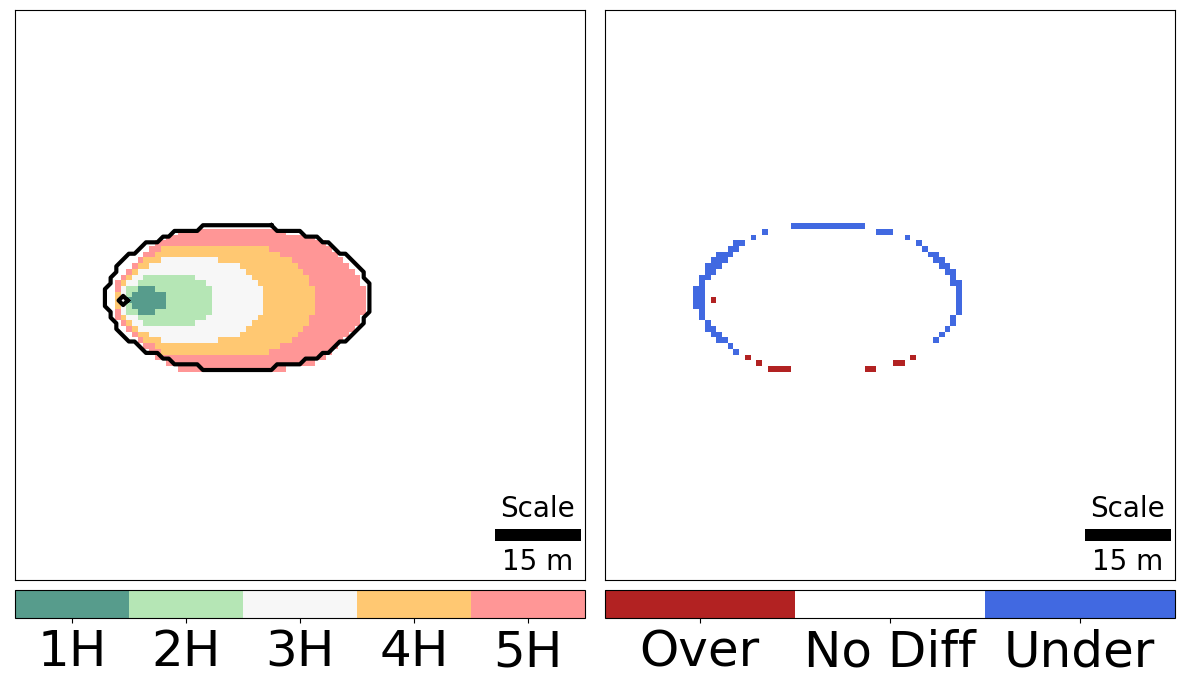

f101_100_ws30_CS500_5HR


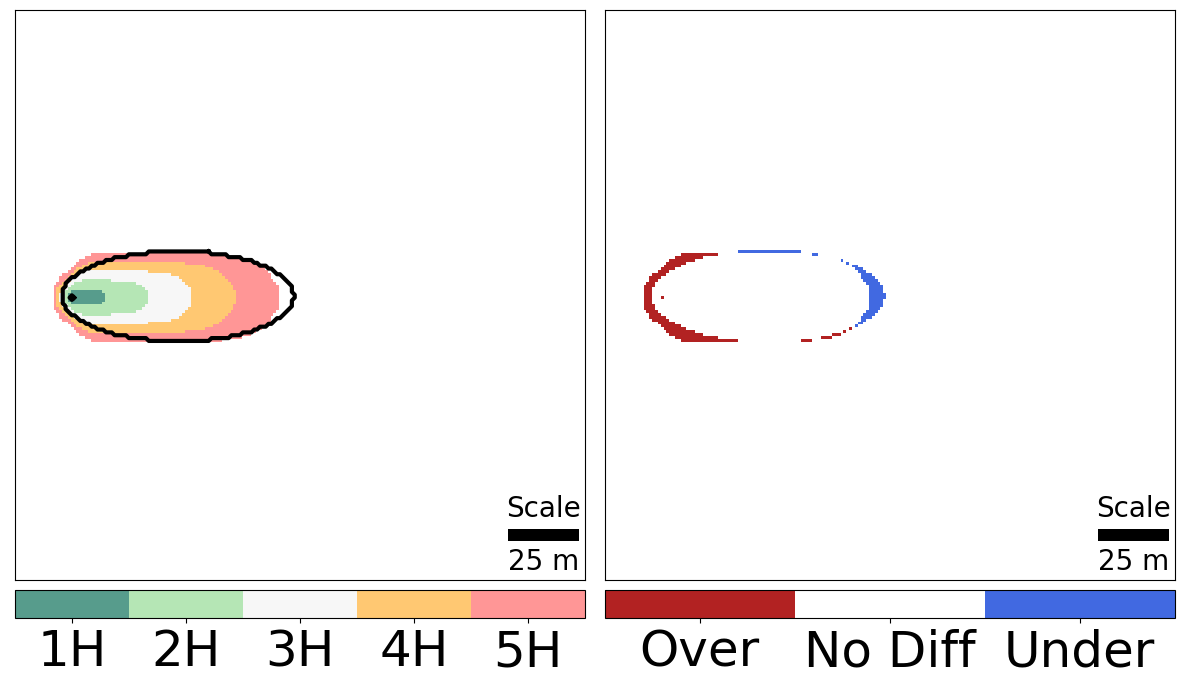

f101_100_ws40_CS500_5HR


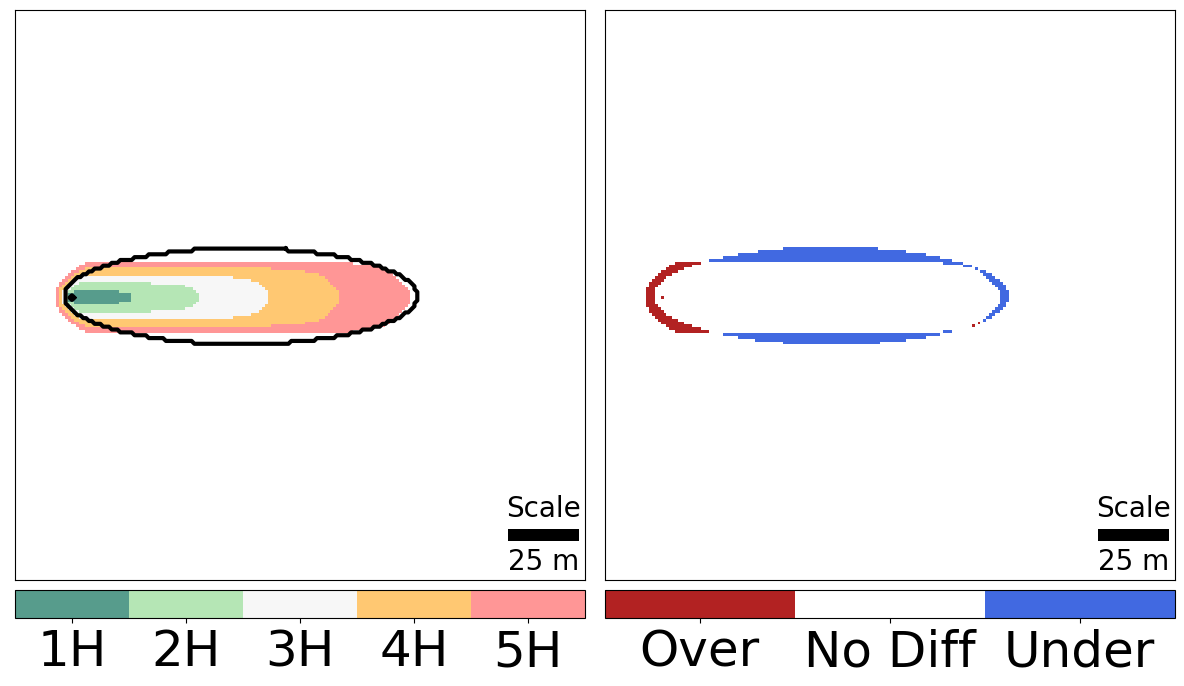

f101_100_ws50_CS500_5HR


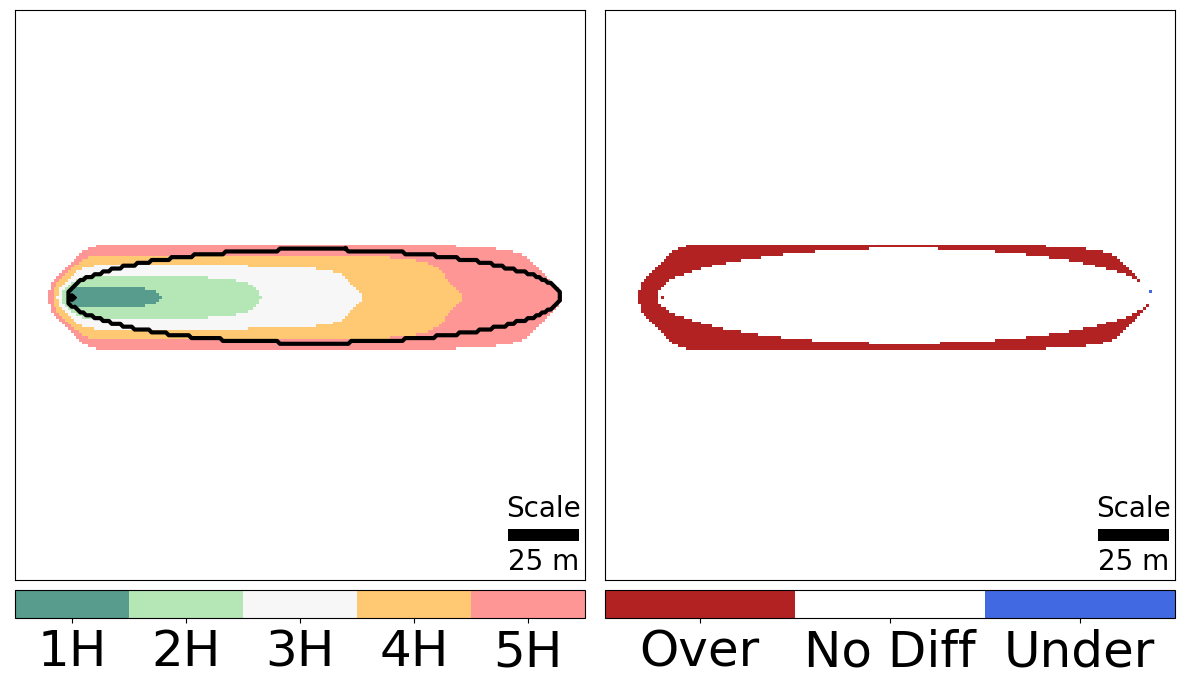

In [3]:
# Input parameters
fuel_type = 101

# Set base path
base_path = os.path.join(BASE_PATH, 'USA/')
isochrone_path = os.path.join(base_path, "isochrones/f"+str(fuel_type)+"/f"+str(fuel_type)+"_isochrones_shapefile.lzma")

r2_scores_101 = {'ws':[], 'r2':[]}

# Plot fire spread progression for different wind speeds
for wind_speed in [10, 20, 30, 40, 50]:
    
    r2_scores_101['ws'].append(wind_speed)

    # Set Instance
    size = 100 if (fuel_type == 101 and wind_speed < 30) or fuel_type == 165 else 500
    instance = 'f'+str(fuel_type)+'_100_ws'+str(wind_speed)+'_CS' + str(size) +'_5HR'
    print(instance) 

    # Input paths
    farsite_list = sorted(glob.glob(os.path.join(base_path, 'homogeneous', 'f' + str(fuel_type), 'farsite_' + instance + "*.csv")))
    farsite_img = load_farsite_list(farsite_list)

    # Load isochrone data per hour (Total = 5 hours)
    '''
    If an error occurs while loading the lzma file, check pandas and geopandas versions.
    Current working package versions are:
    - pandas: 1.4.2
    - geopandas: 0.12.2
    '''
    file = compress_pickle.load(isochrone_path) 
    instance_df = file[instance.split('_5HR')[0]]
    
    c2f_list = []
    for i in range(len(np.unique(instance_df['time']))):
        polygon = instance_df[instance_df['time'] == str(i+1) + 'HR'].iloc[0]
        cell2fire_img = rasterize_cell2fire(polygon, size)
        c2f_list.append(cell2fire_img)
        
    r2_scores_101['r2'].append(r2_score(farsite_img[0], cell2fire_img))

    # Plot
    compare_single_grids_v2(base_path=base_path, 
                        grid1=c2f_list, 
                        grid2=farsite_img, 
                        size=size, 
                        instance=instance,
                        farsite_width=3,
                        save=False)

    

In [91]:
pd.DataFrame(r2_scores_101)

,ws,r2
0,10,0.941563
1,20,0.915981
2,30,0.955389
3,40,0.928992
4,50,0.835089


f165_100_ws10_CS100_5HR


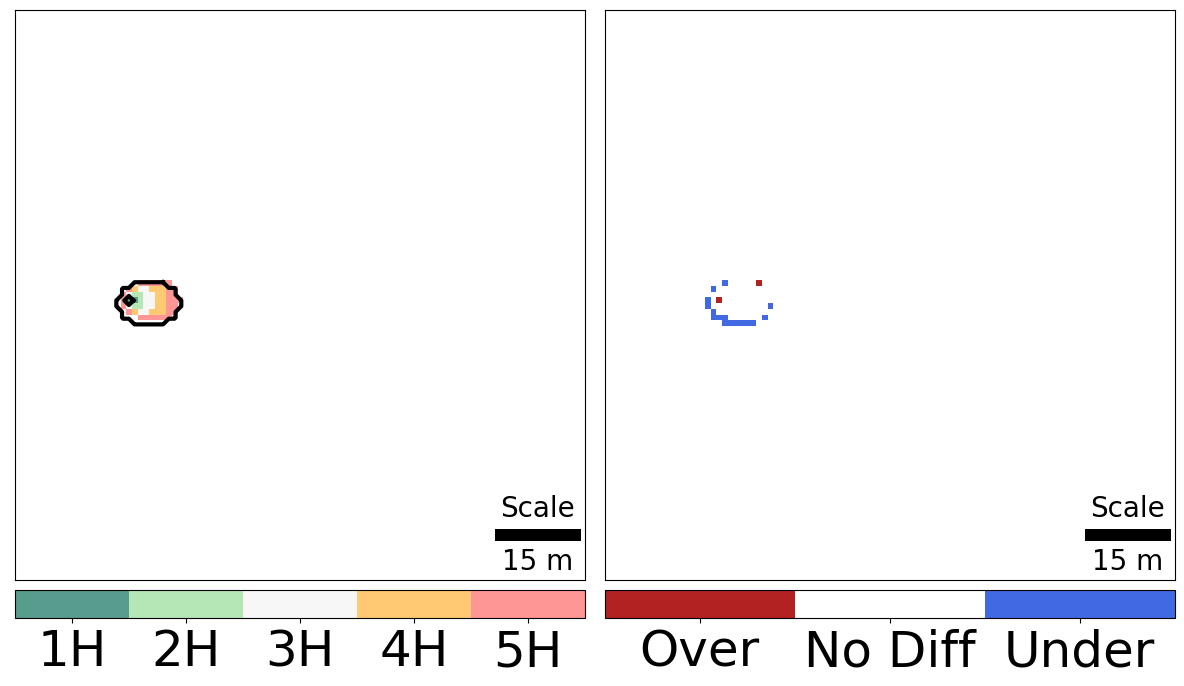

f165_100_ws20_CS100_5HR


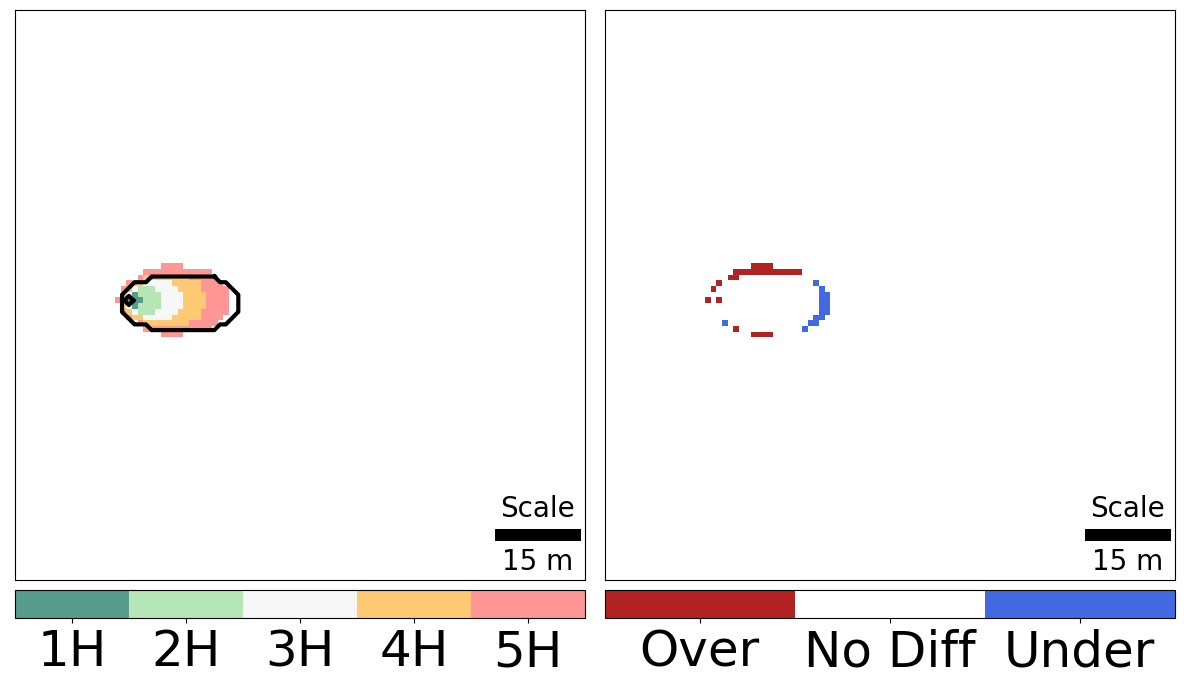

f165_100_ws30_CS100_5HR


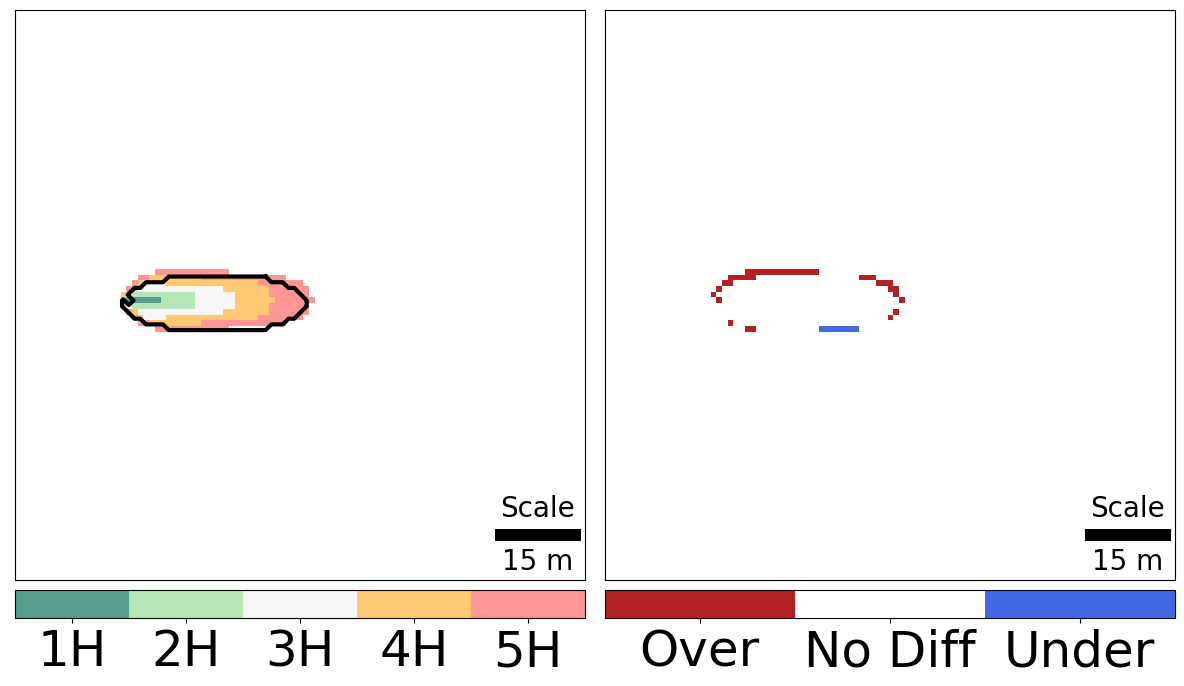

f165_100_ws40_CS100_5HR


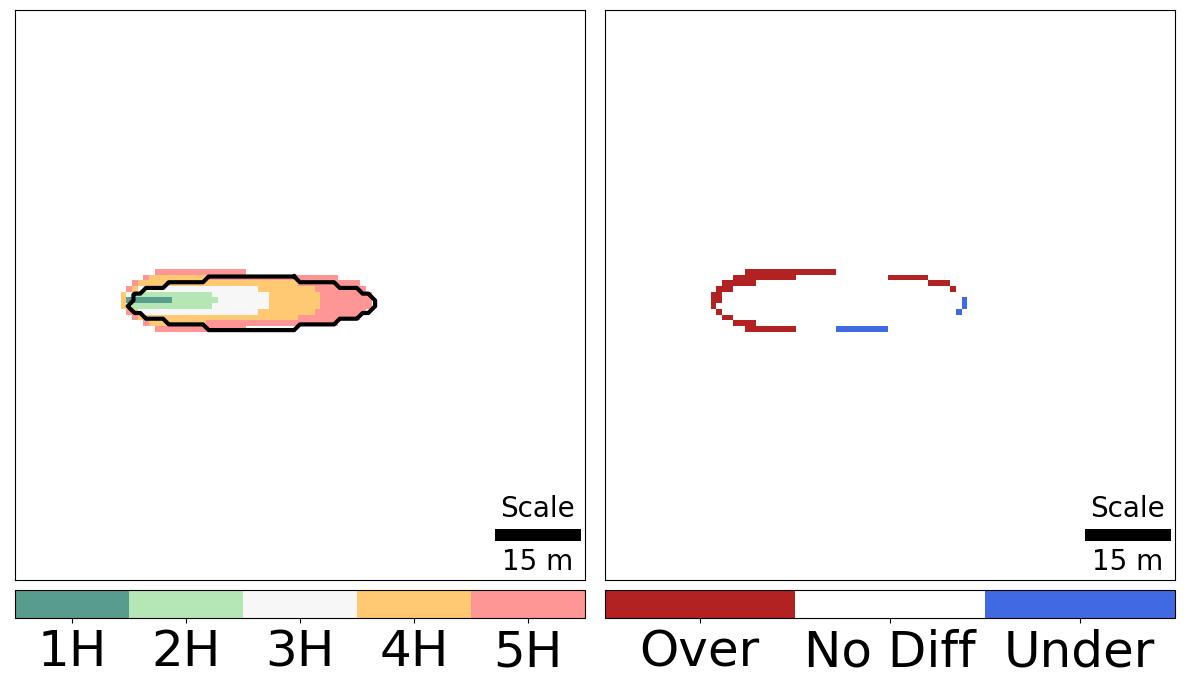

f165_100_ws50_CS100_5HR


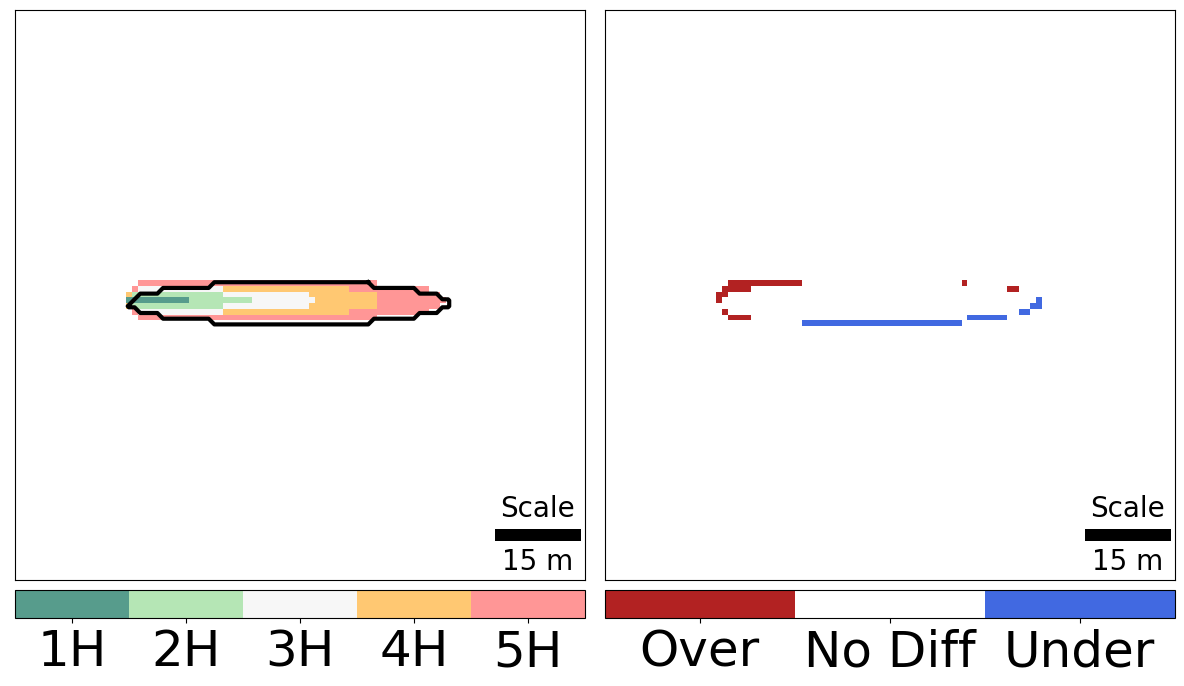

In [4]:
# Input parameters
fuel_type = 165

# Set base path
base_path = os.path.join(BASE_PATH, 'USA/')
isochrone_path = os.path.join(base_path, "isochrones/f"+str(fuel_type)+"/f"+str(fuel_type)+"_isochrones_shapefile.lzma")

r2_scores_165 = {'ws':[], 'r2':[]}

# Plot fire spread progression for different wind speeds
for wind_speed in [10, 20, 30, 40, 50]:
    
    r2_scores_165['ws'].append(wind_speed)

    # Set Instance
    size = 100 if (fuel_type == 101 and wind_speed < 30) or fuel_type == 165 else 500
    instance = 'f'+str(fuel_type)+'_100_ws'+str(wind_speed)+'_CS' + str(size) +'_5HR'
    print(instance) 

    # Input paths
    farsite_list = sorted(glob.glob(os.path.join(base_path, 'homogeneous', 'f' + str(fuel_type), 'farsite_' + instance + "*.csv")))
    farsite_img = load_farsite_list(farsite_list)

    # Load isochrone data per hour (Total = 5 hours)
    '''
    If an error occurs while loading the lzma file, check pandas and geopandas versions.
    Current working package versions are:
    - pandas: 1.4.2
    - geopandas: 0.12.2
    '''
    file = compress_pickle.load(isochrone_path) 
    instance_df = file[instance.split('_5HR')[0]]
    
    c2f_list = []
    for i in range(len(np.unique(instance_df['time']))):
        polygon = instance_df[instance_df['time'] == str(i+1) + 'HR'].iloc[0]
        cell2fire_img = rasterize_cell2fire(polygon, size)
        c2f_list.append(cell2fire_img)
        
    r2_scores_165['r2'].append(r2_score(farsite_img[0], cell2fire_img))

    # Plot
    compare_single_grids_v2(base_path=base_path, 
                        grid1=c2f_list, 
                        grid2=farsite_img, 
                        size=size, 
                        instance=instance,
                        farsite_width=3,
                        save=False)

In [102]:
pd.DataFrame(r2_scores_165)

,ws,r2
0,10,0.960749
1,20,0.927680
2,30,0.909323
3,40,0.827276
4,50,0.839334


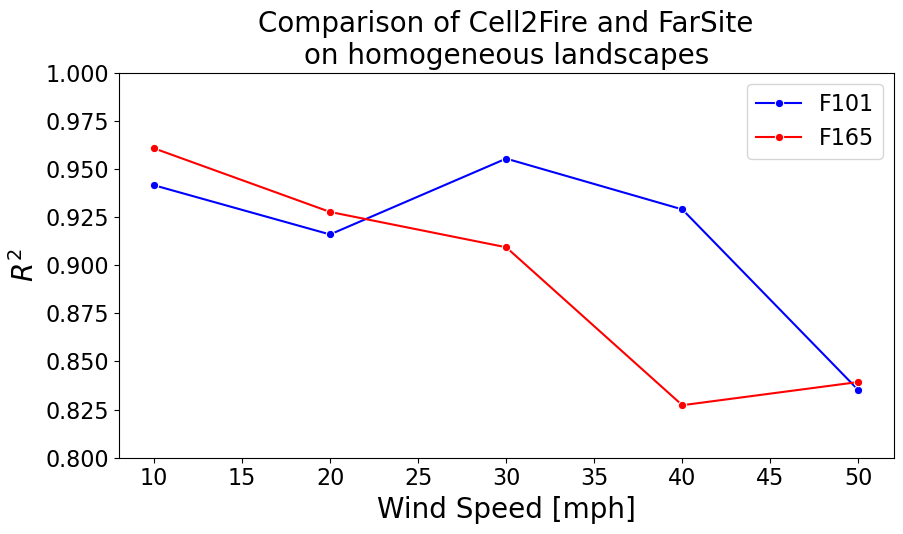

In [112]:
fig, ax = plt.subplots(1, figsize=(10,5))

sns.lineplot(ax=ax, data=pd.DataFrame(r2_scores_101), x='ws', y='r2', marker='o', color='b', label='F101')
sns.lineplot(ax=ax, data=pd.DataFrame(r2_scores_165), x='ws', y='r2', marker='o', color='r', label='F165')

ax.set_ylabel("$R^2$", size=20)
ax.set_xlabel("Wind Speed [mph]", size=20)

ax.tick_params(axis='both', labelsize=16)
plt.legend(loc='best', fontsize=16)

plt.ylim([0.8,1])

plt.title("Comparison of Cell2Fire and FarSite\non homogeneous landscapes", size=20)
plt.show()

#### (ii) Plot fire spread at final hour (time=5H) for F102 and F122
Use function compare_single_grids to plot final burn scars

f102_100_ws10_CS500_5HR


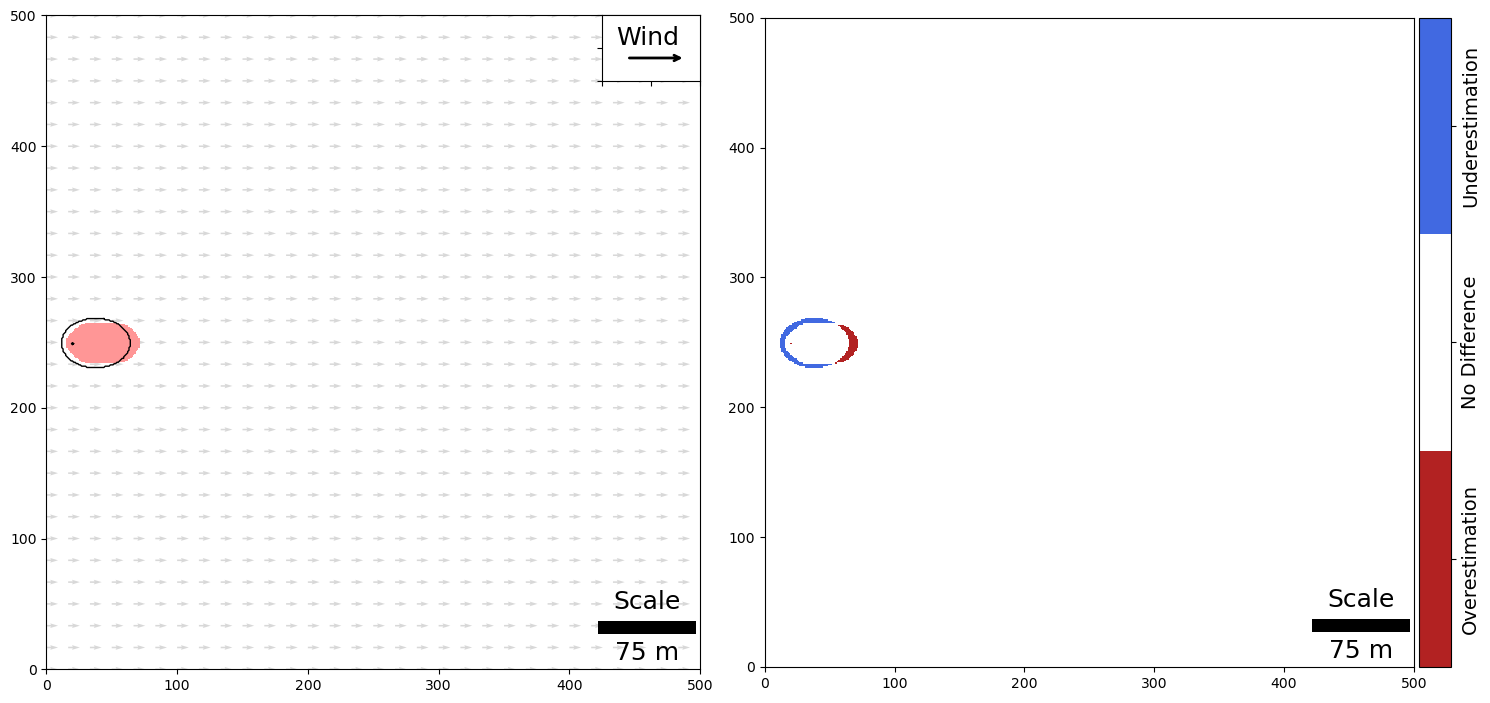

f102_100_ws20_CS500_5HR


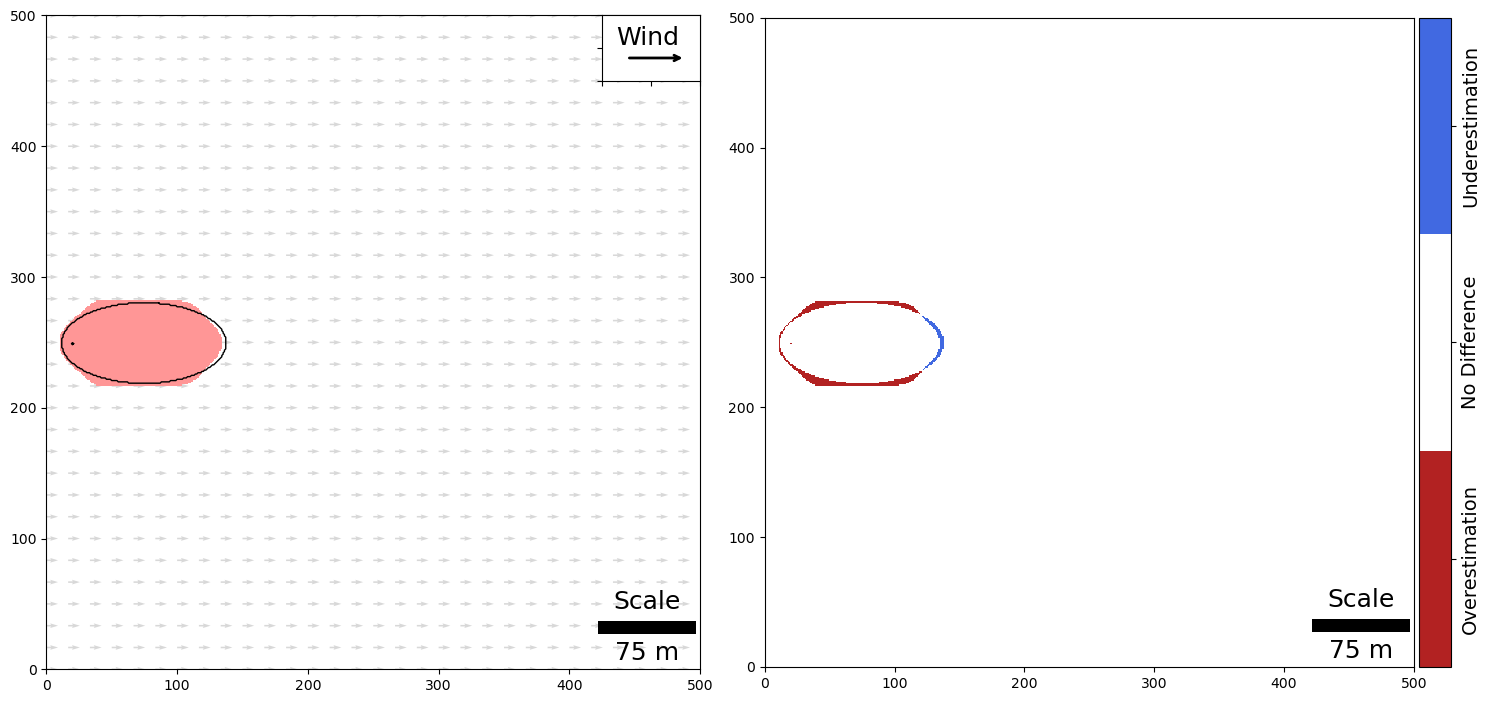

f102_100_ws30_CS500_5HR


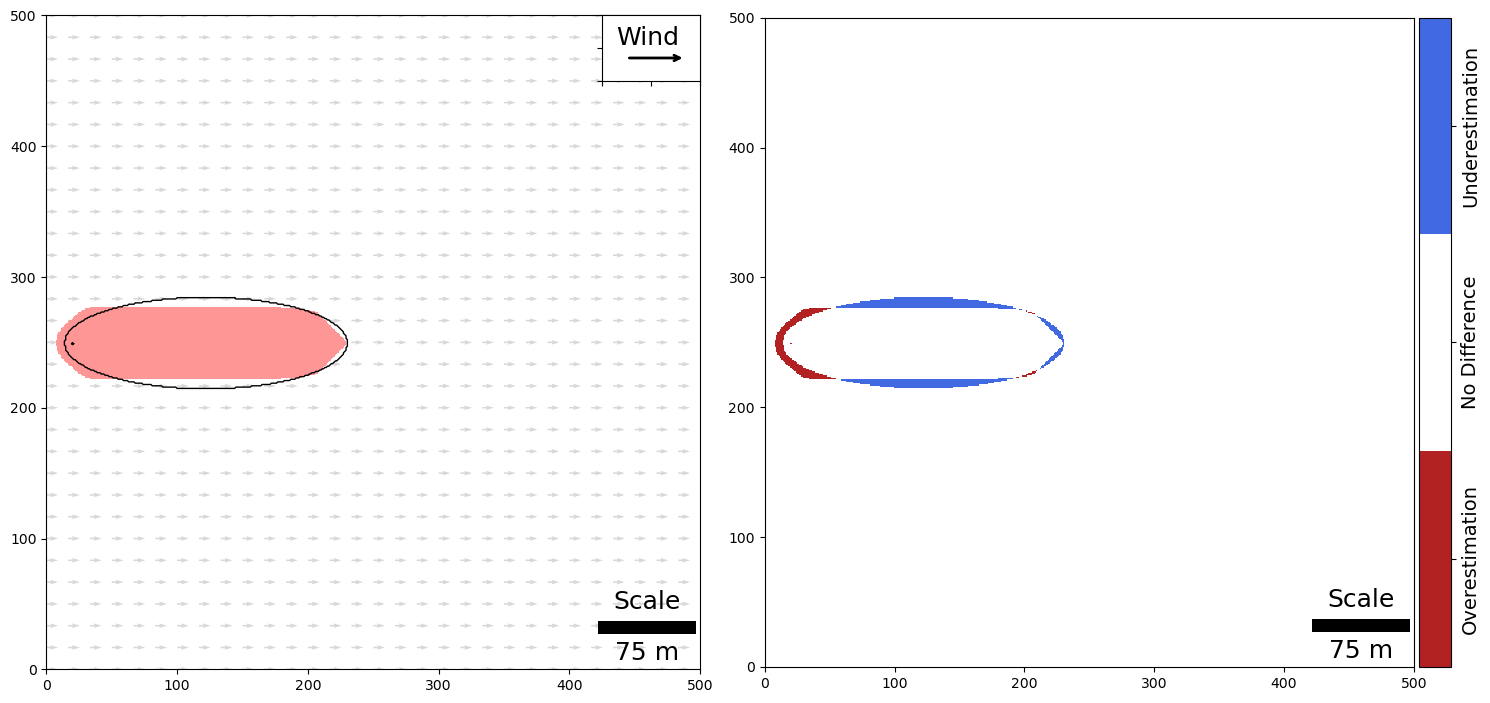

f102_100_ws40_CS500_5HR


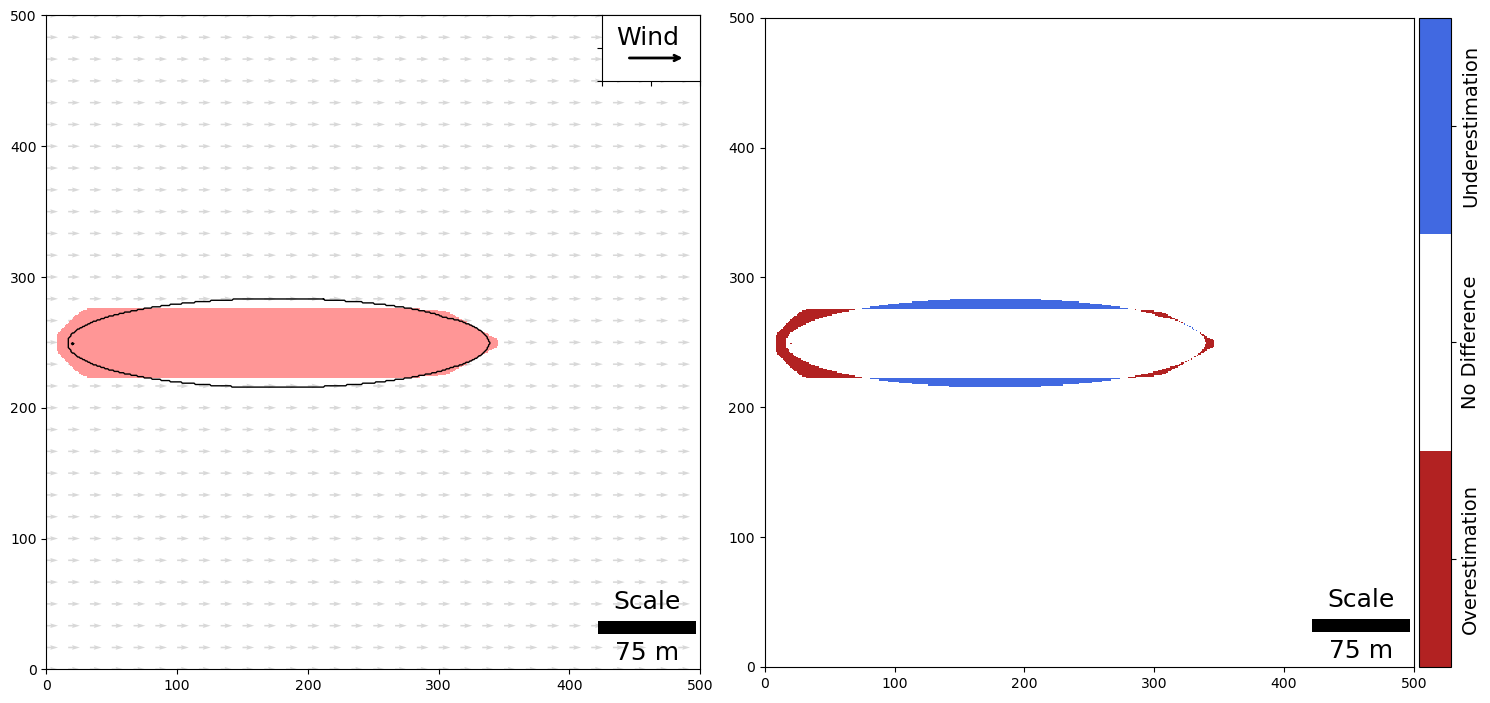

f102_100_ws50_CS500_5HR


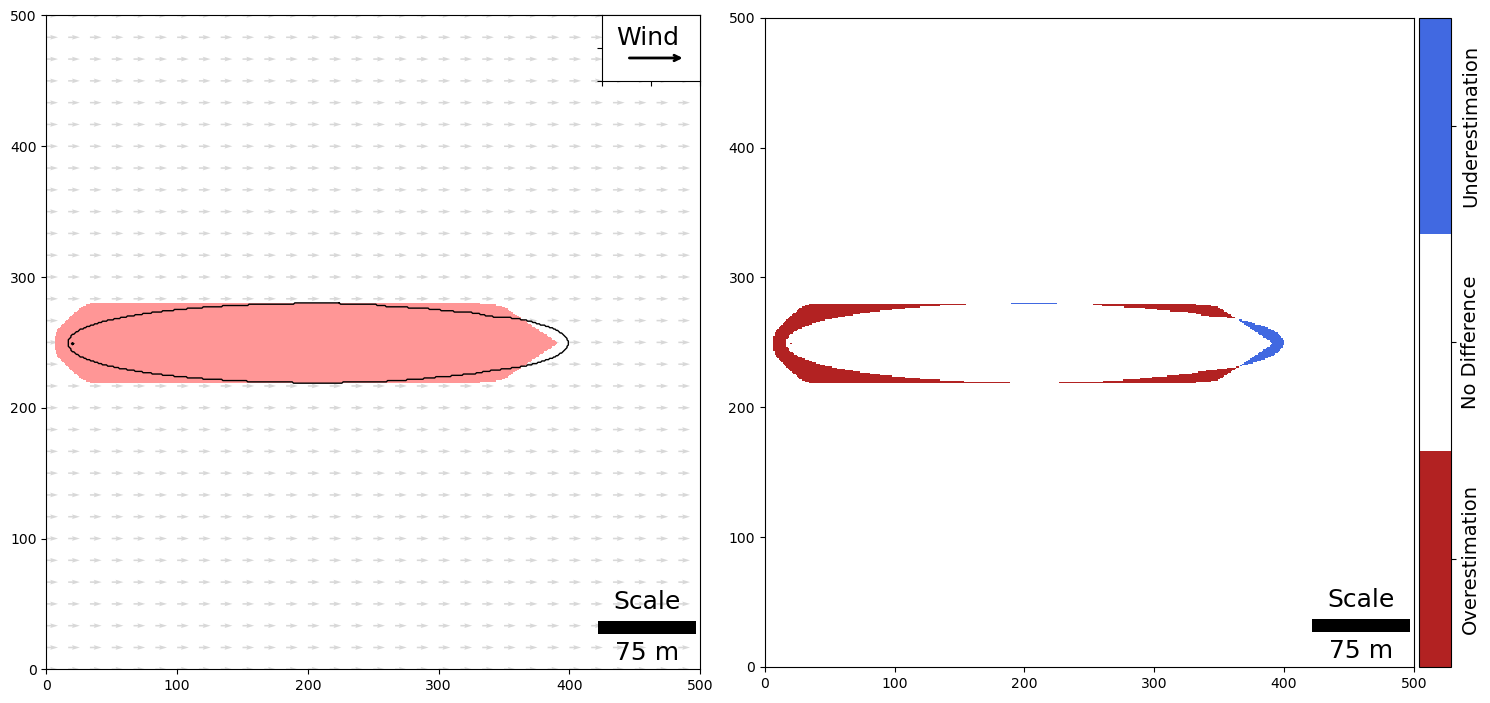

In [11]:
# Input parameters
fuel_type = 102 # change to 122

# Plot fire spread progression for different wind speeds
for wind_speed in [10, 20, 30, 40, 50]:
    
    # Set Instance
    size = 500
    instance = 'f'+str(fuel_type)+'_100_ws'+str(wind_speed)+'_CS' + str(size) +'_5HR'
    print(instance) 

    # Input paths
    farsite_list = sorted(glob.glob(os.path.join(base_path, 'homogeneous', 'f' + str(fuel_type), 'farsite_' + instance + "*.csv")))
    c2f_list = sorted(glob.glob(os.path.join(base_path, 'homogeneous', 'f' + str(fuel_type), 'cell2fire_' + instance + ".csv")))

    # Load datasets
    cell2fire_img = load_cell2fire(c2f_list[0])
    farsite_img = load_farsite_list(farsite_list)

    compare_single_grids(base_path=base_path, 
                        grid1=cell2fire_img, 
                        grid2=farsite_img, 
                        x_size=size, 
                        y_size=size, 
                        fuel_type=fuel_type, 
                        instance=instance,
                        wind_field=True)

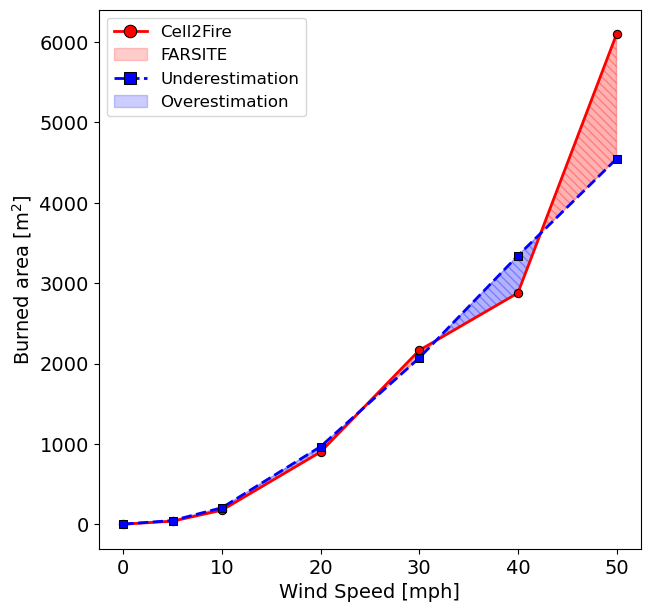

In [61]:
# Accuracy and error scores for Cell2Fire and FARSITE
fuel_type = 101

results_df = pd.read_csv(os.path.join(base_path, 'summary_results.csv'))
results_df['RMSE'] = np.sqrt(results_df['MSE']) # Add RMSE
results_df = results_df.iloc[np.where(results_df['FTYPE']=='f'+str(fuel_type))]
results_df = results_df[:-1] # Cell2Fire

# Plot burn area growth comparison
fig, ax = plt.subplots(1, figsize=(7,7))

num_unique_values = len(results_df['Instance'].unique())
palette = sns.color_palette('RdBu_r', n_colors=num_unique_values)
hatches = ['////', '\\\\\\\\']

# Calculate the difference between the two plots and
# Create a mask for overestimation and underestimation
diff = results_df['AreaFarsite'] - results_df['AreaCell2Fire']
overestimation_mask = diff > 0
underestimation_mask = diff < 0

sns.lineplot(data=results_df, ax=ax, x='WS', y='AreaCell2Fire', legend=True, color='red',
            linewidth=2, marker='o', markeredgecolor='k', palette=palette, label='AreaCell2Fire')
sns.lineplot(data=results_df, ax=ax, x='WS', y='AreaFarsite', color='blue',
            linewidth=2, linestyle='--', marker='s', markeredgecolor='k', palette=palette, legend=True, label='FARSITE')
plt.fill_between(results_df['WS'], results_df['AreaFarsite'], results_df['AreaCell2Fire'], where=overestimation_mask, interpolate=True, color='blue', alpha=0.3, hatch=hatches[1])
plt.fill_between(results_df['WS'], results_df['AreaFarsite'], results_df['AreaCell2Fire'], where=underestimation_mask, interpolate=True, color='red', alpha=0.3, hatch=hatches[1])

ax.set_ylabel('Burned area [m$^2$]', size= 14)
ax.set_xlabel('Wind Speed [mph]', size=14)
ax.tick_params(axis='x', labelsize=14)  # Adjust xticks size
ax.tick_params(axis='y', labelsize=14)  # Adjust yticks size

# Combine the labels
labels = ['Cell2Fire', 'FARSITE', 'Underestimation', 'Overestimation']
plt.legend(labels=labels, fontsize=12, markerscale=1.5)
plt.show()

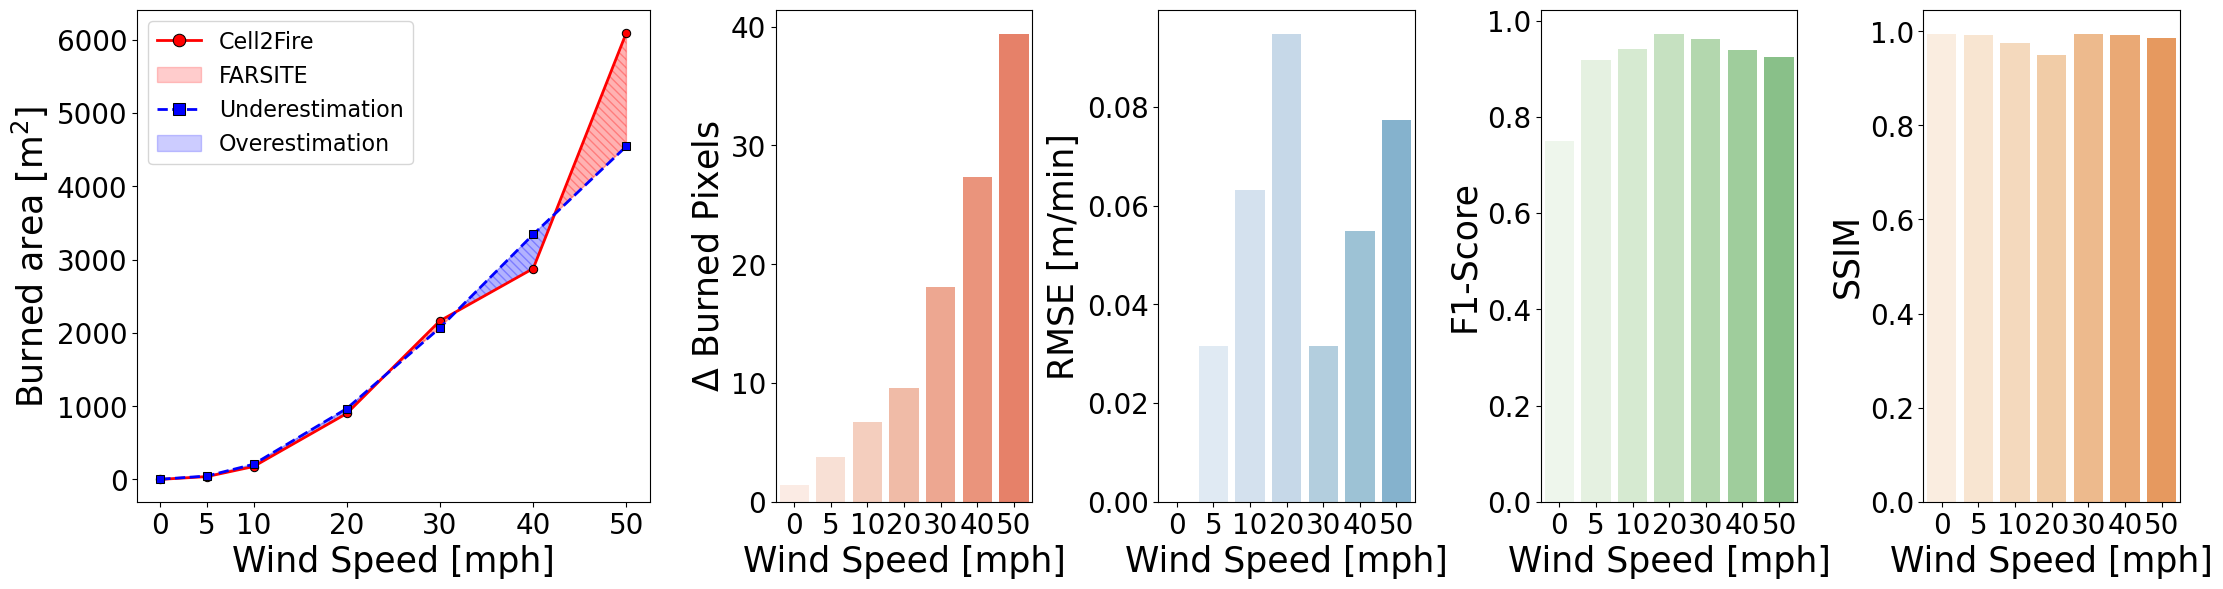

In [62]:
#ALTOGETHER
num_unique_values = len(results_df['Instance'].unique())
colormaps = [sns.color_palette(color, n_colors=num_unique_values*2) for color in ['Reds', 'Blues', 'Greens', 'Oranges'] ]
label_size = 25
tick_label_size = 20

instance = results_df['Instance'].iloc[0].split('_')[0]

fig, ax = plt.subplots(1,5, figsize = (22, 6), sharex=True)

gs = gridspec.GridSpec(1,5, width_ratios=[2,1,1,1,1])
ax = [plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]), plt.subplot(gs[0,3]),plt.subplot(gs[0,4])]

palette = sns.color_palette('RdBu_r', n_colors=num_unique_values)
hatches = ['////', '\\\\\\\\']

# Calculate the difference between the two plots and
# Create a mask for overestimation and underestimation
diff = results_df['AreaFarsite'] - results_df['AreaCell2Fire']
overestimation_mask = diff > 0
underestimation_mask = diff < 0

sns.lineplot(data=results_df, ax=ax[0], x='WS', y='AreaCell2Fire', legend=True, color='red',
            linewidth=2, marker='o', markeredgecolor='k', palette=palette, label='AreaCell2Fire')
sns.lineplot(data=results_df, ax=ax[0], x='WS', y='AreaFarsite', color='blue',
            linewidth=2, linestyle='--', marker='s', markeredgecolor='k', palette=palette, legend=True, label='FARSITE')
ax[0].fill_between(results_df['WS'], results_df['AreaFarsite'], results_df['AreaCell2Fire'], where=overestimation_mask, interpolate=True, color='blue', alpha=0.3, hatch=hatches[1])
ax[0].fill_between(results_df['WS'], results_df['AreaFarsite'], results_df['AreaCell2Fire'], where=underestimation_mask, interpolate=True, color='red', alpha=0.3, hatch=hatches[1])

ax[0].set_ylabel('Burned area [m$^2$]', size= label_size)
ax[0].set_xlabel('Wind Speed [mph]', size=label_size)
ax[0].tick_params(axis='x', labelsize=14)  # Adjust xticks size
ax[0].tick_params(axis='y', labelsize=14)  # Adjust yticks size
ax[0].set_xticks([0,5,10,20,30,40,50])
ax[0].set_xticklabels(results_df['WS'])

# Combine the labels
labels = ['Cell2Fire', 'FARSITE', 'Underestimation', 'Overestimation']
ax[0].legend(labels=labels, fontsize=16, markerscale=1.5)

sns.barplot(ax=ax[1], data=results_df, x="WS", y="$\delta$ norm", palette=colormaps[0])
# ax[0].set_title("$\delta$ norm", size=label_size)
ax[1].set_xlabel("Wind Speed [mph]", size=label_size)
ax[1].set_ylabel("$\Delta$ Burned Pixels", size=label_size)

sns.barplot(ax=ax[2], data=results_df, x="WS", y="RMSE",palette=colormaps[1])
# ax[1].set_title("MSE", size=14)
ax[2].set_xlabel("Wind Speed [mph]", size=label_size)
ax[2].set_ylabel("RMSE [m/min]", size=label_size)

sns.barplot(ax=ax[3], data=results_df, x="WS", y="F1",palette=colormaps[2])
# ax[2].set_title("F1-Score", size=14)
ax[3].set_xlabel("Wind Speed [mph]", size=label_size)
ax[3].set_ylabel("F1-Score", size=label_size)

sns.barplot(ax=ax[4], data=results_df, x="WS", y="SSIM",palette=colormaps[3])
# ax[3].set_title("SSIM", size=14)
ax[4].set_xlabel("Wind Speed [mph]", size=label_size)
ax[4].set_ylabel("SSIM", size=label_size)    

for i in range(5):
    # ax[i].set_ylabel('')
    ax[i].tick_params(axis='x', labelsize=tick_label_size) 
    ax[i].tick_params(axis='y', labelsize=tick_label_size) 


plt.tight_layout()

plt.savefig(os.path.join(base_path, instance) + '_f101_error_together.png', bbox_inches='tight', dpi=300)
plt.show()

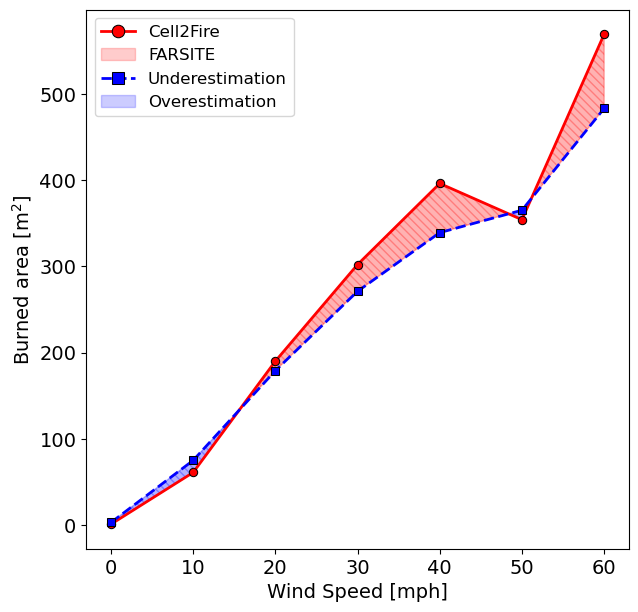

In [63]:
# Accuracy and error scores for Cell2Fire and FARSITE
fuel_type = 165

results_df = pd.read_csv(os.path.join(base_path, 'summary_results.csv'))
results_df['RMSE'] = np.sqrt(results_df['MSE']) # Add RMSE
results_df = results_df.iloc[np.where(results_df['FTYPE']=='f'+str(fuel_type))]
# results_df = results_df[:-1] # Cell2Fire

# Plot burn area growth comparison
fig, ax = plt.subplots(1, figsize=(7,7))

num_unique_values = len(results_df['Instance'].unique())
palette = sns.color_palette('RdBu_r', n_colors=num_unique_values)
hatches = ['////', '\\\\\\\\']

# Calculate the difference between the two plots and
# Create a mask for overestimation and underestimation
diff = results_df['AreaFarsite'] - results_df['AreaCell2Fire']
overestimation_mask = diff > 0
underestimation_mask = diff < 0

sns.lineplot(data=results_df, ax=ax, x='WS', y='AreaCell2Fire', legend=True, color='red',
            linewidth=2, marker='o', markeredgecolor='k', palette=palette, label='AreaCell2Fire')
sns.lineplot(data=results_df, ax=ax, x='WS', y='AreaFarsite', color='blue',
            linewidth=2, linestyle='--', marker='s', markeredgecolor='k', palette=palette, legend=True, label='FARSITE')
plt.fill_between(results_df['WS'], results_df['AreaFarsite'], results_df['AreaCell2Fire'], where=overestimation_mask, interpolate=True, color='blue', alpha=0.3, hatch=hatches[1])
plt.fill_between(results_df['WS'], results_df['AreaFarsite'], results_df['AreaCell2Fire'], where=underestimation_mask, interpolate=True, color='red', alpha=0.3, hatch=hatches[1])

ax.set_ylabel('Burned area [m$^2$]', size= 14)
ax.set_xlabel('Wind Speed [mph]', size=14)
ax.tick_params(axis='x', labelsize=14)  # Adjust xticks size
ax.tick_params(axis='y', labelsize=14)  # Adjust yticks size

# Combine the labels
labels = ['Cell2Fire', 'FARSITE', 'Underestimation', 'Overestimation']
plt.legend(labels=labels, fontsize=12, markerscale=1.5)
plt.show()

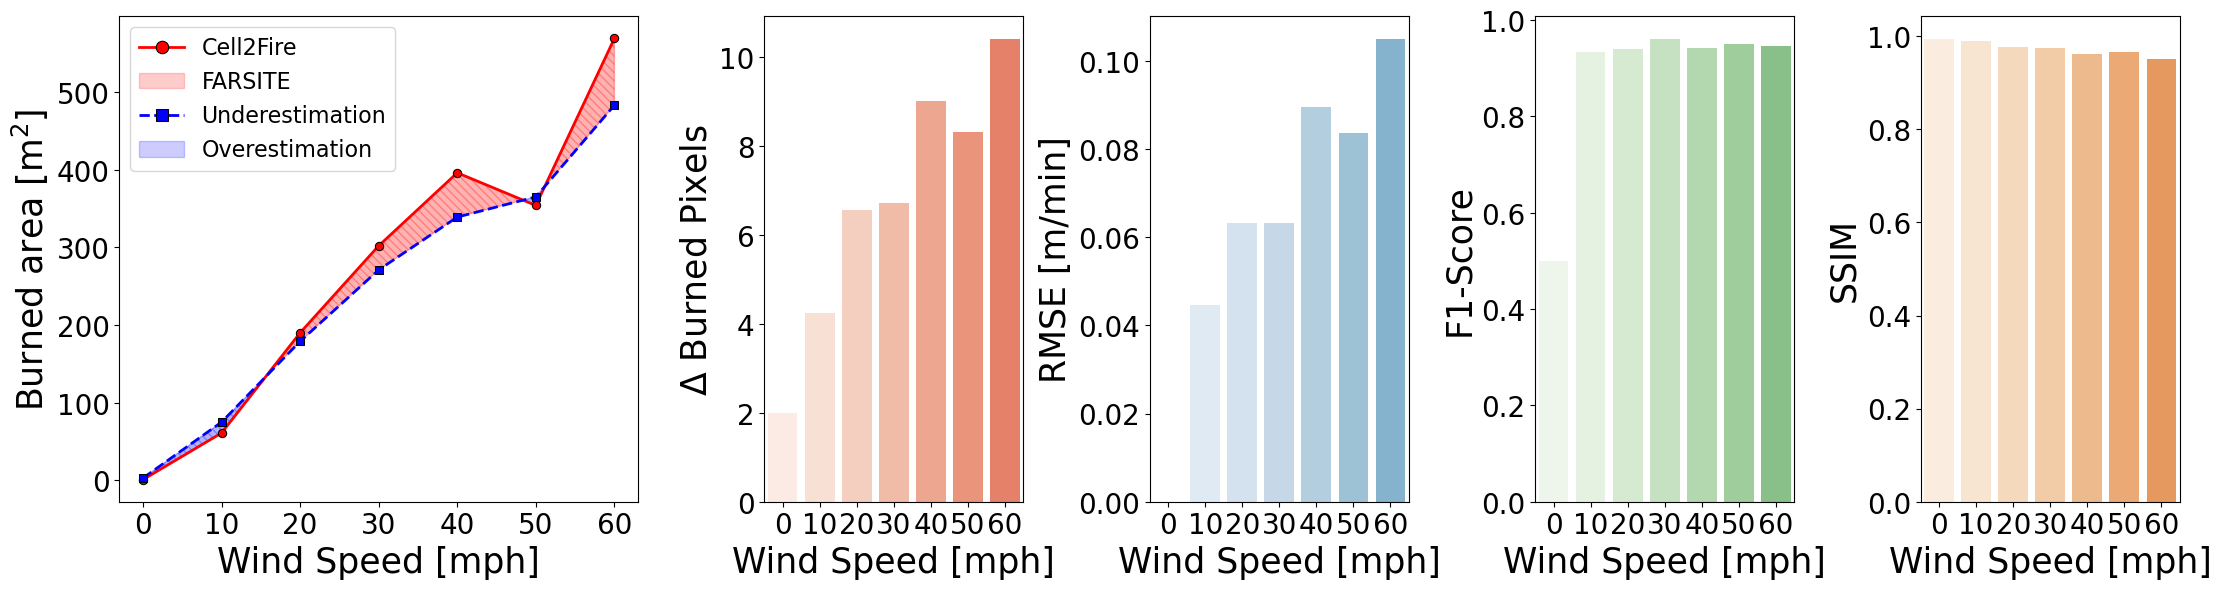

In [64]:
#ALTOGETHER
num_unique_values = len(results_df['Instance'].unique())
colormaps = [sns.color_palette(color, n_colors=num_unique_values*2) for color in ['Reds', 'Blues', 'Greens', 'Oranges'] ]
label_size = 25
tick_label_size = 20

instance = results_df['Instance'].iloc[0].split('_')[0]

fig, ax = plt.subplots(1,5, figsize = (22, 6), sharex=True)

gs = gridspec.GridSpec(1,5, width_ratios=[2,1,1,1,1])
ax = [plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]), plt.subplot(gs[0,3]),plt.subplot(gs[0,4])]

num_unique_values = len(results_df['Instance'].unique())
palette = sns.color_palette('RdBu_r', n_colors=num_unique_values)
hatches = ['////', '\\\\\\\\']

# Calculate the difference between the two plots and
# Create a mask for overestimation and underestimation
diff = results_df['AreaFarsite'] - results_df['AreaCell2Fire']
overestimation_mask = diff > 0
underestimation_mask = diff < 0

sns.lineplot(data=results_df, ax=ax[0], x='WS', y='AreaCell2Fire', legend=True, color='red',
            linewidth=2, marker='o', markeredgecolor='k', palette=palette, label='AreaCell2Fire')
sns.lineplot(data=results_df, ax=ax[0], x='WS', y='AreaFarsite', color='blue',
            linewidth=2, linestyle='--', marker='s', markeredgecolor='k', palette=palette, legend=True, label='FARSITE')
ax[0].fill_between(results_df['WS'], results_df['AreaFarsite'], results_df['AreaCell2Fire'], where=overestimation_mask, interpolate=True, color='blue', alpha=0.3, hatch=hatches[1])
ax[0].fill_between(results_df['WS'], results_df['AreaFarsite'], results_df['AreaCell2Fire'], where=underestimation_mask, interpolate=True, color='red', alpha=0.3, hatch=hatches[1])

ax[0].set_ylabel('Burned area [m$^2$]', size= label_size)
ax[0].set_xlabel('Wind Speed [mph]', size=label_size)
ax[0].tick_params(axis='x', labelsize=14)  # Adjust xticks size
ax[0].tick_params(axis='y', labelsize=14)  # Adjust yticks size
ax[0].set_xticks(np.arange(0, np.max(results_df['WS']) + 10, 10))
ax[0].set_xticklabels(results_df['WS'])

# Combine the labels
labels = ['Cell2Fire', 'FARSITE', 'Underestimation', 'Overestimation']
ax[0].legend(labels=labels, fontsize=16, markerscale=1.5)

sns.barplot(ax=ax[1], data=results_df, x="WS", y="$\delta$ norm", palette=colormaps[0])
# ax[0].set_title("$\delta$ norm", size=label_size)
ax[1].set_xlabel("Wind Speed [mph]", size=label_size)
ax[1].set_ylabel("$\Delta$ Burned Pixels", size=label_size)

sns.barplot(ax=ax[2], data=results_df, x="WS", y="RMSE",palette=colormaps[1])
# ax[1].set_title("MSE", size=14)
ax[2].set_xlabel("Wind Speed [mph]", size=label_size)
ax[2].set_ylabel("RMSE [m/min]", size=label_size)

sns.barplot(ax=ax[3], data=results_df, x="WS", y="F1",palette=colormaps[2])
# ax[2].set_title("F1-Score", size=14)
ax[3].set_xlabel("Wind Speed [mph]", size=label_size)
ax[3].set_ylabel("F1-Score", size=label_size)

sns.barplot(ax=ax[4], data=results_df, x="WS", y="SSIM",palette=colormaps[3])
# ax[3].set_title("SSIM", size=14)
ax[4].set_xlabel("Wind Speed [mph]", size=label_size)
ax[4].set_ylabel("SSIM", size=label_size)    

for i in range(5):
    # ax[i].set_ylabel('')
    ax[i].tick_params(axis='x', labelsize=tick_label_size) 
    ax[i].tick_params(axis='y', labelsize=tick_label_size) 


plt.tight_layout()
plt.savefig(os.path.join(base_path, instance) + '_f165_error_together.png', bbox_inches='tight', dpi=300)
plt.show()

## 2. FBP (Canada)

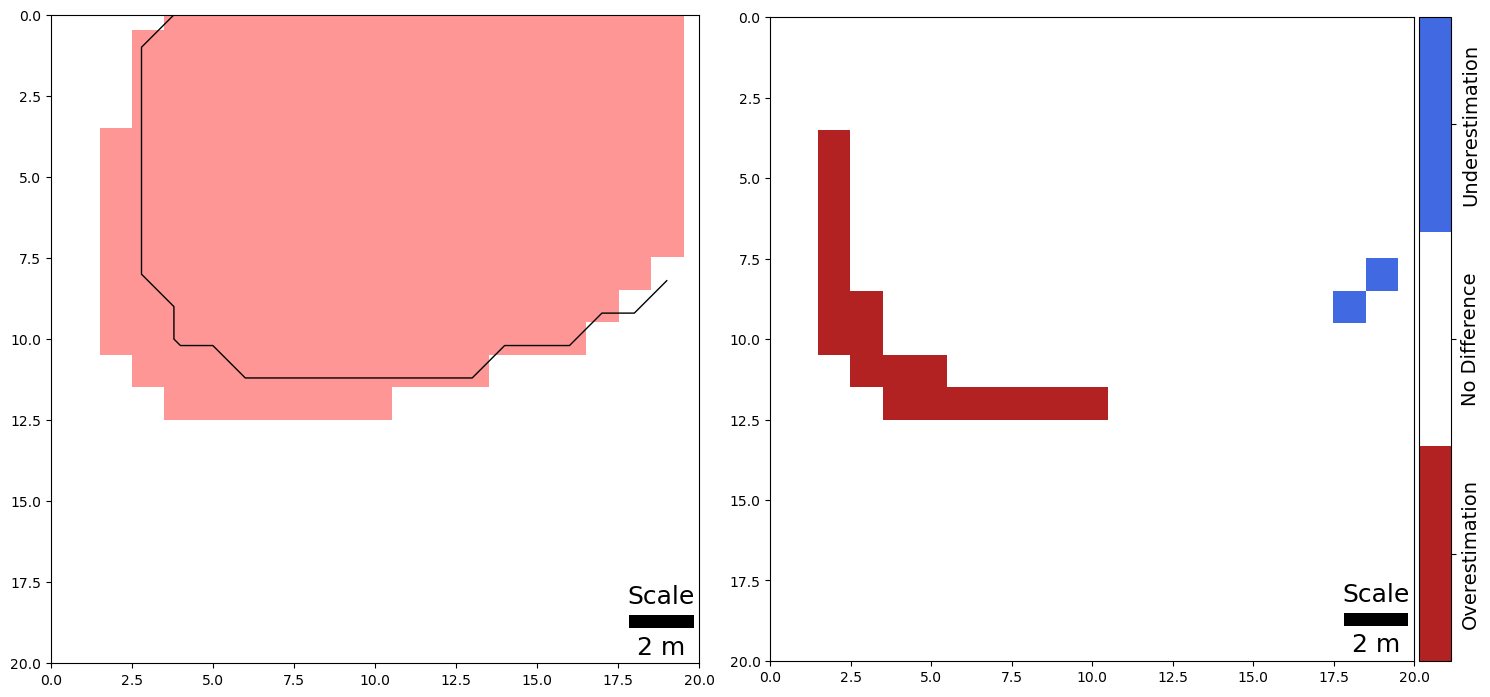

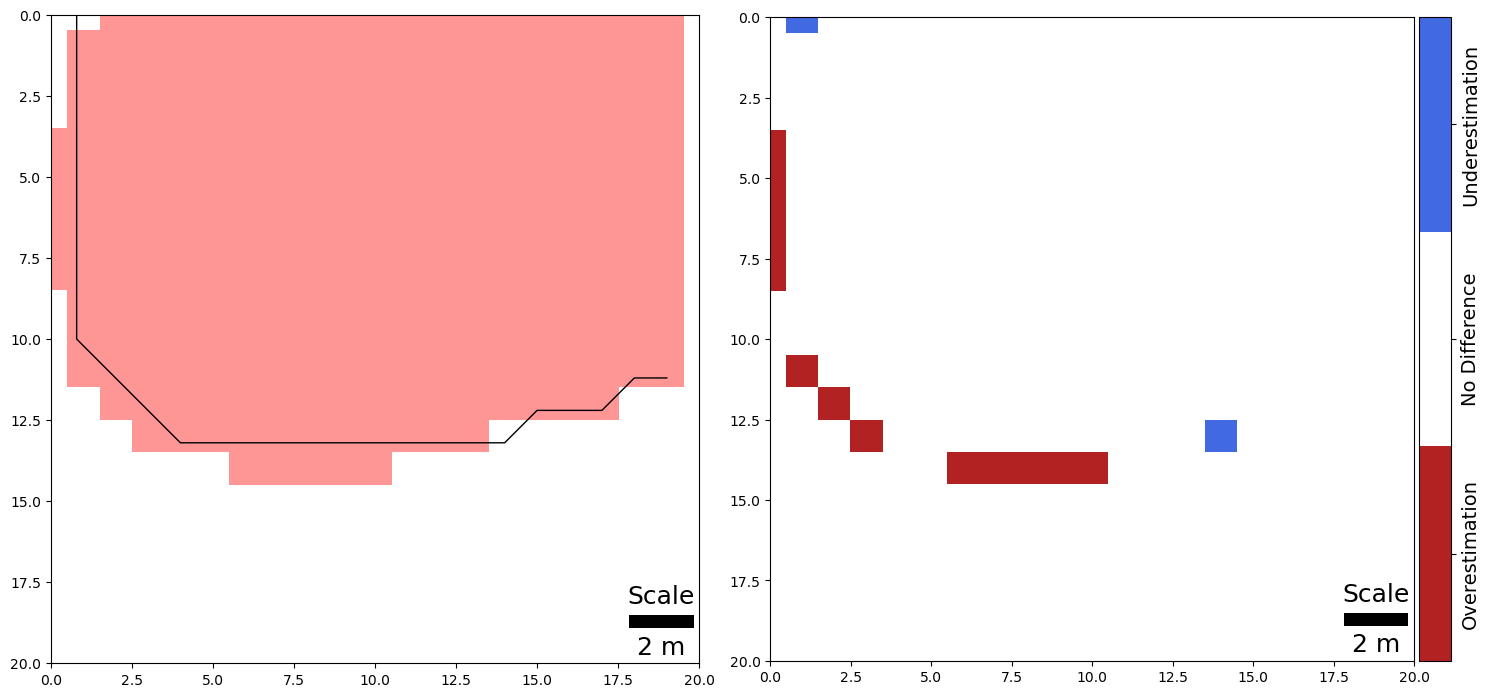

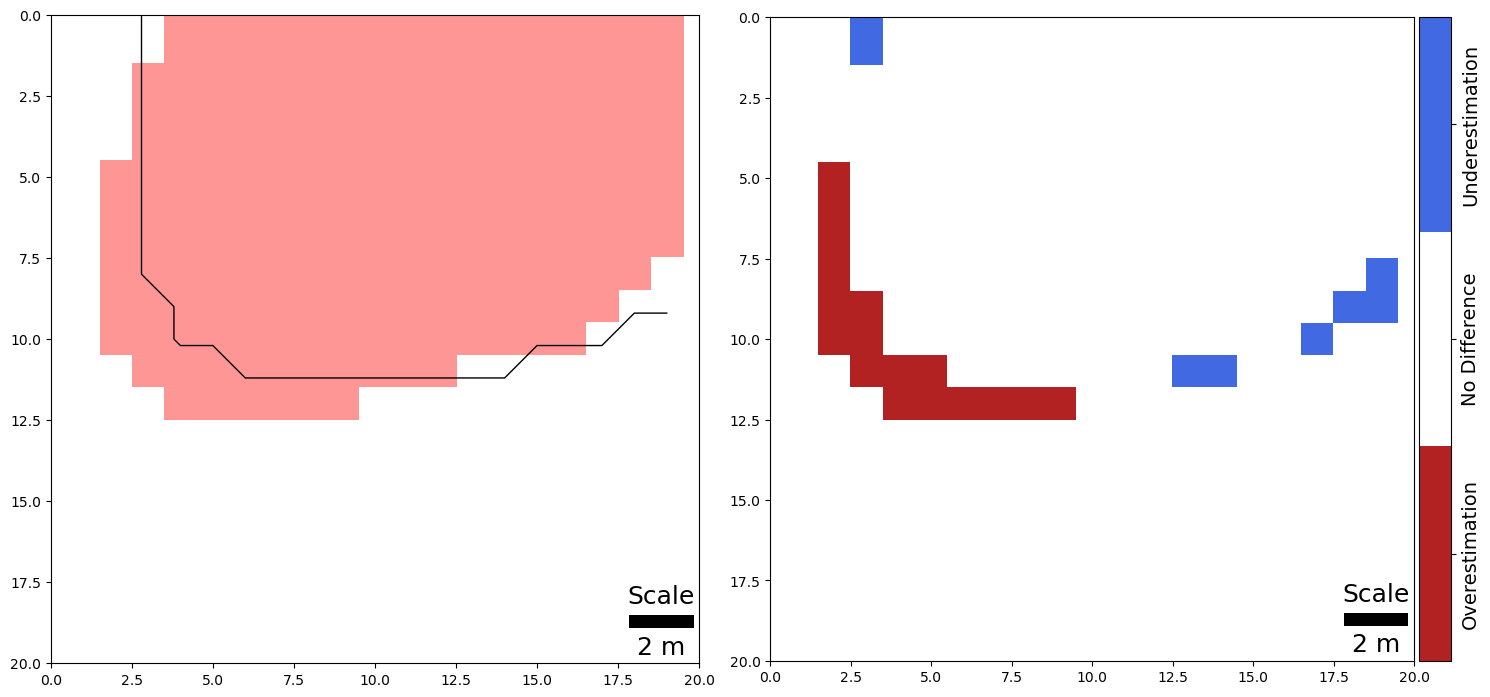

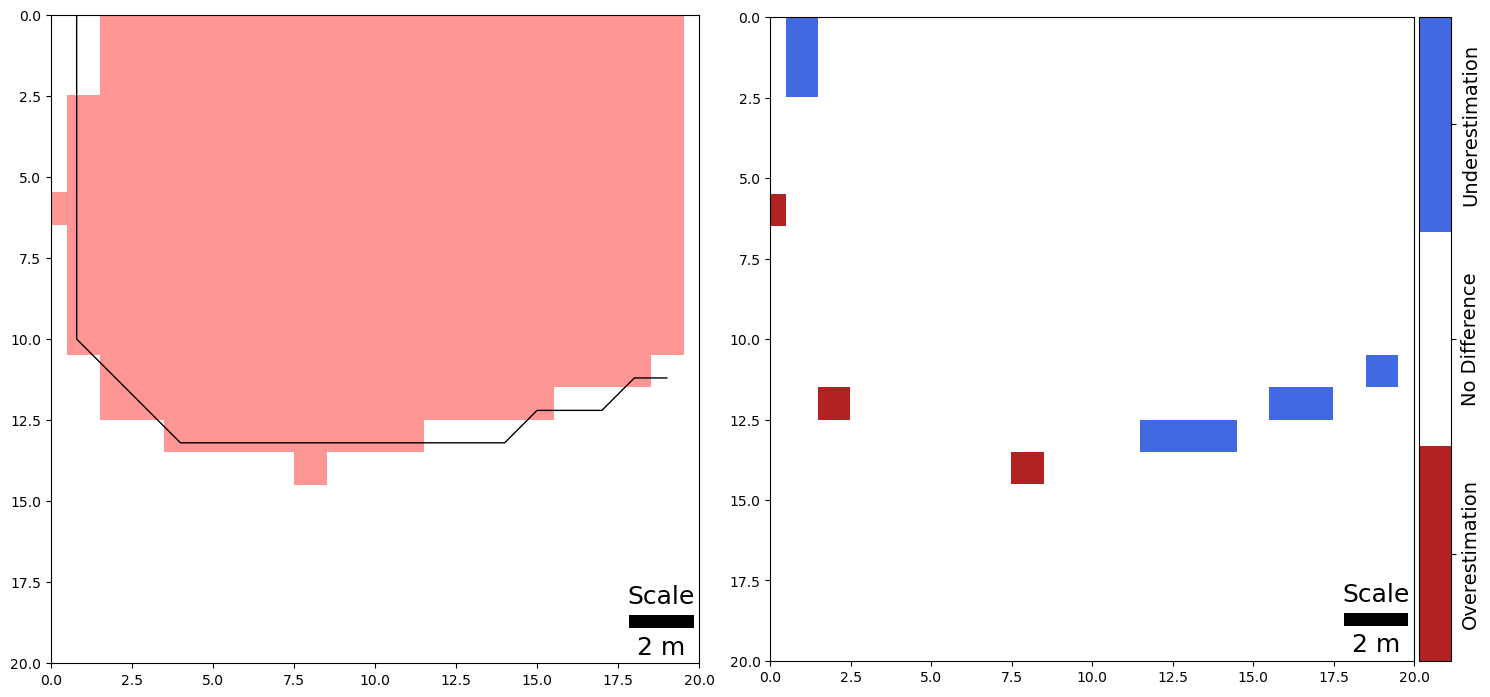

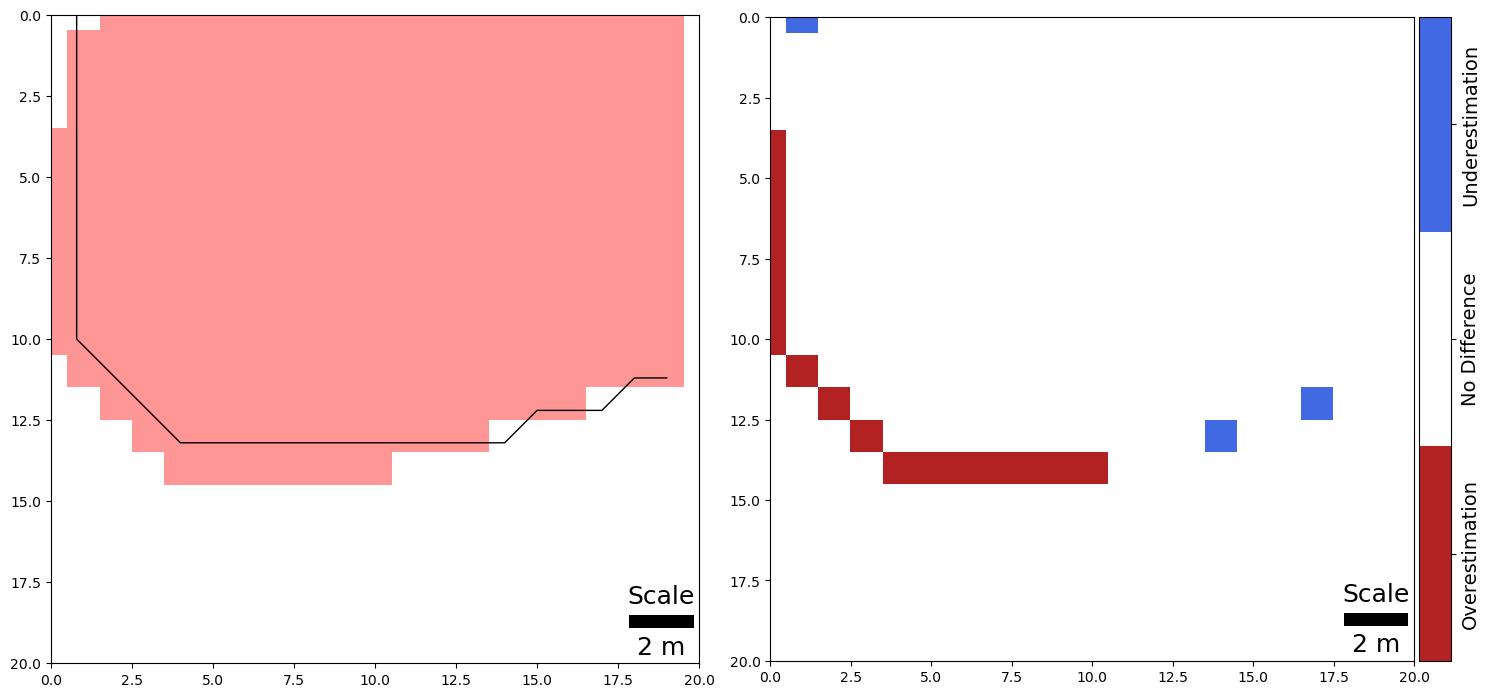

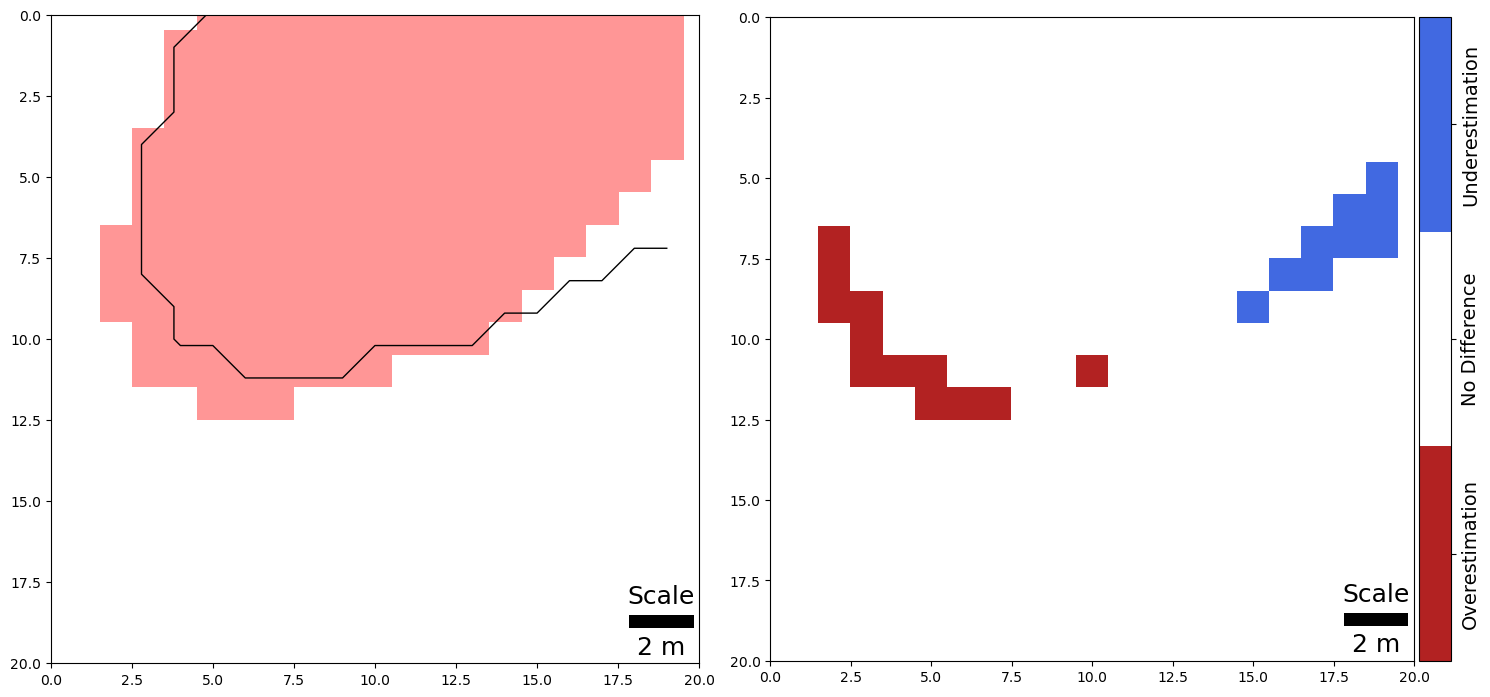

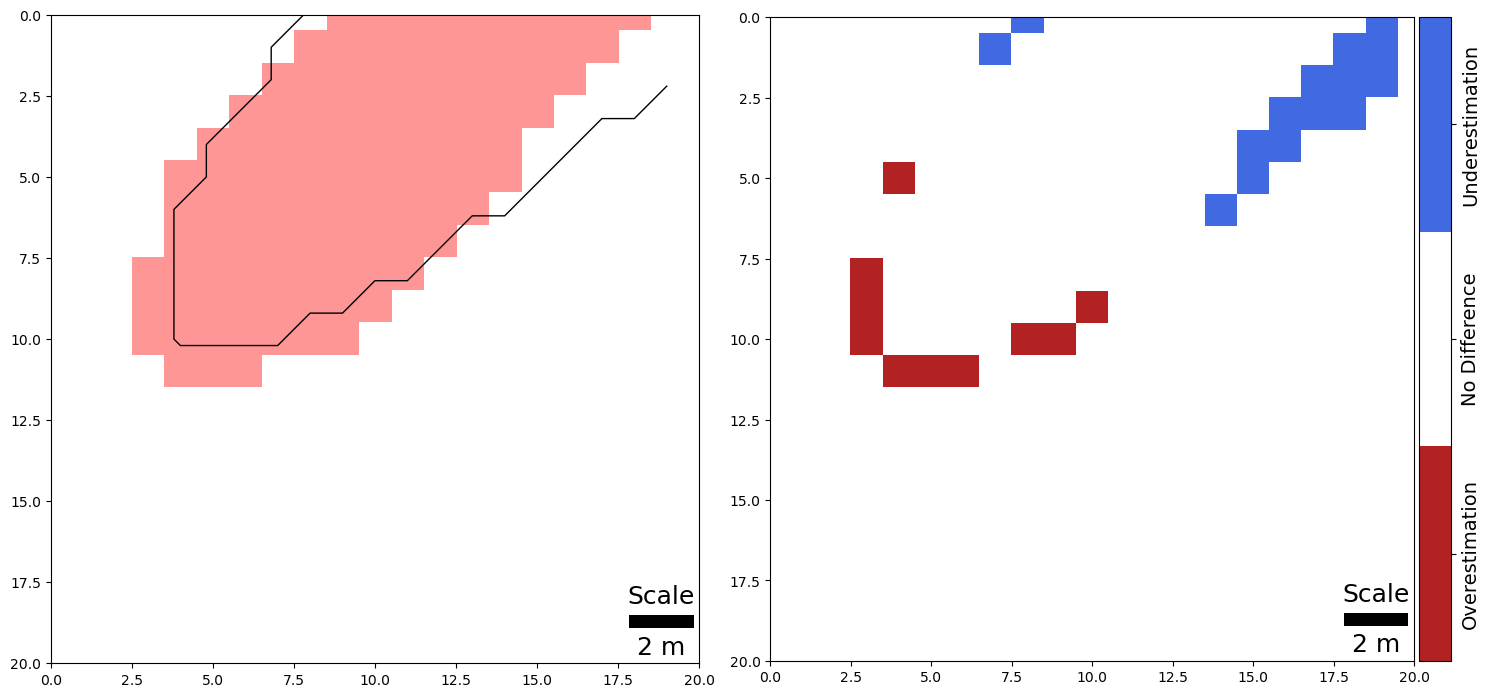

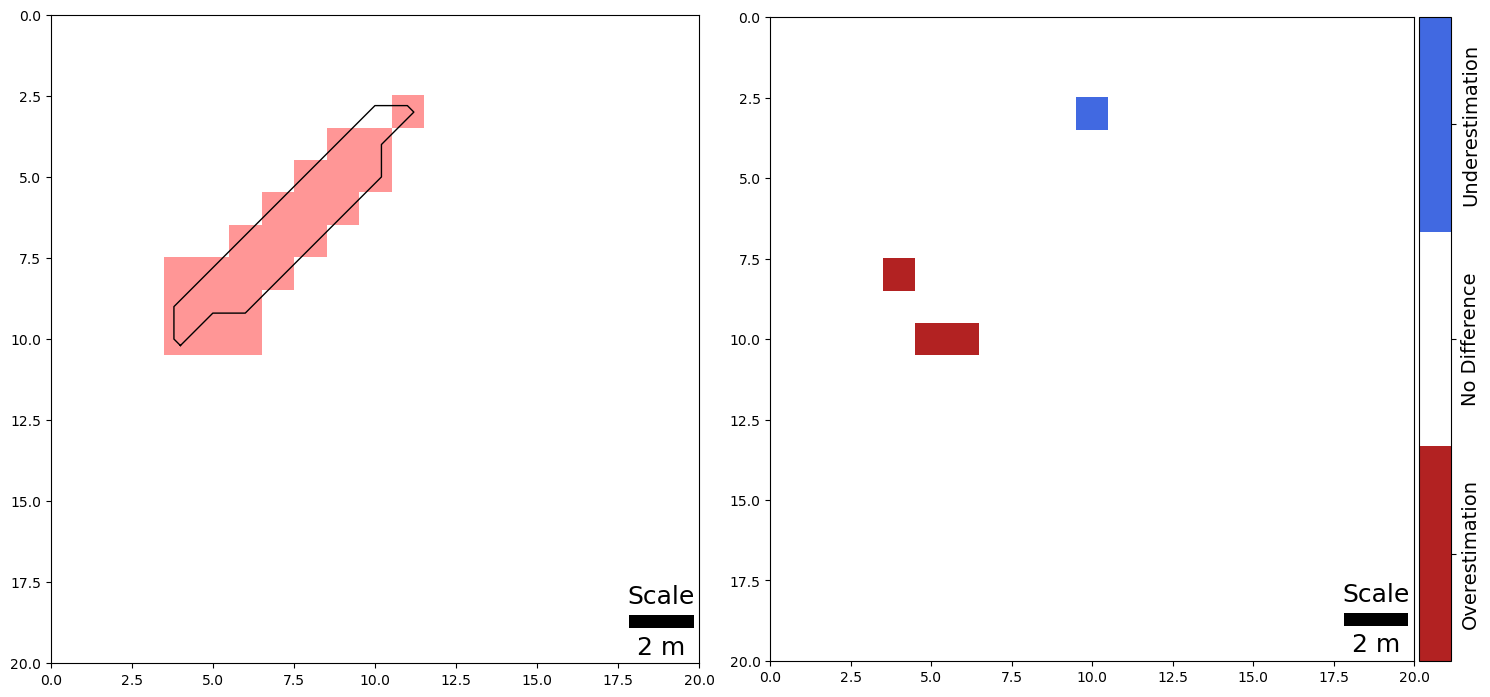

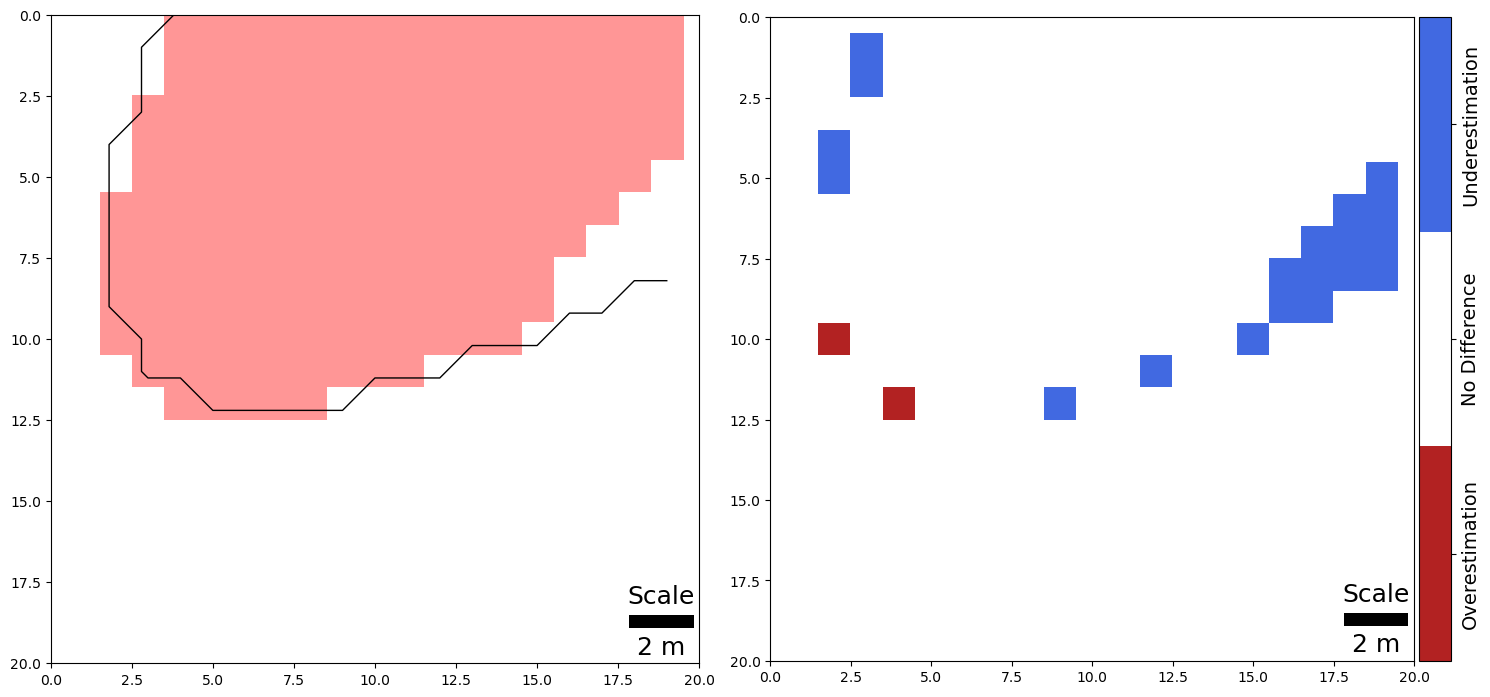

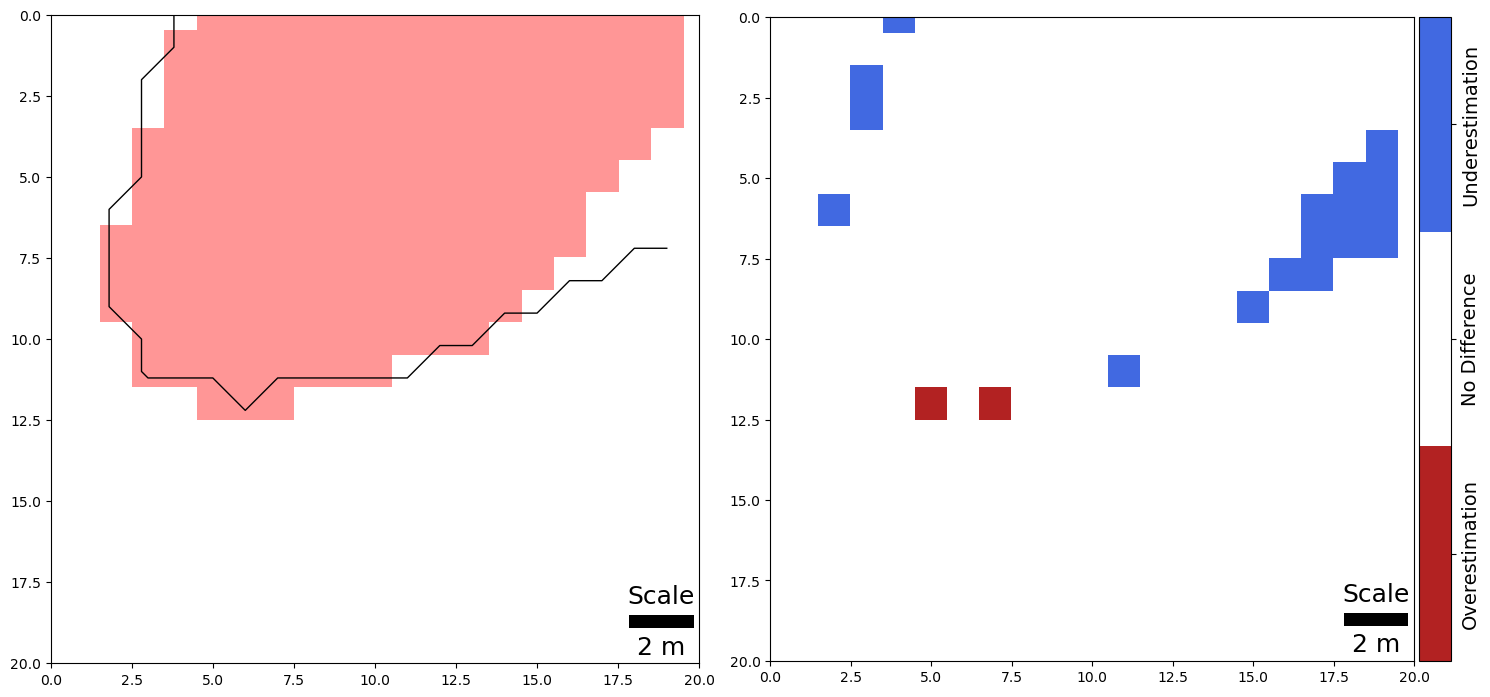

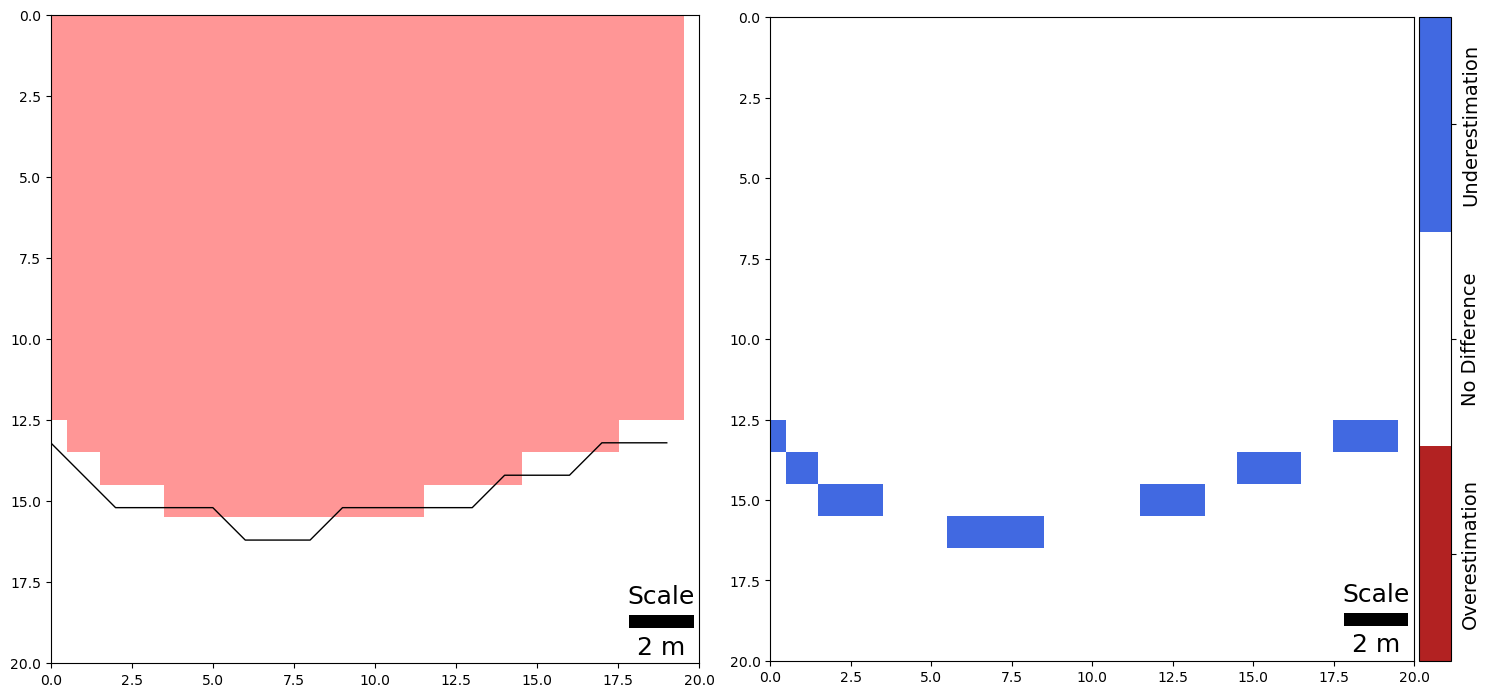

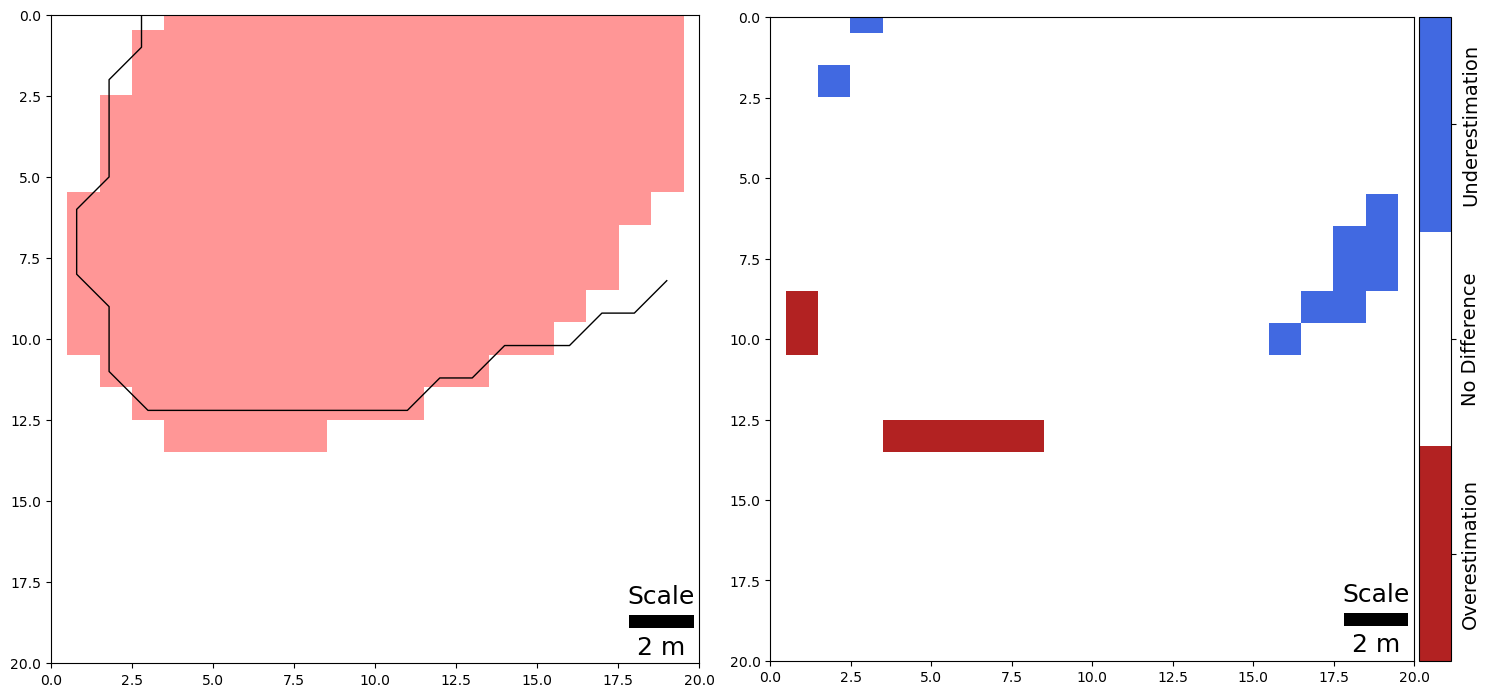

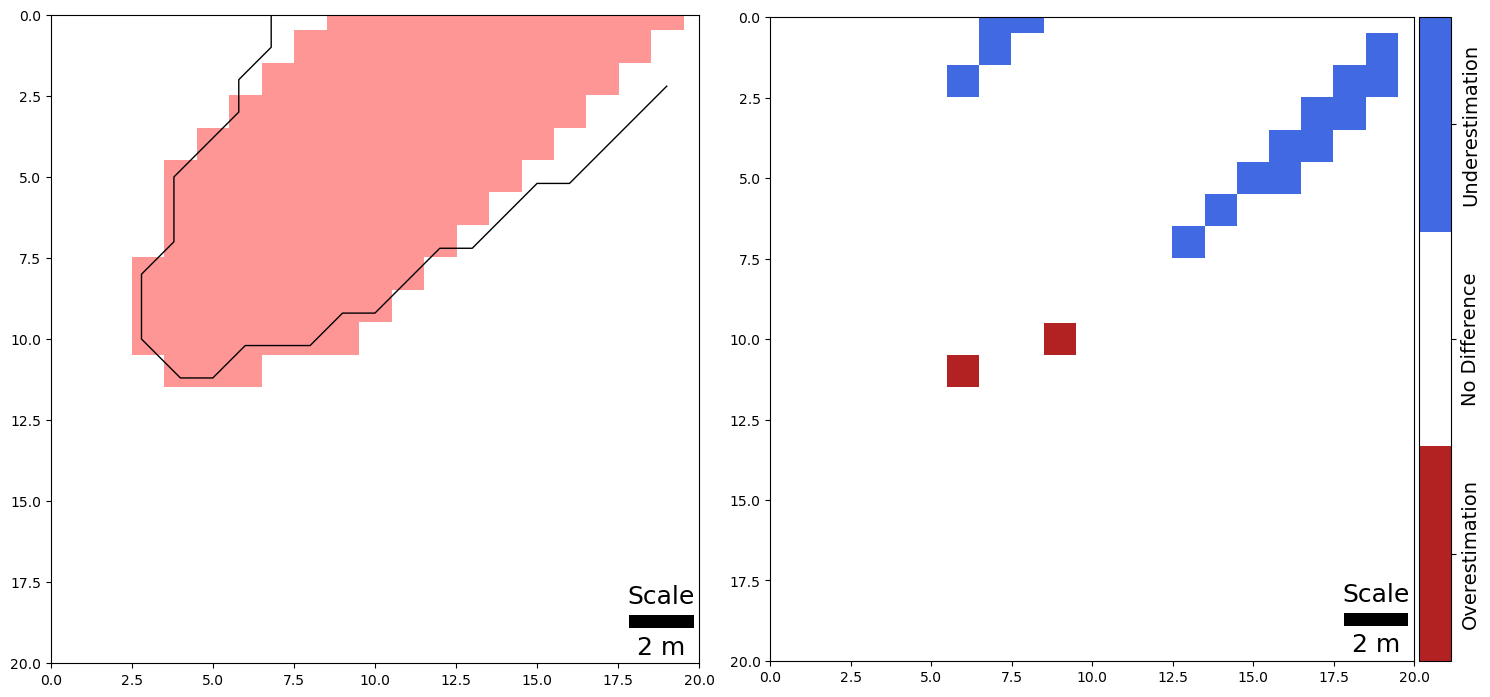

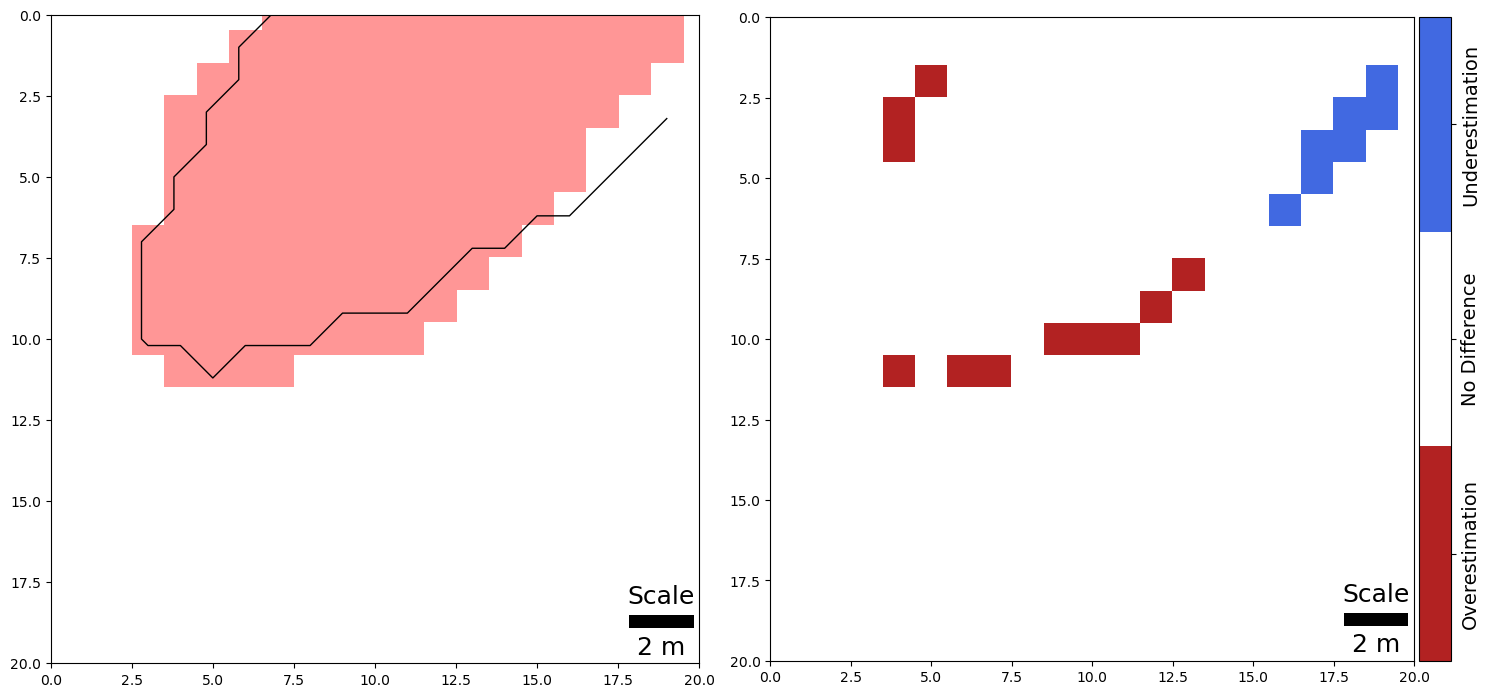

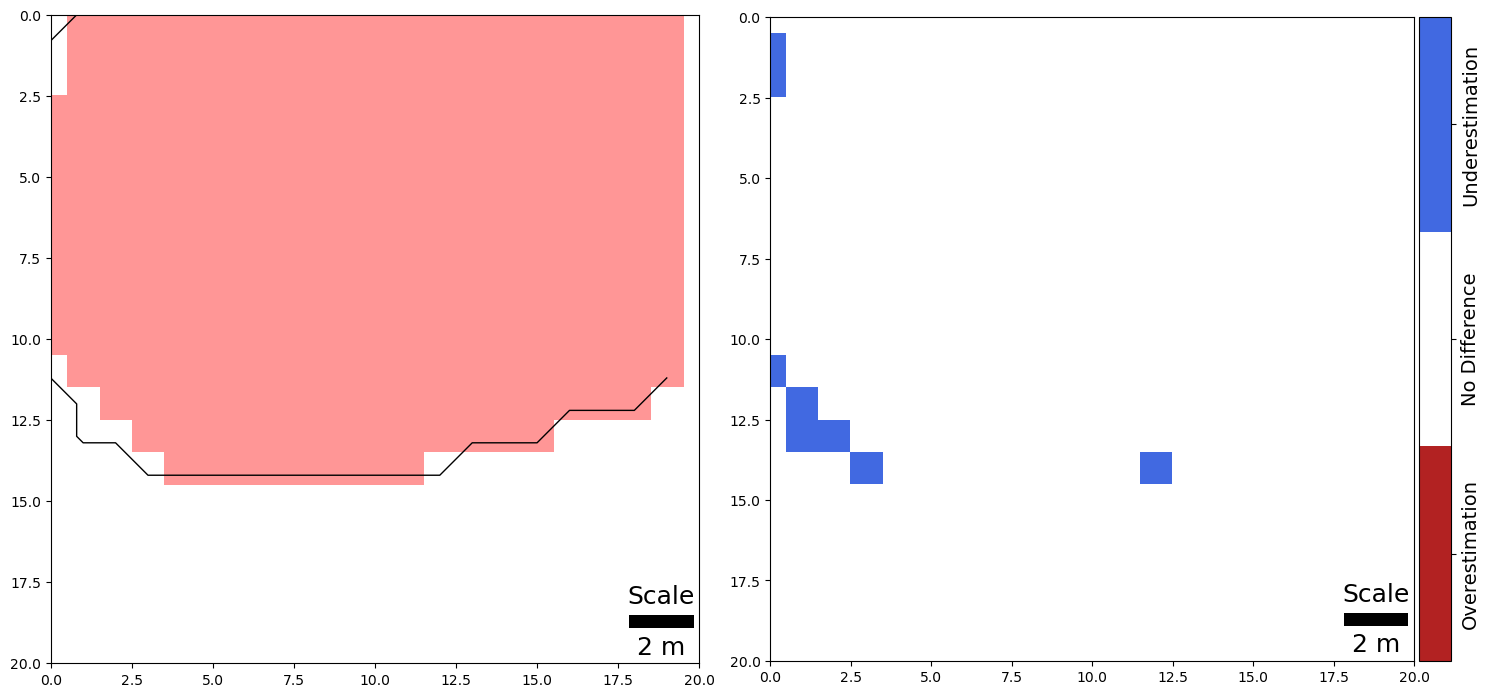

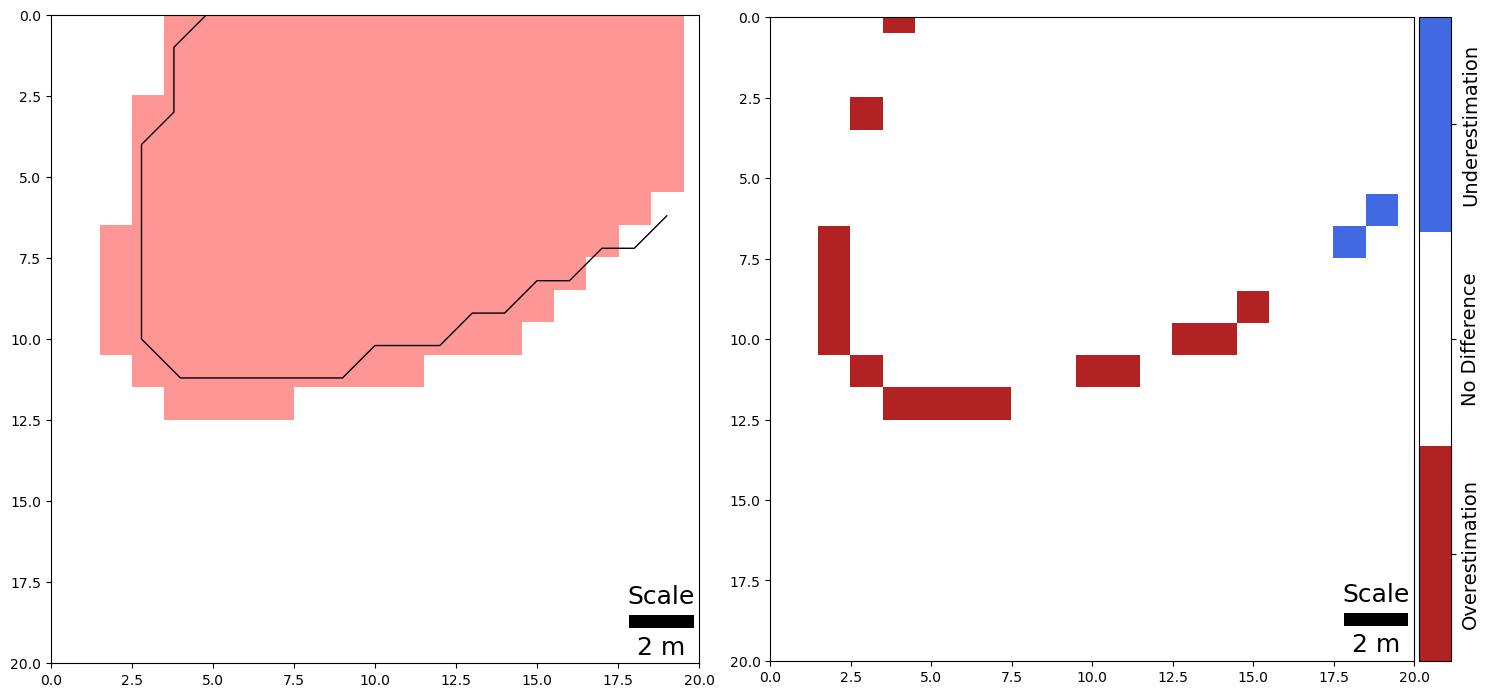

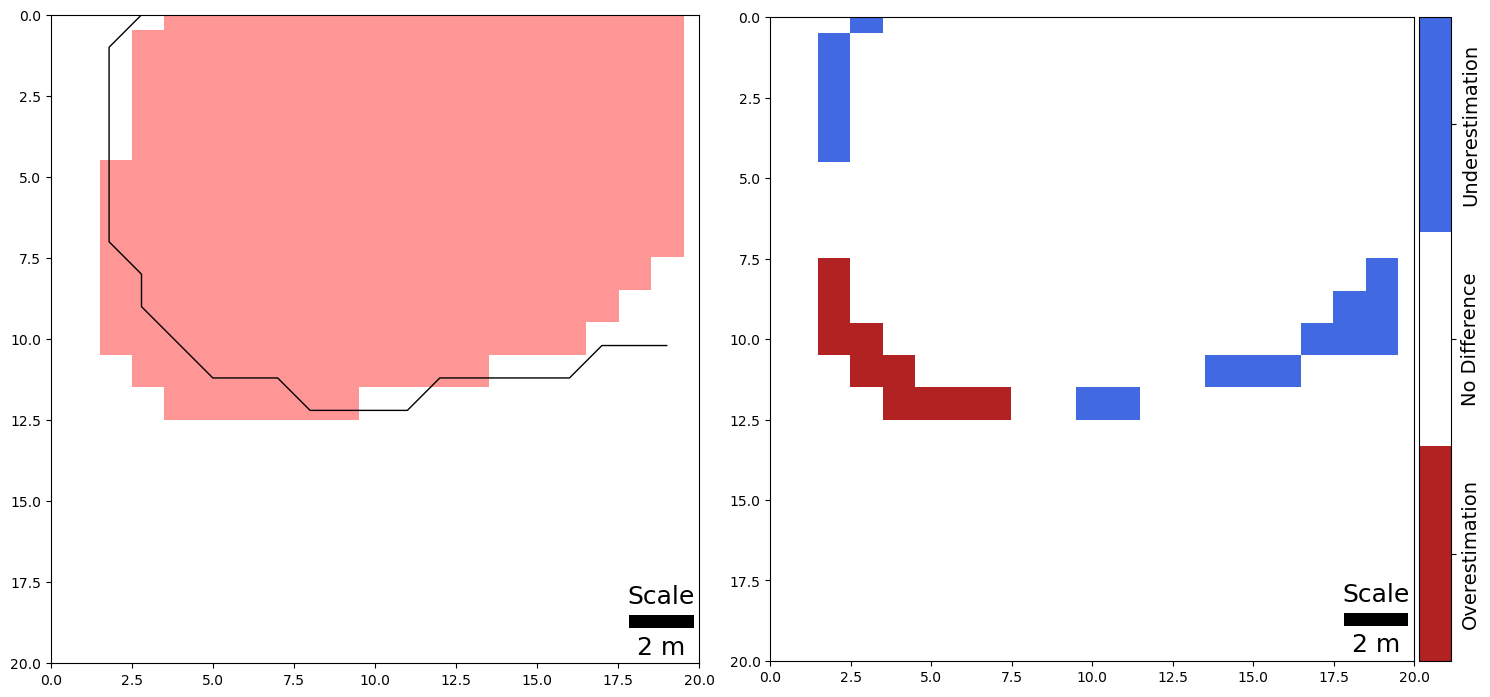

In [13]:
# Set base path
base_path = os.path.join(BASE_PATH, 'CANADA/homogeneous')

# Input parameters
fuel_types = ['C1', 'C2', 'C3','C4','C5','C6','D1','D2','M1','M2','M3','M4','O1a','O1b','S1','S2','S3']

for fuel_type in fuel_types:
        
    instance = '400CellsHom' + fuel_type

    # Input paths
    prometheus_list = sorted(glob.glob(os.path.join(base_path, 'prometheus_' + instance + "*.csv")))
    c2f_list = sorted(glob.glob(os.path.join(base_path, 'cell2fire_' + instance + ".csv")))

    # Load datasets
    cell2fire_img = load_cell2fire(c2f_list[0])
    prometheus_img = load_farsite_list(prometheus_list)

    compare_single_grids(base_path=base_path, 
                        grid1=cell2fire_img, 
                        grid2=prometheus_img, 
                        x_size=20, 
                        y_size=20, 
                        fuel_type=fuel_type,
                        instance=instance,
                        wind_field=False)

## 3. KITRAL (Chile)

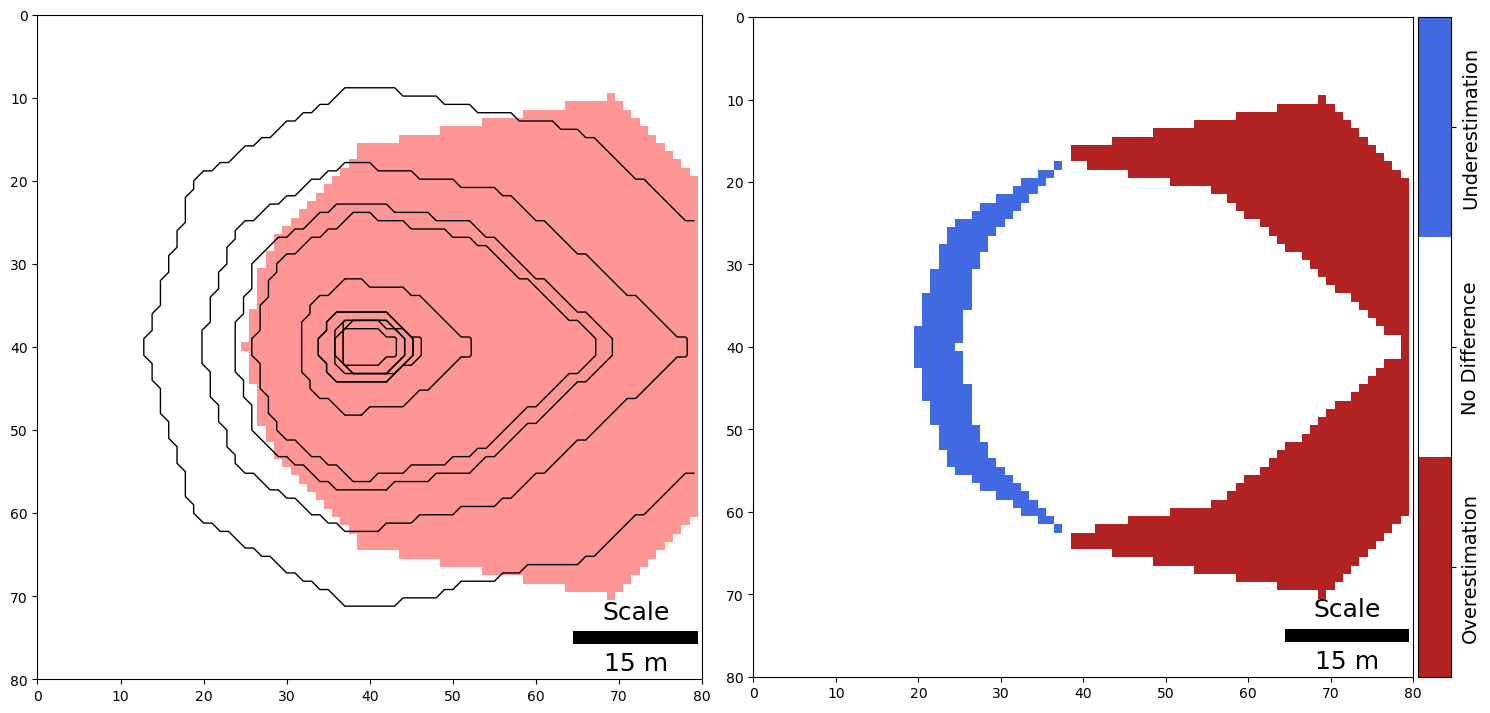

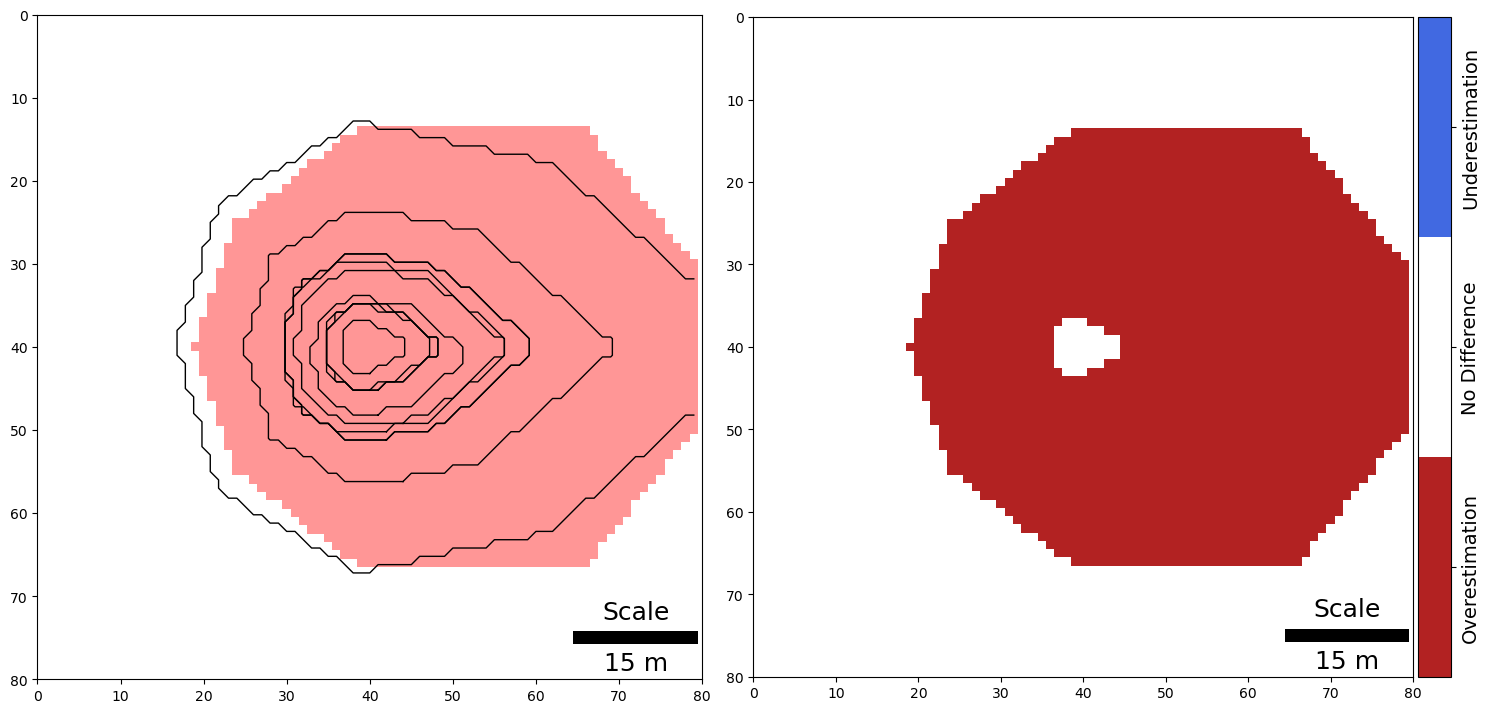

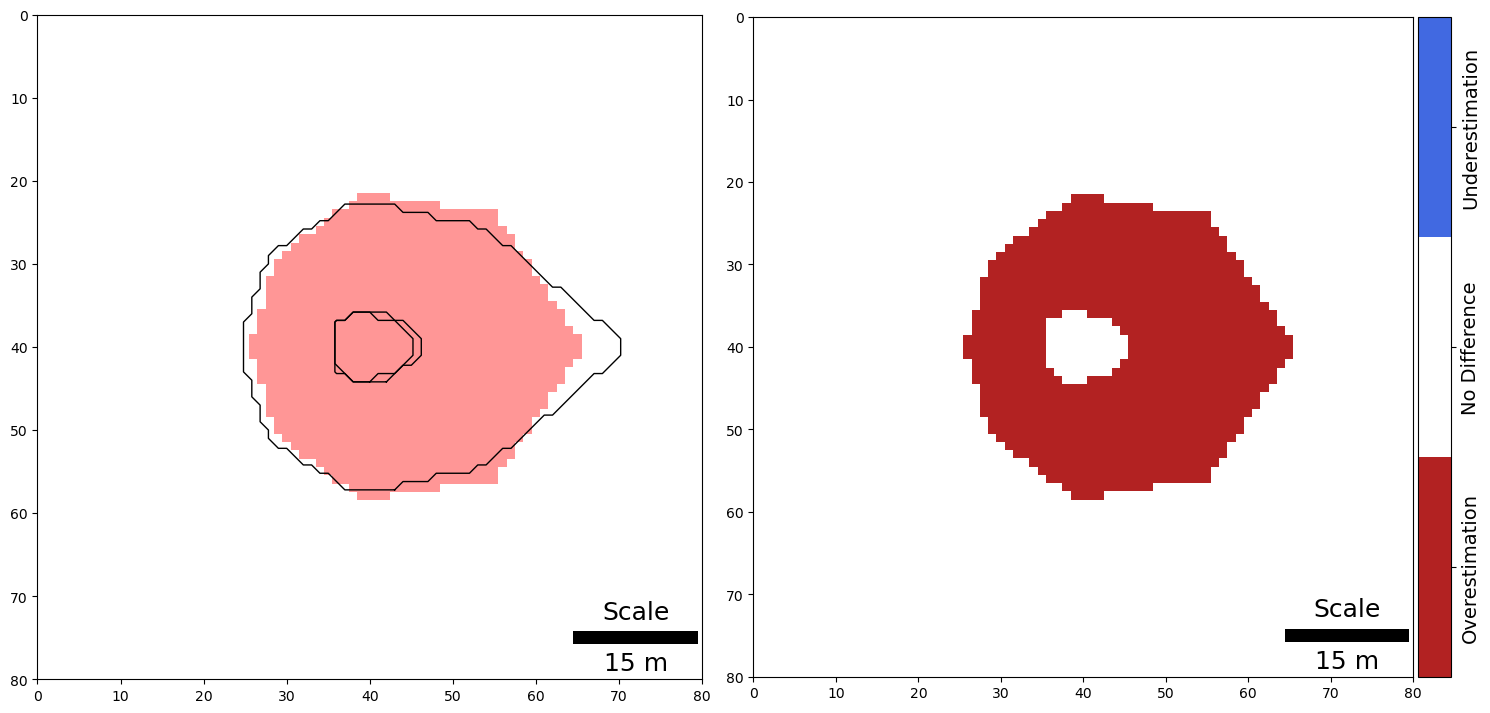

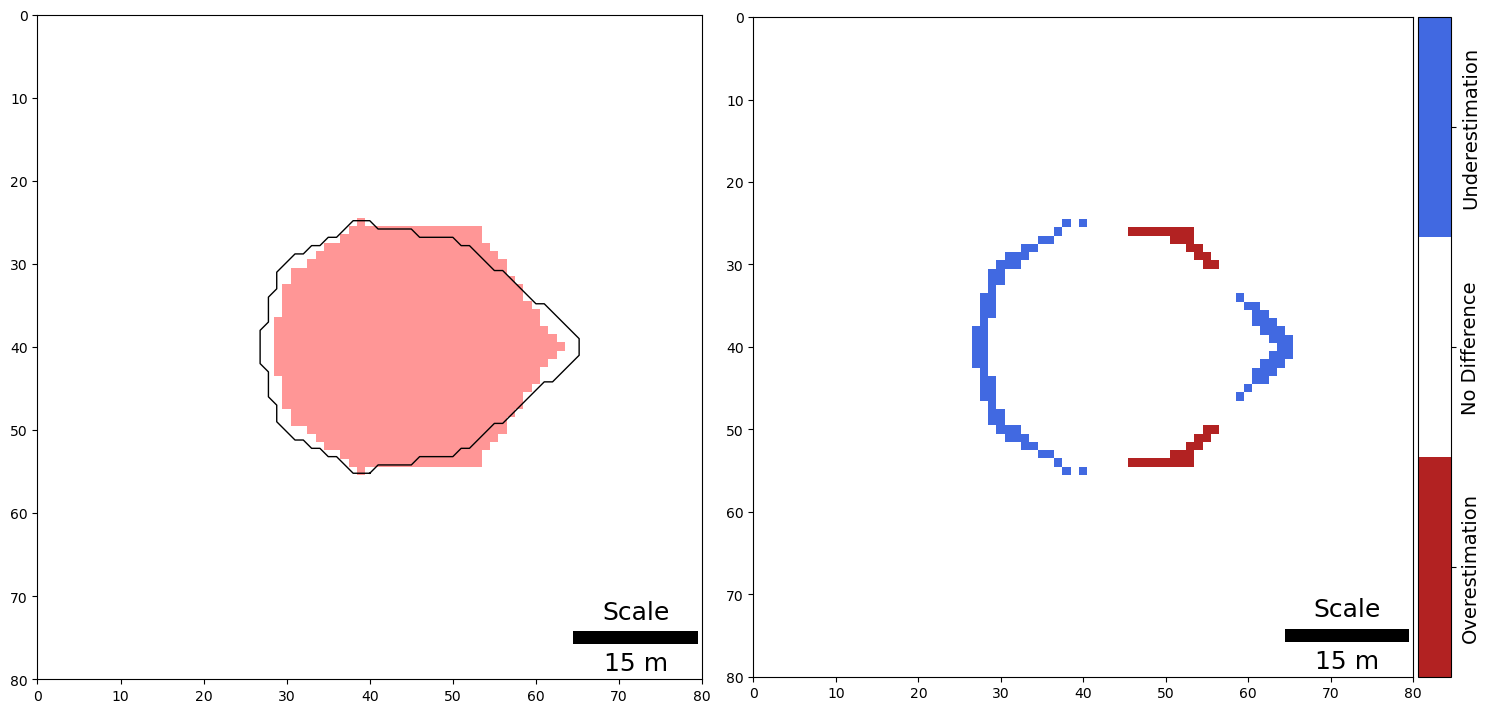

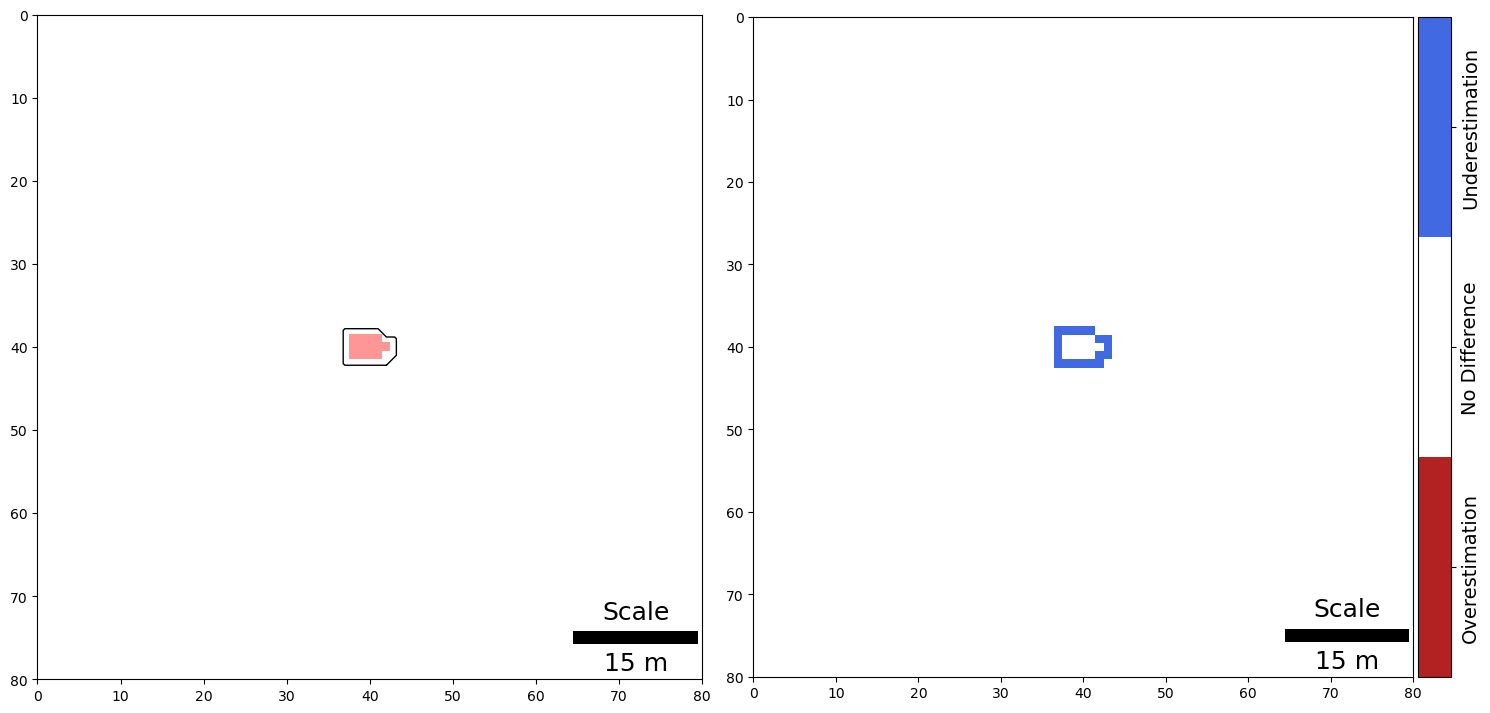

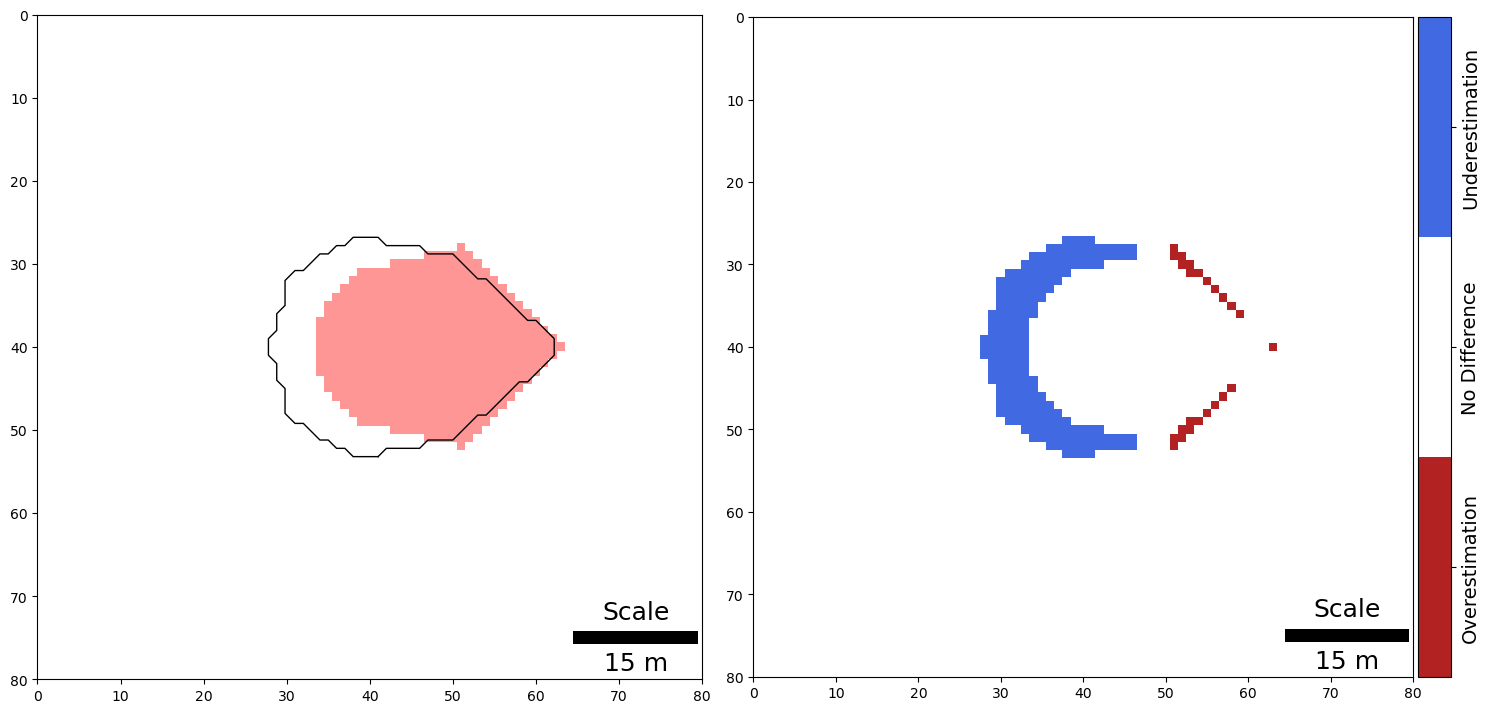

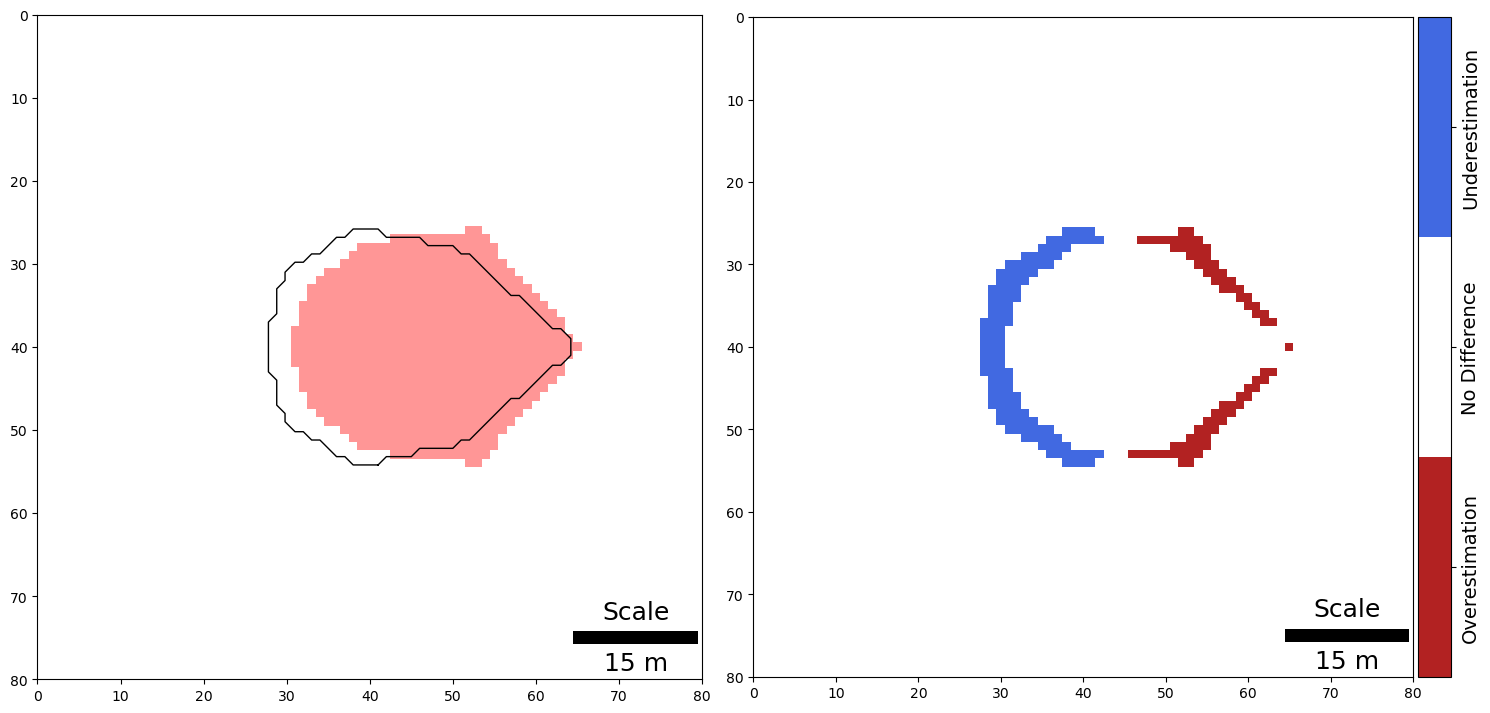

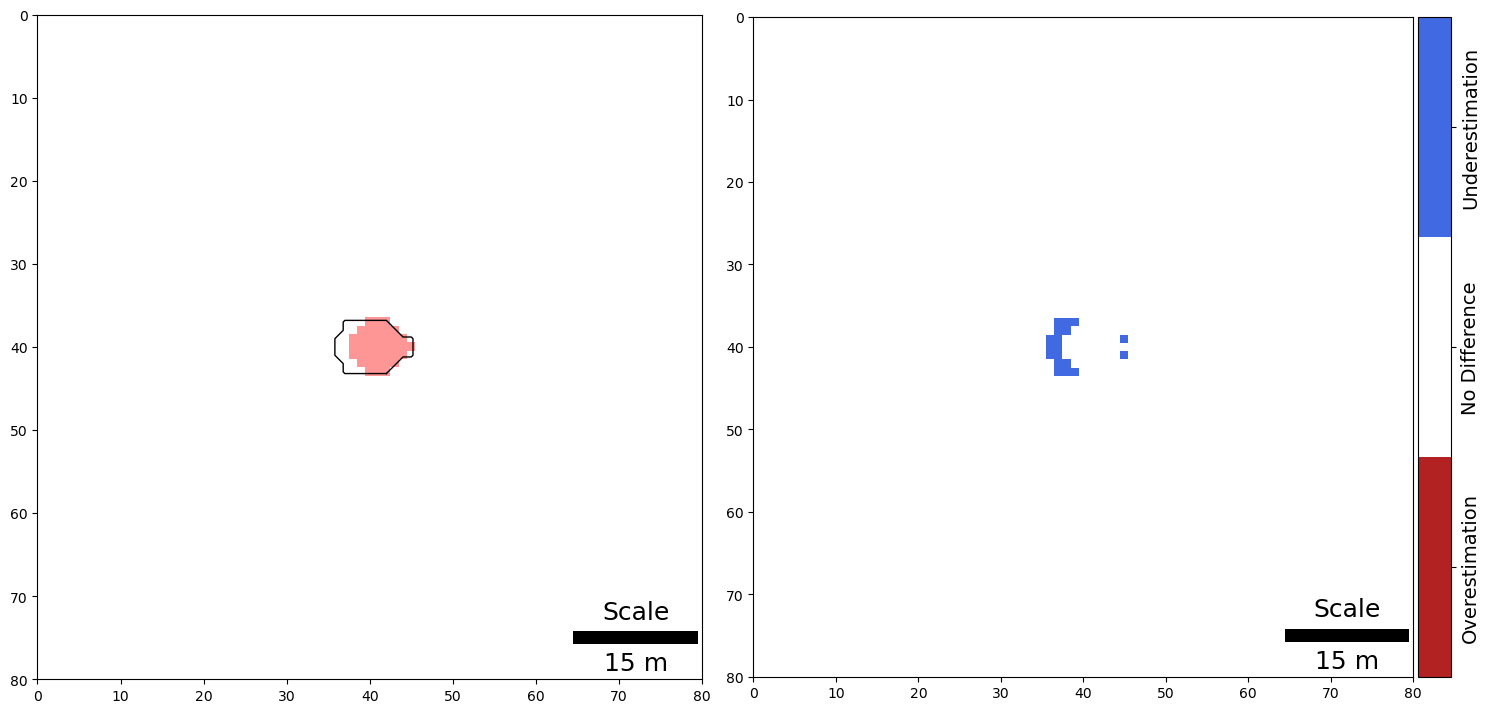

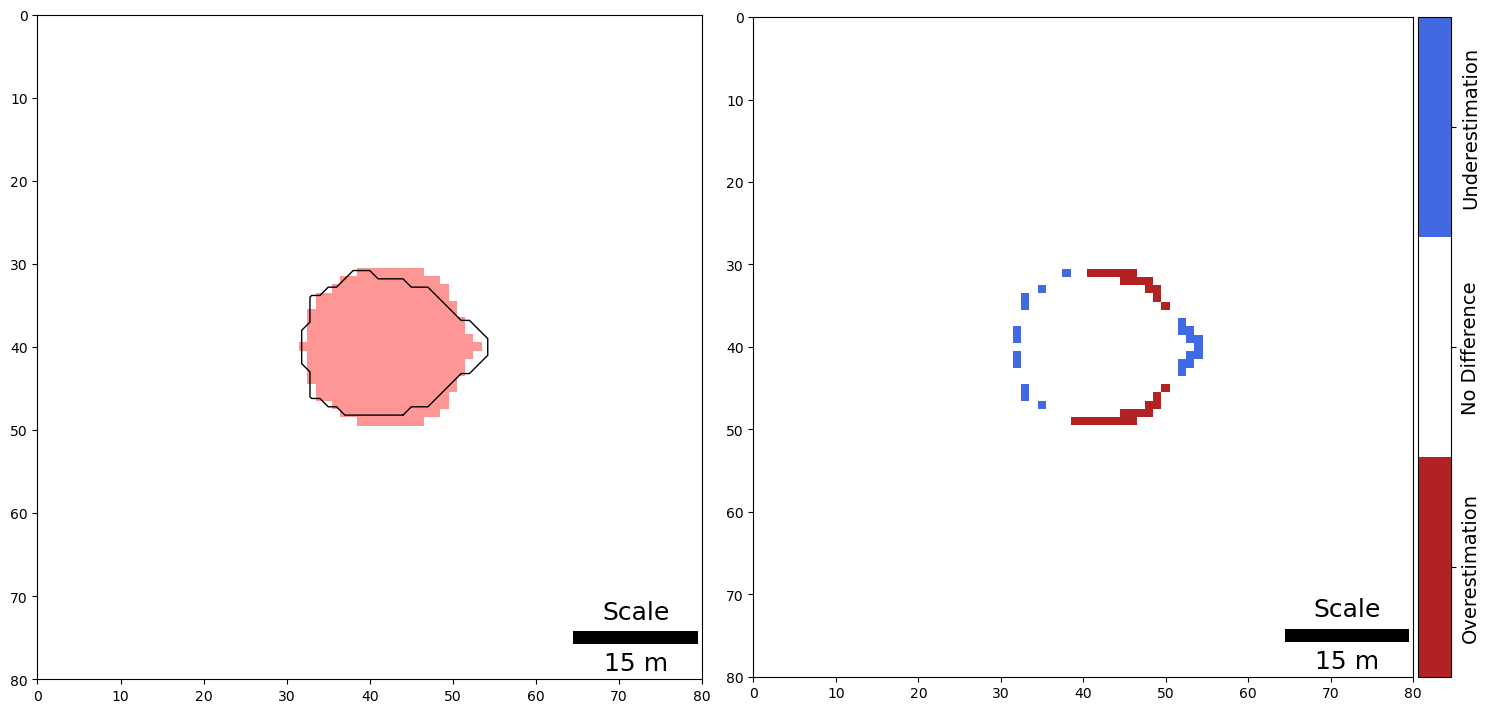

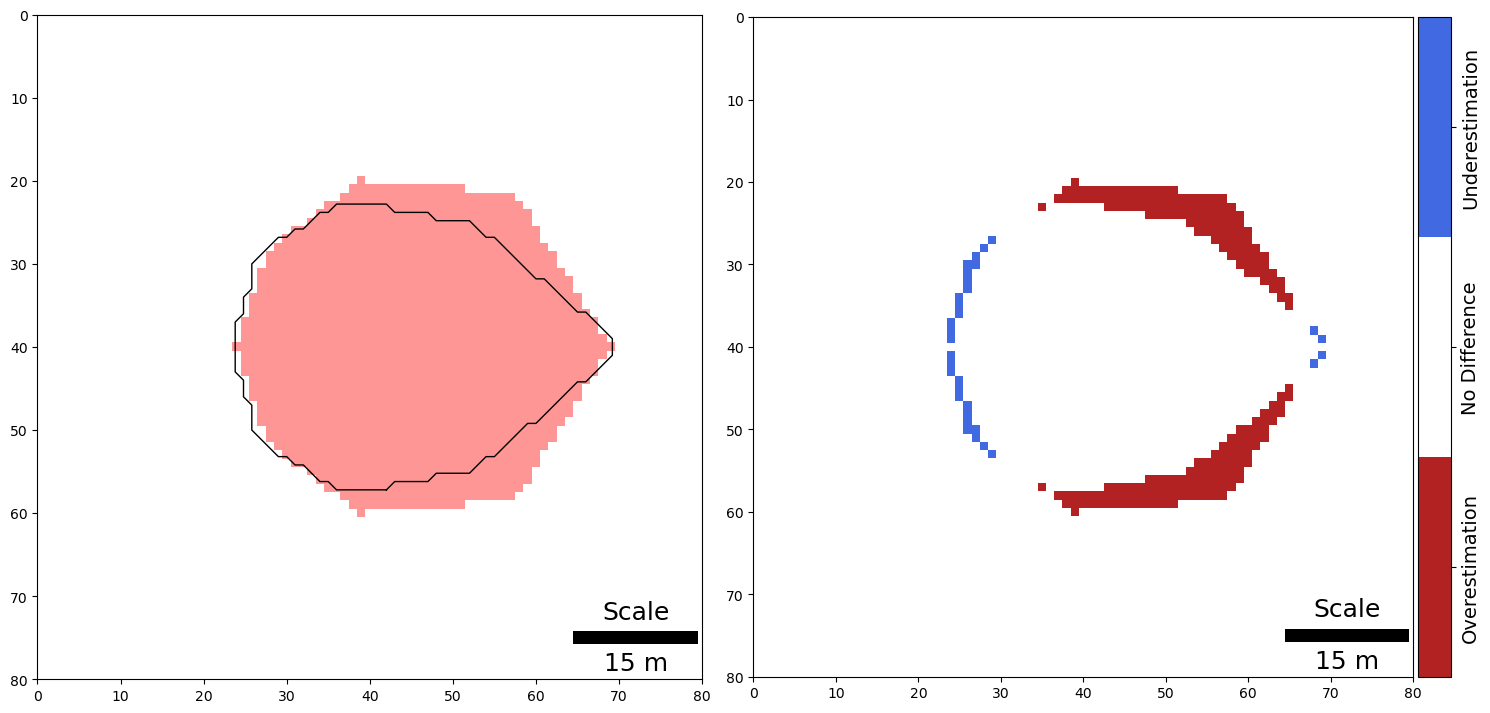

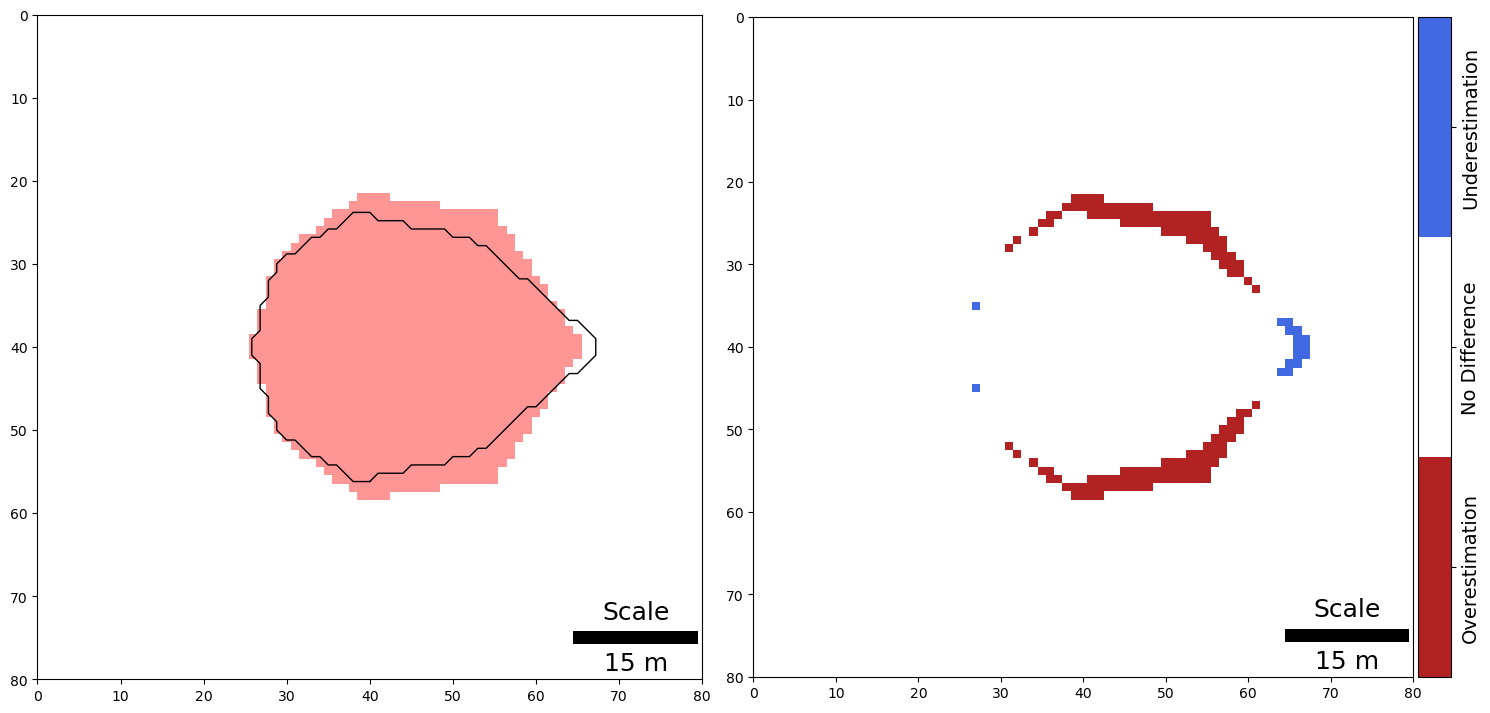

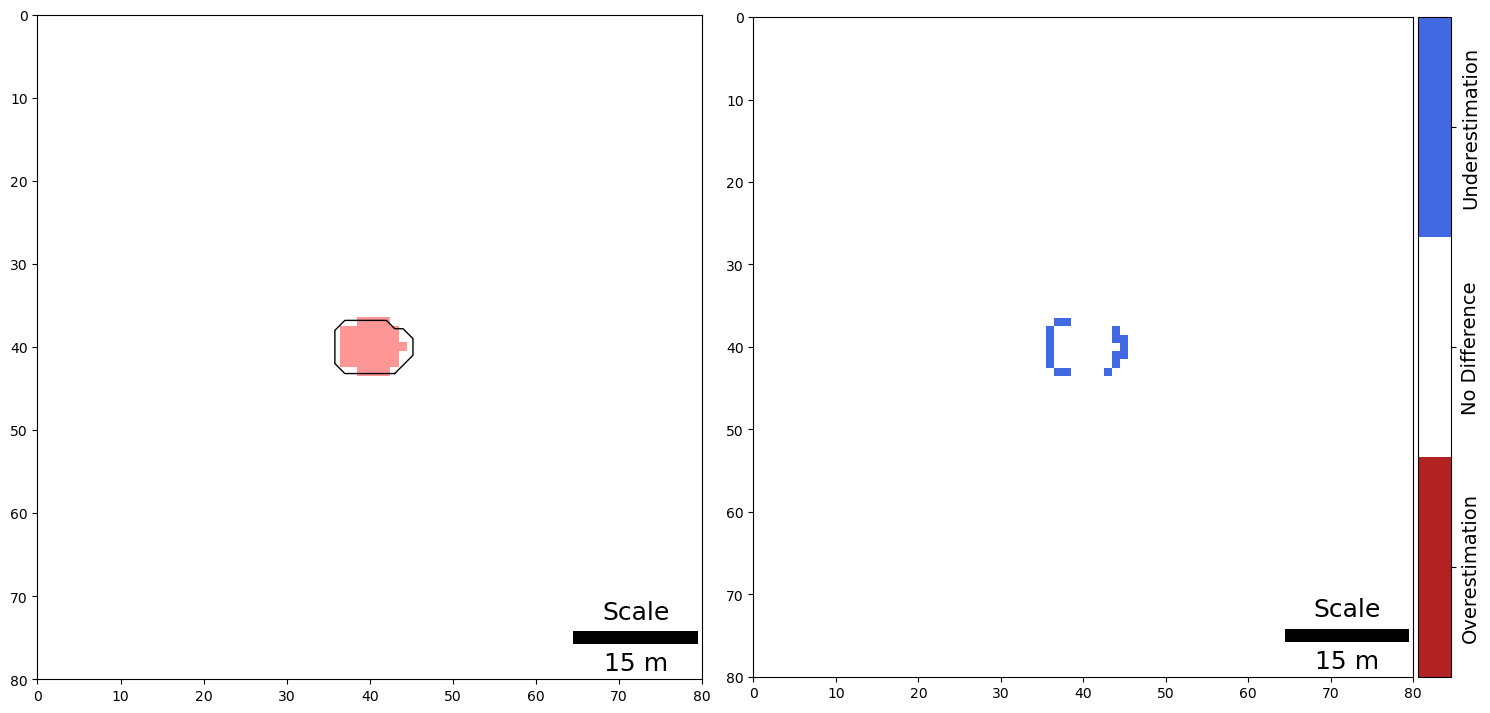

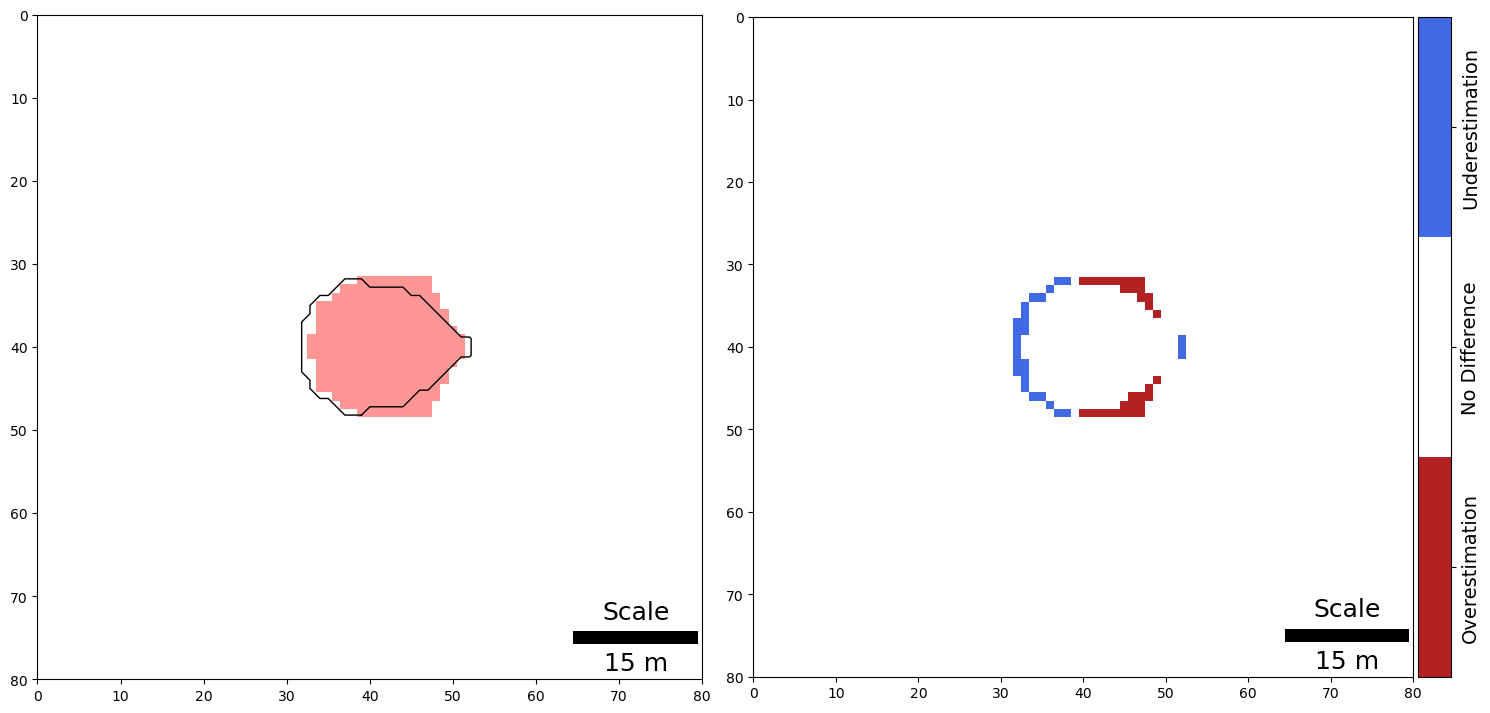

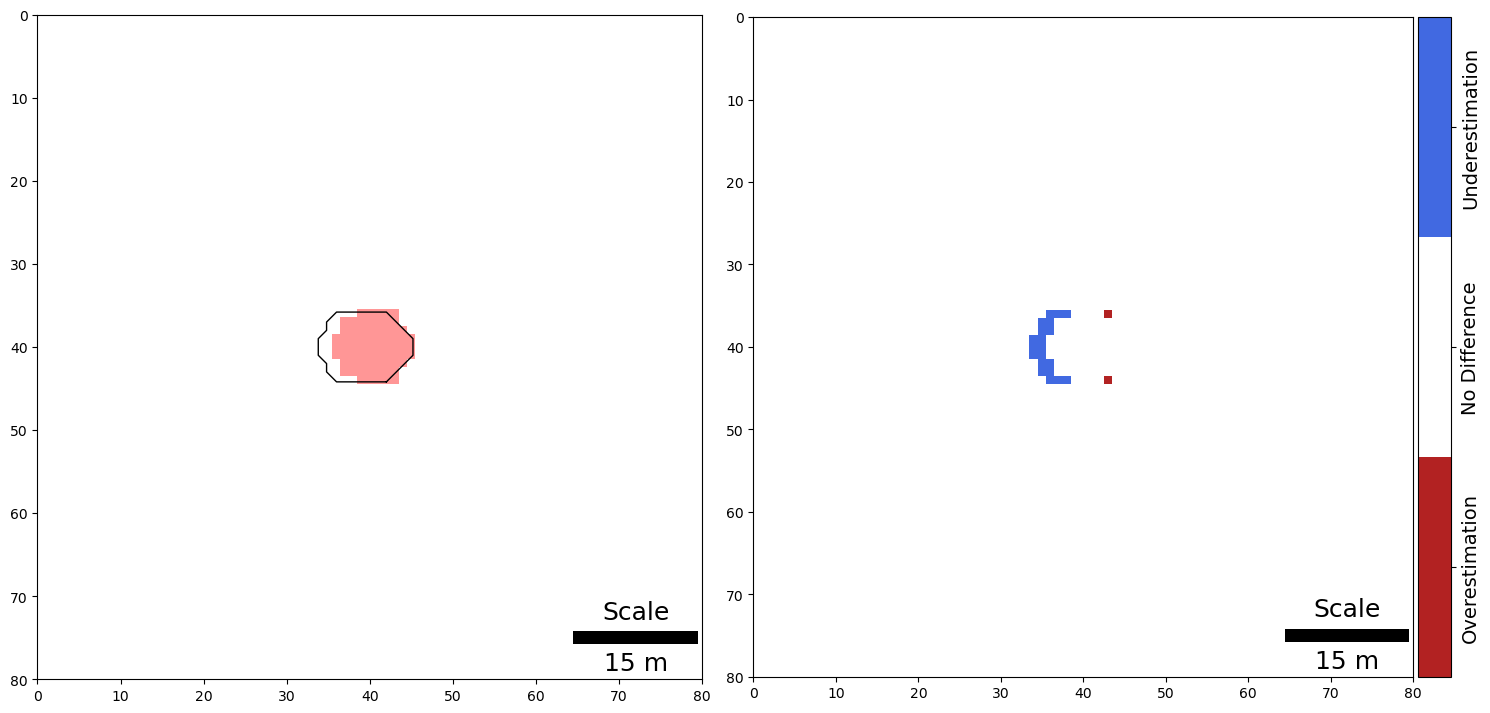

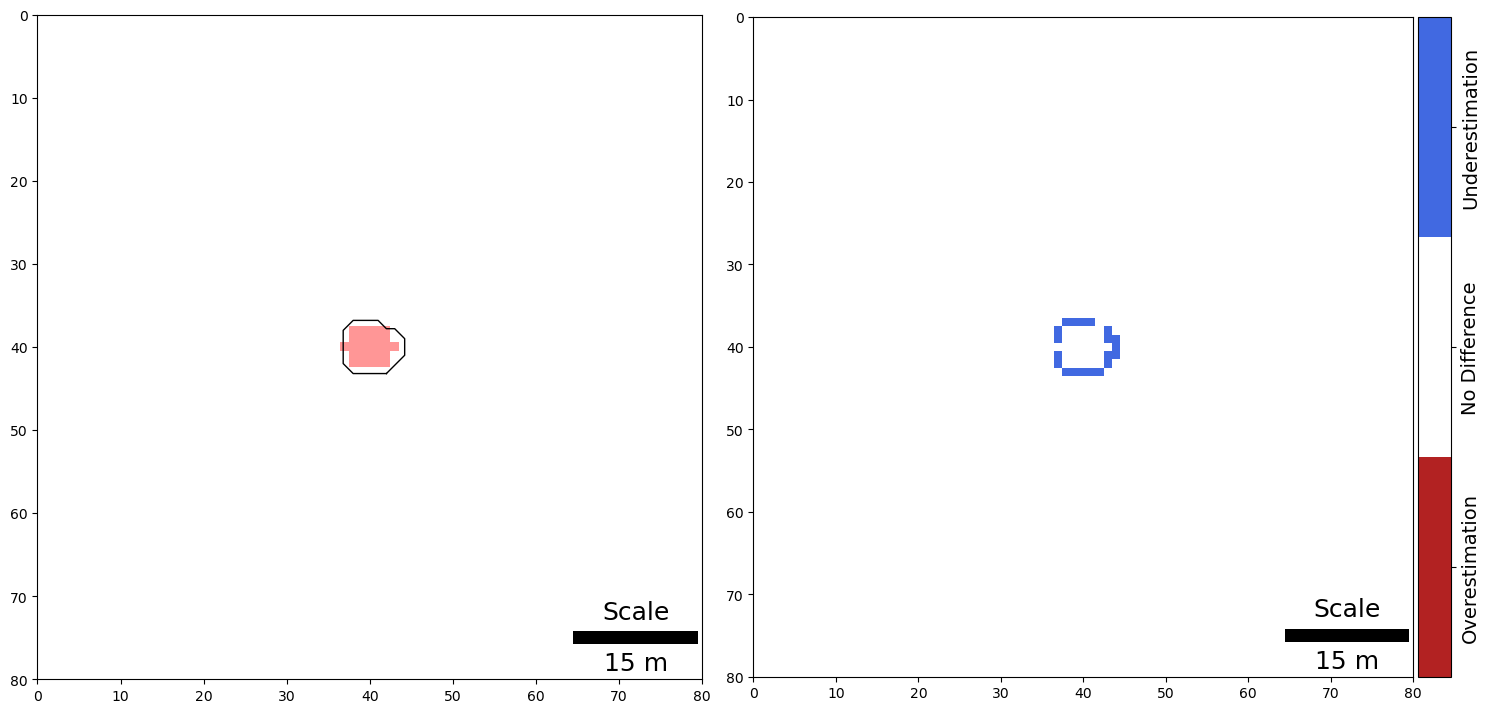

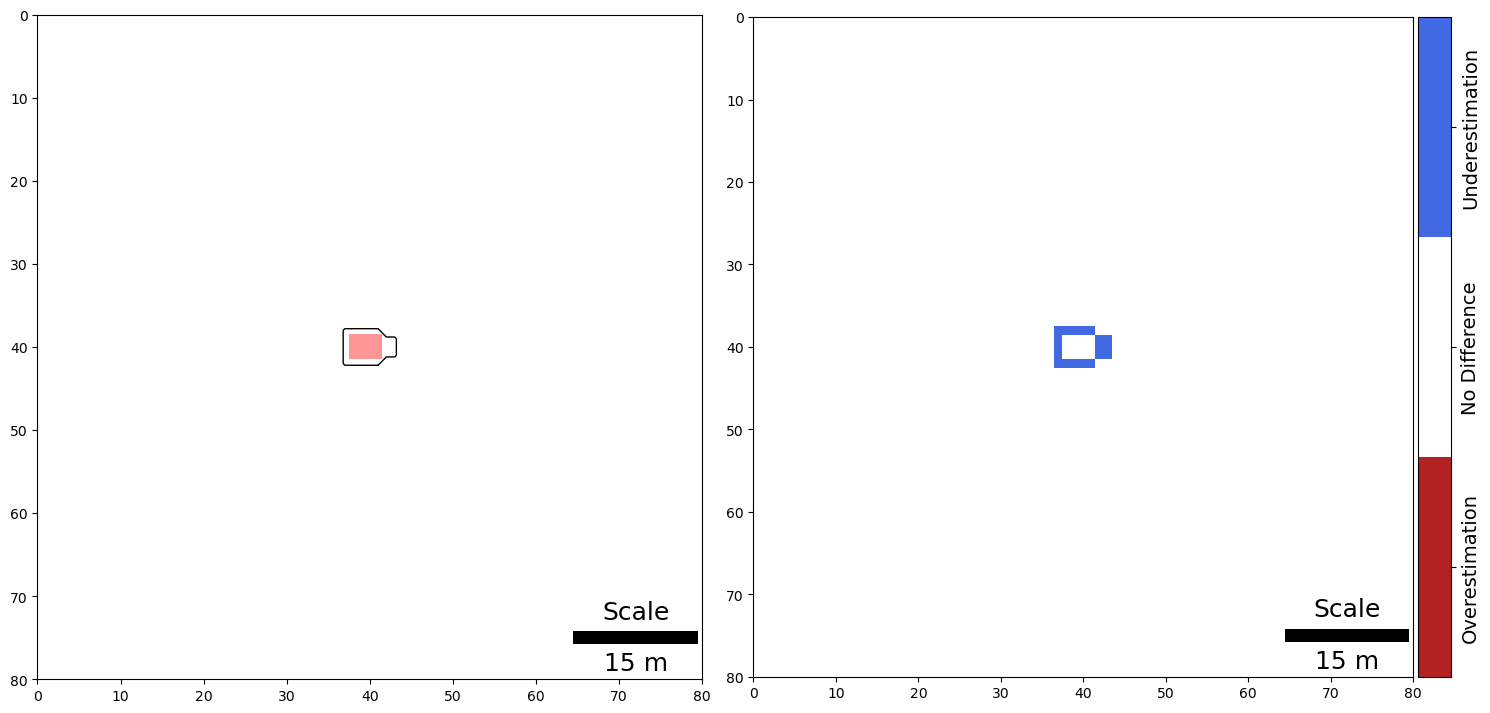

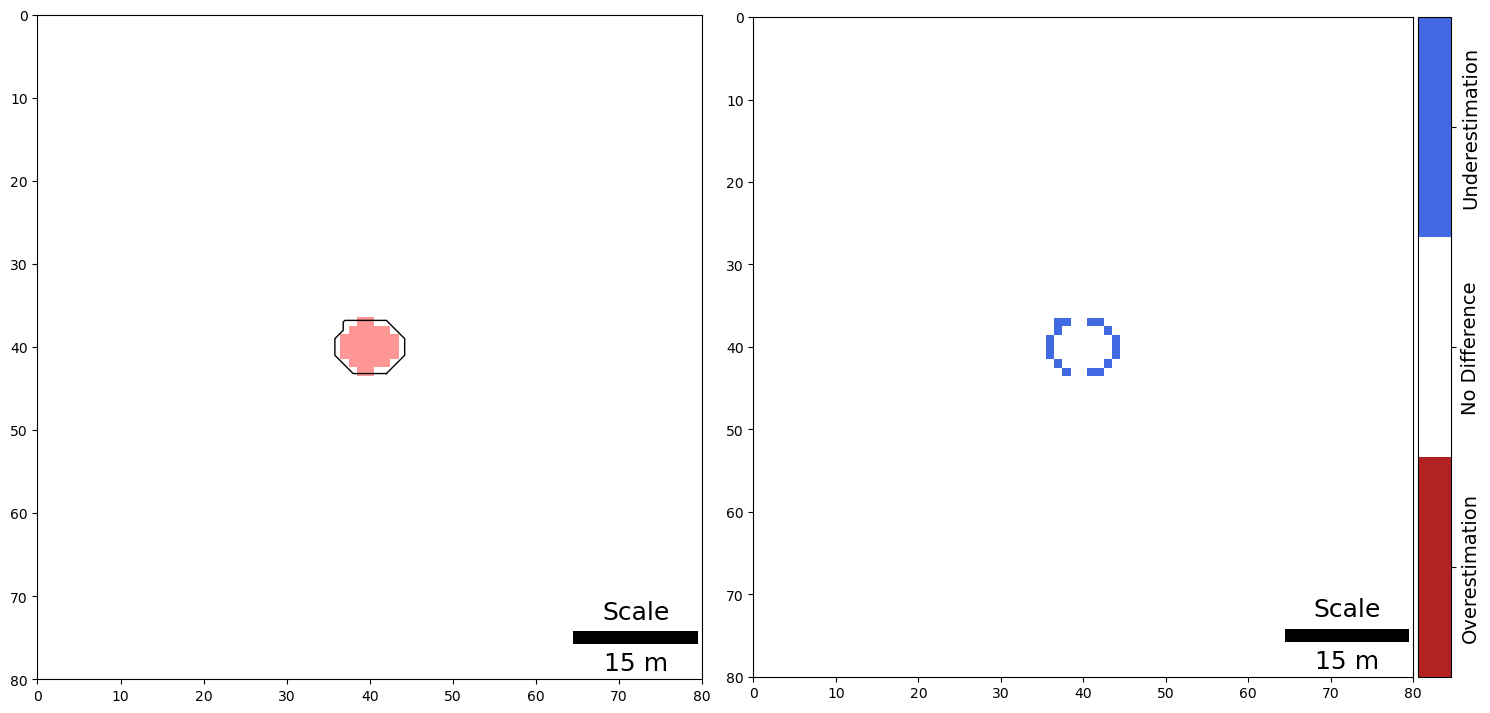

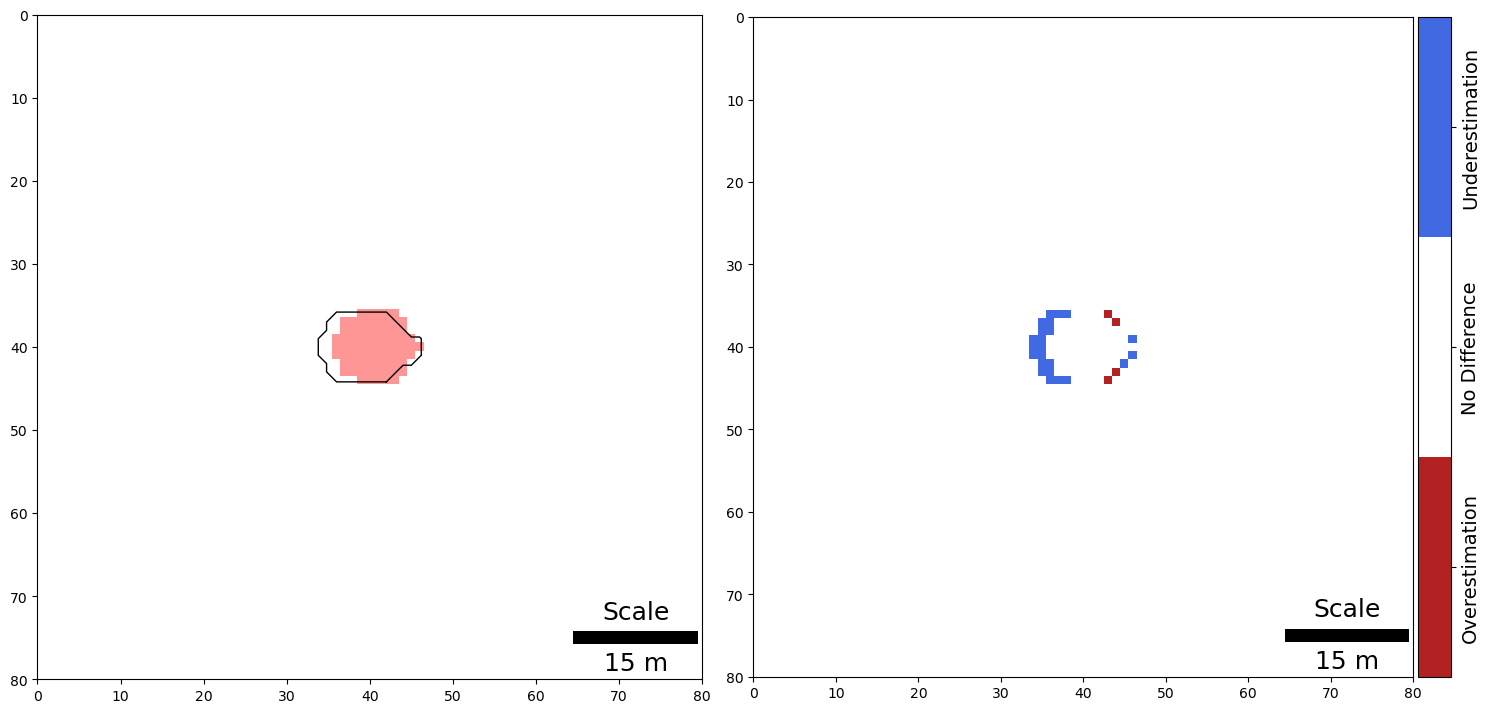

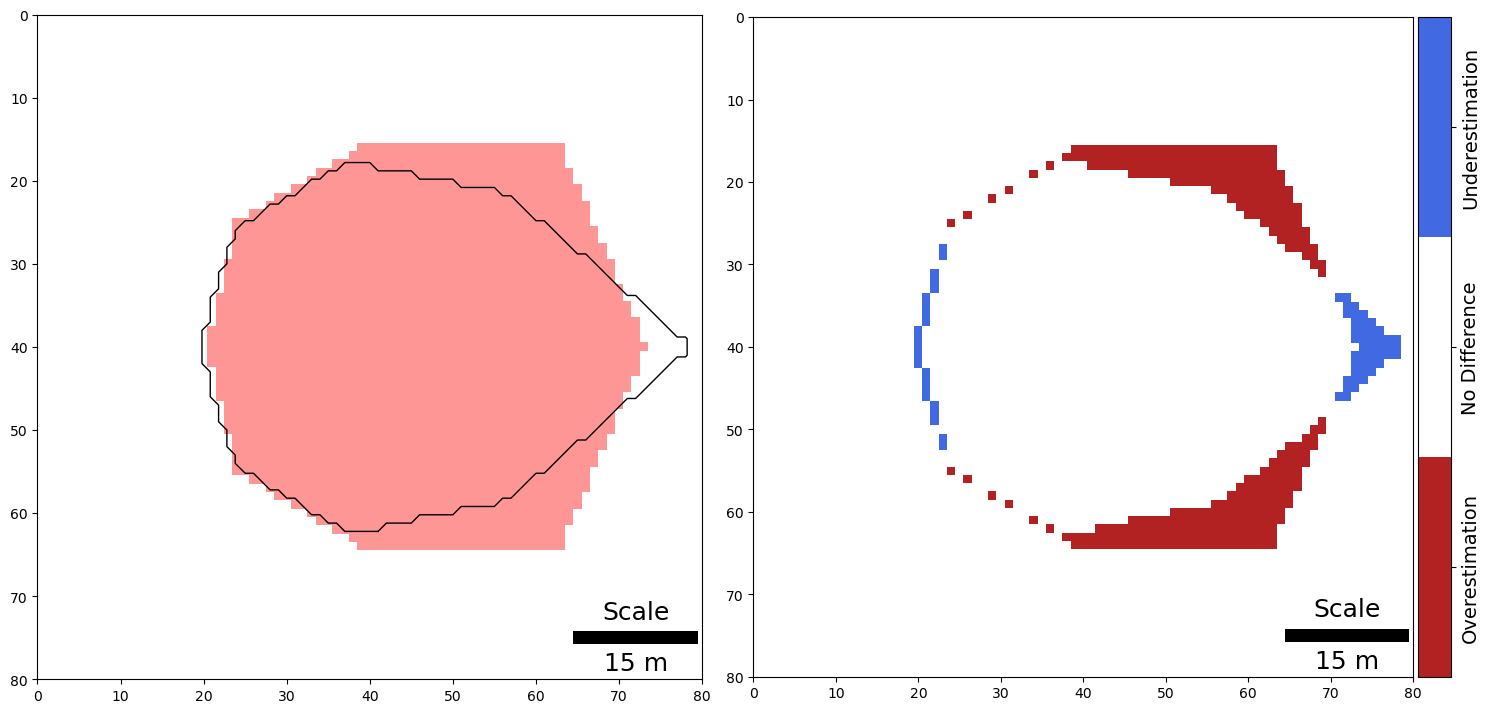

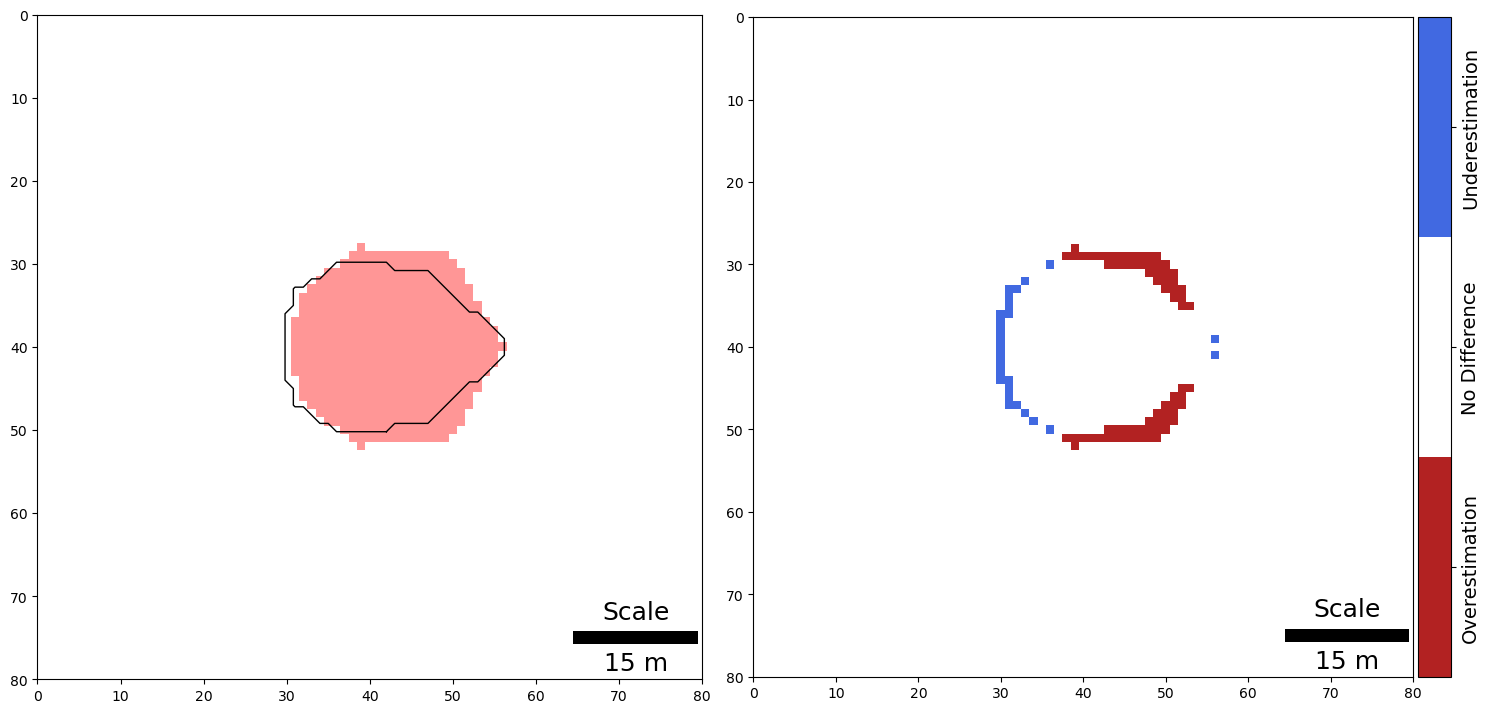

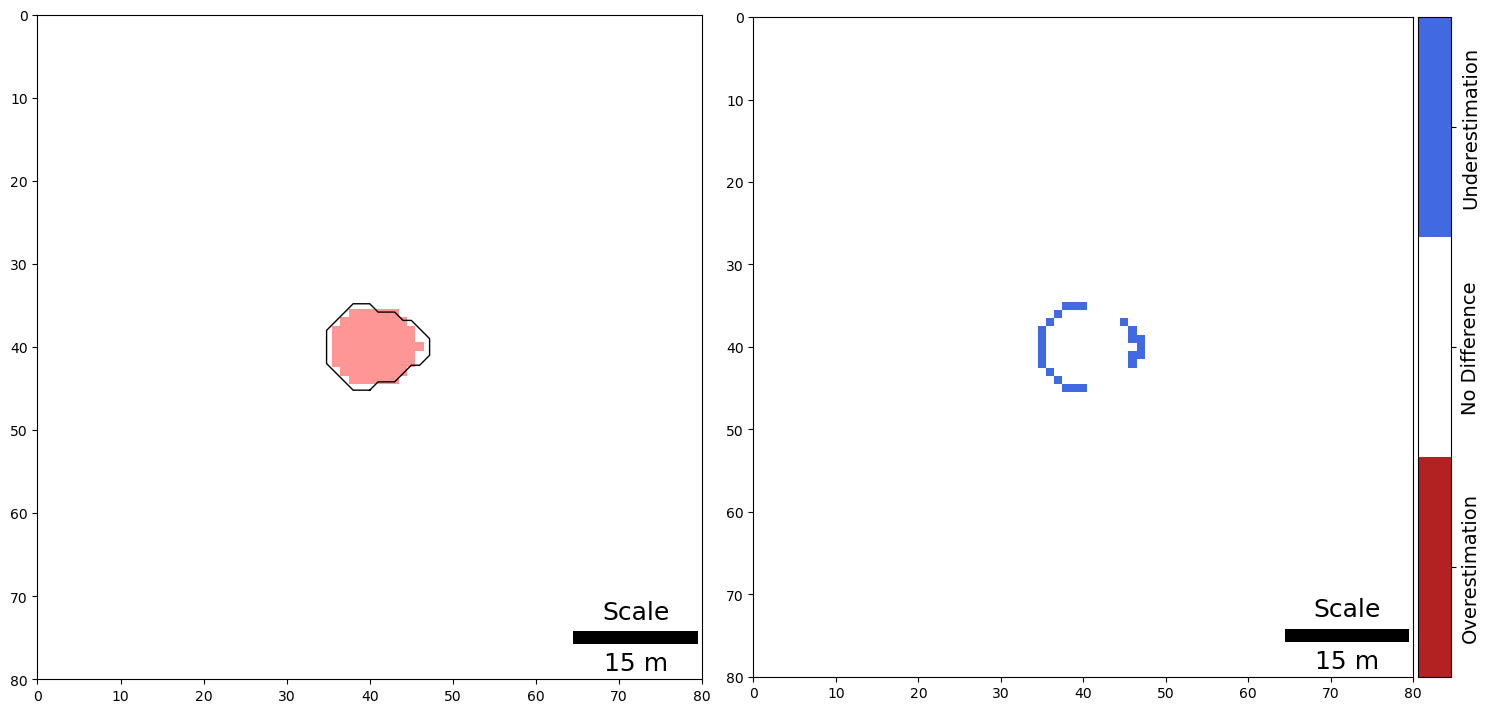

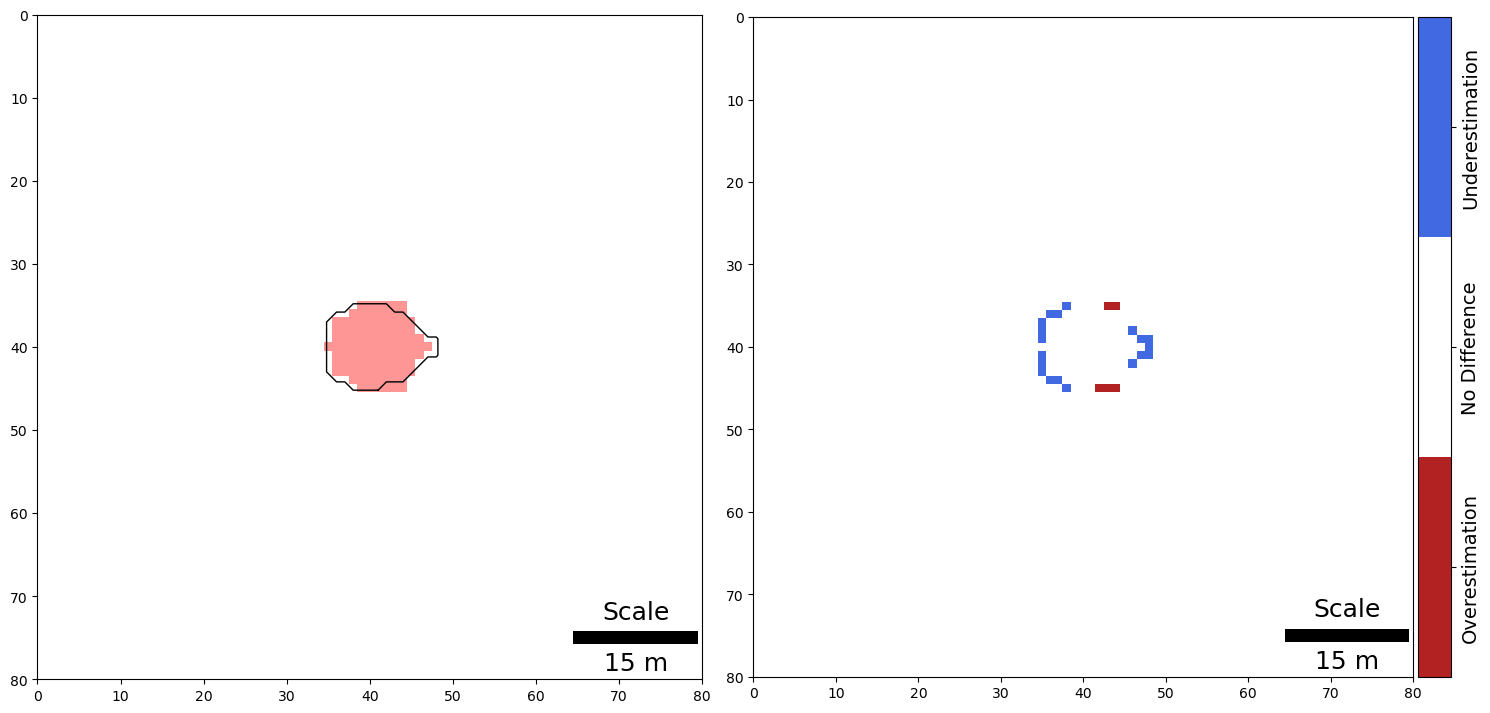

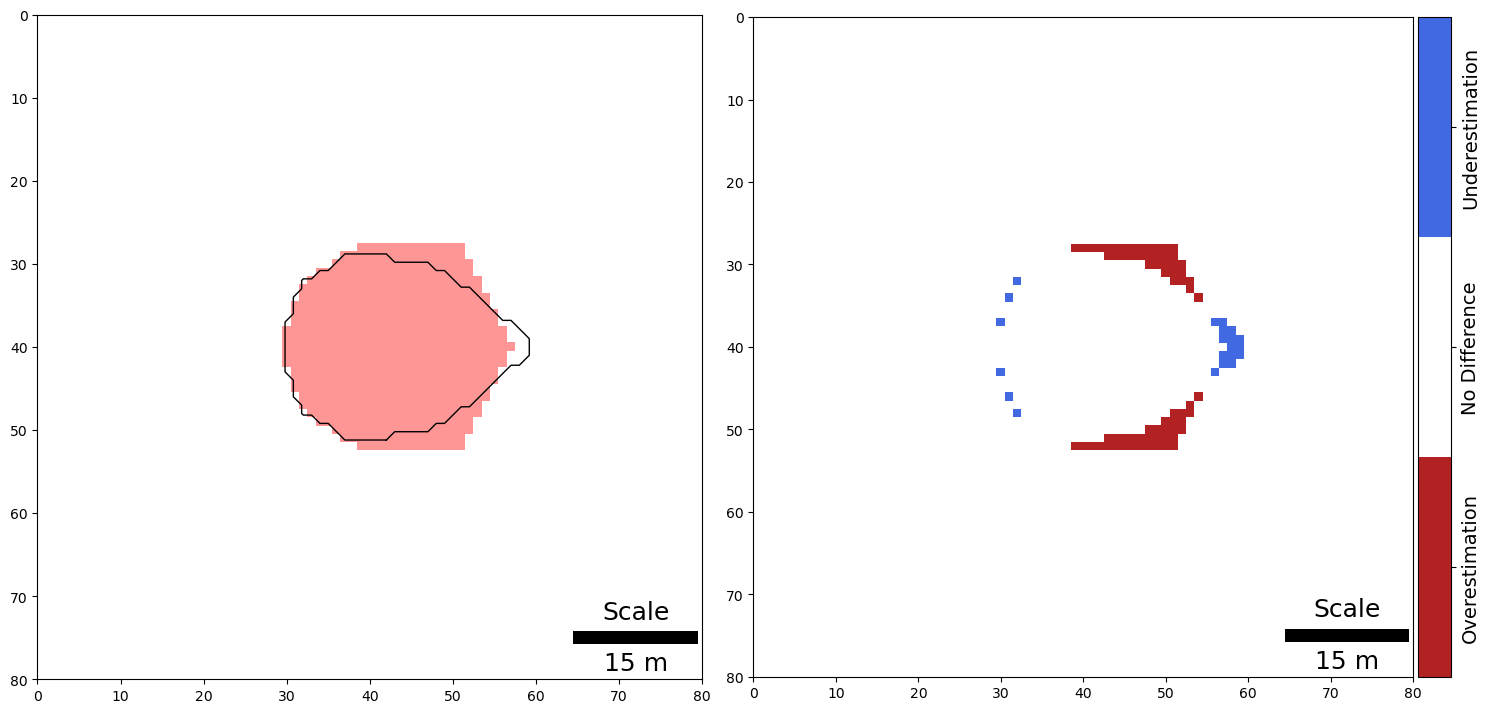

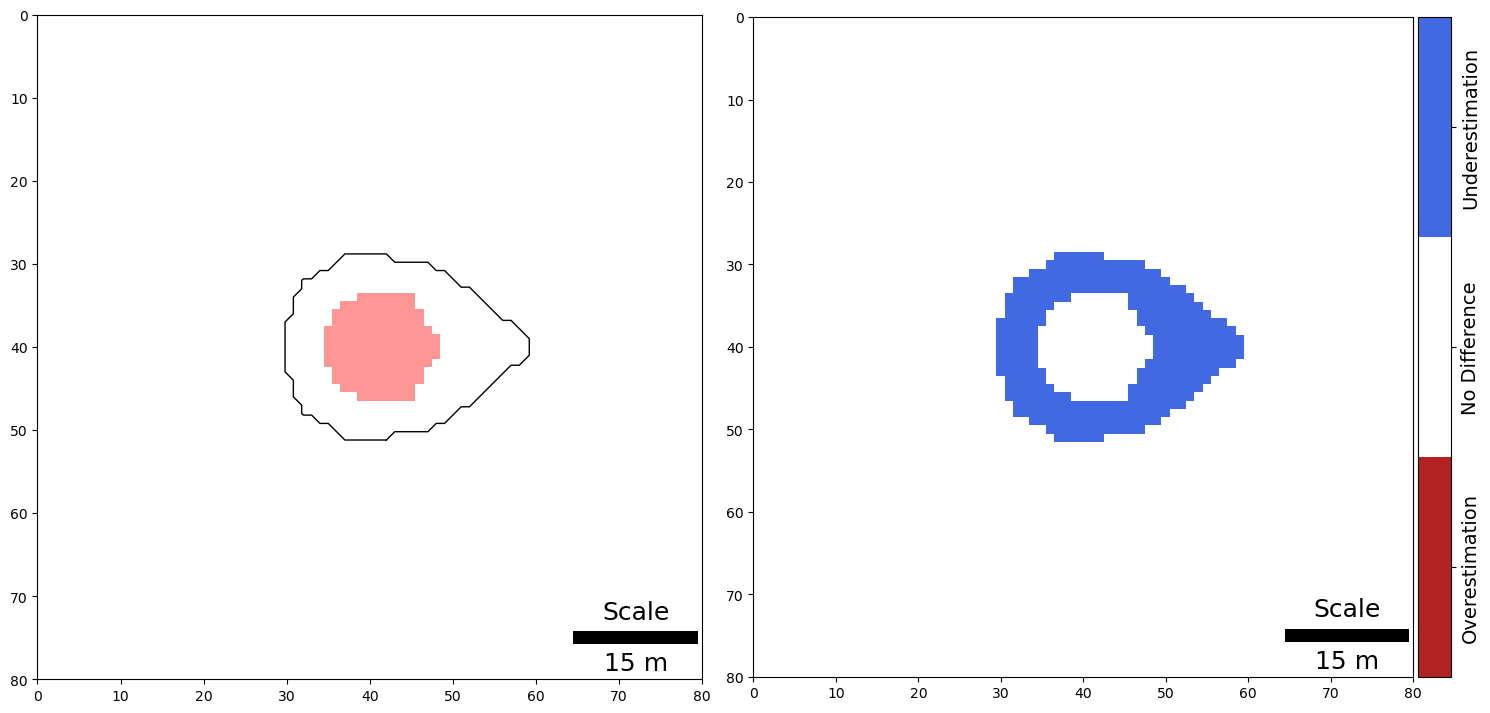

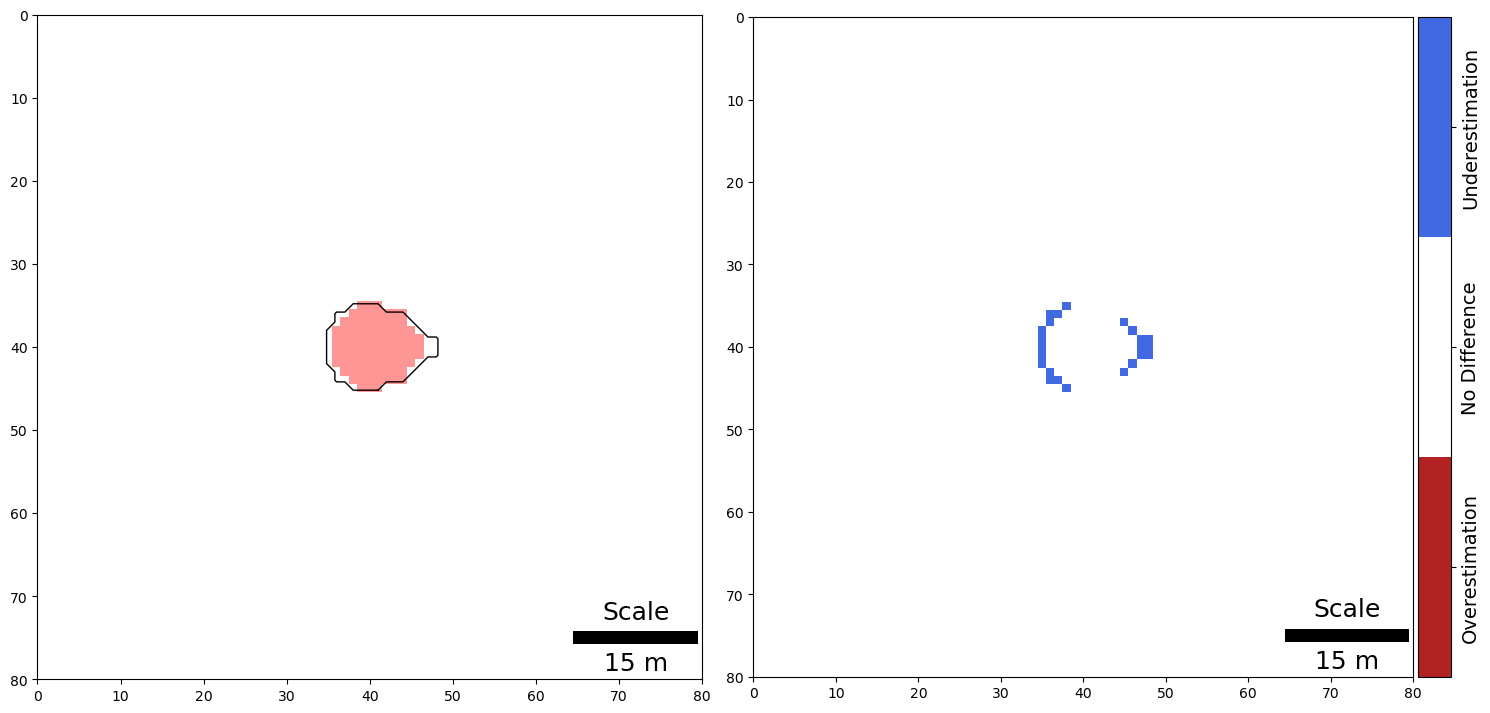

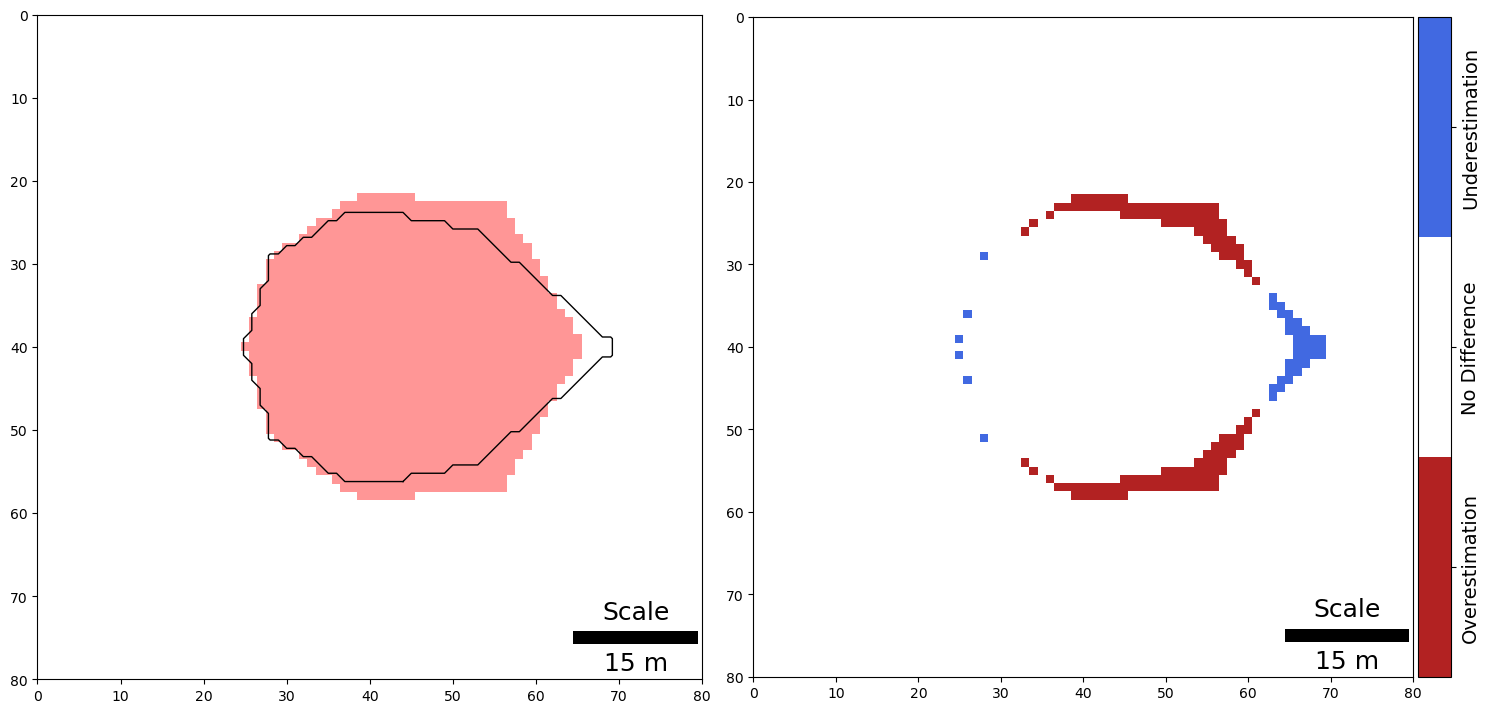

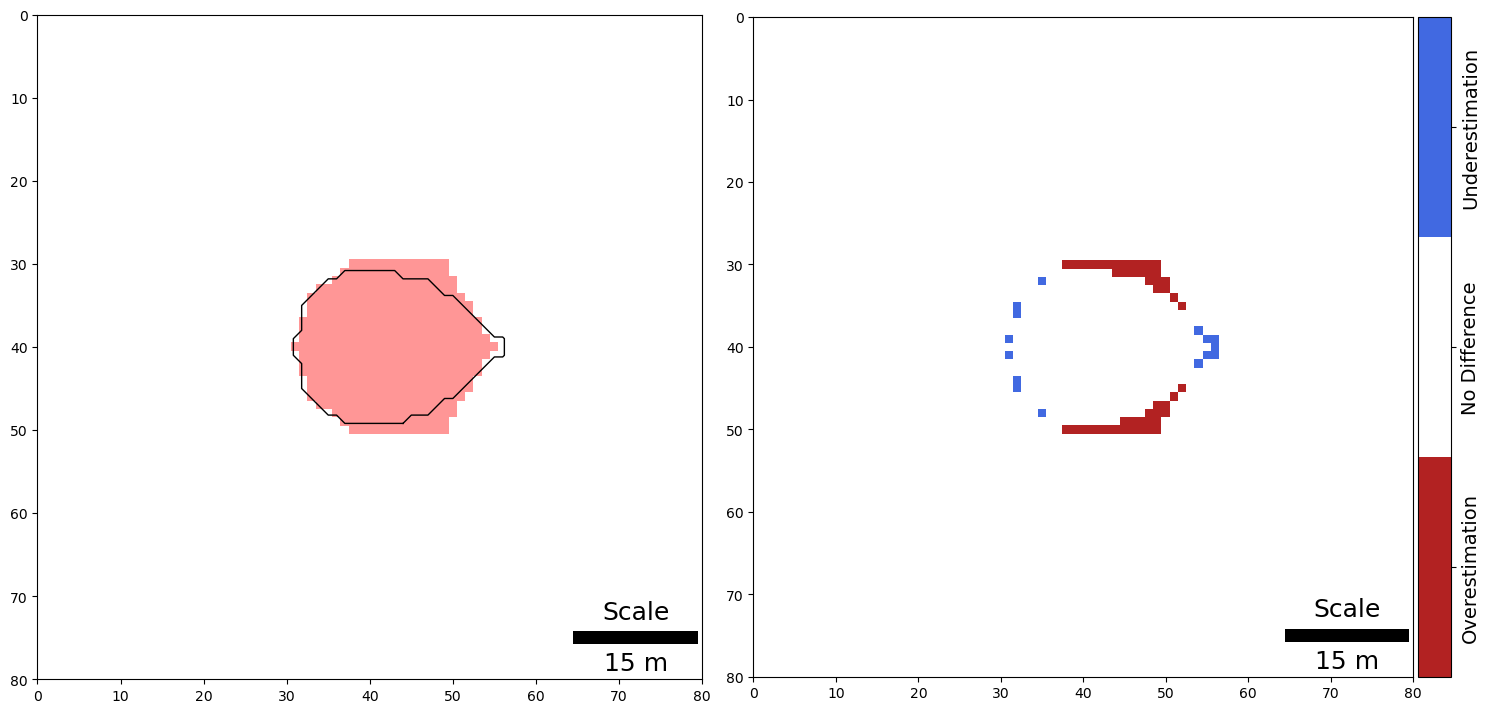

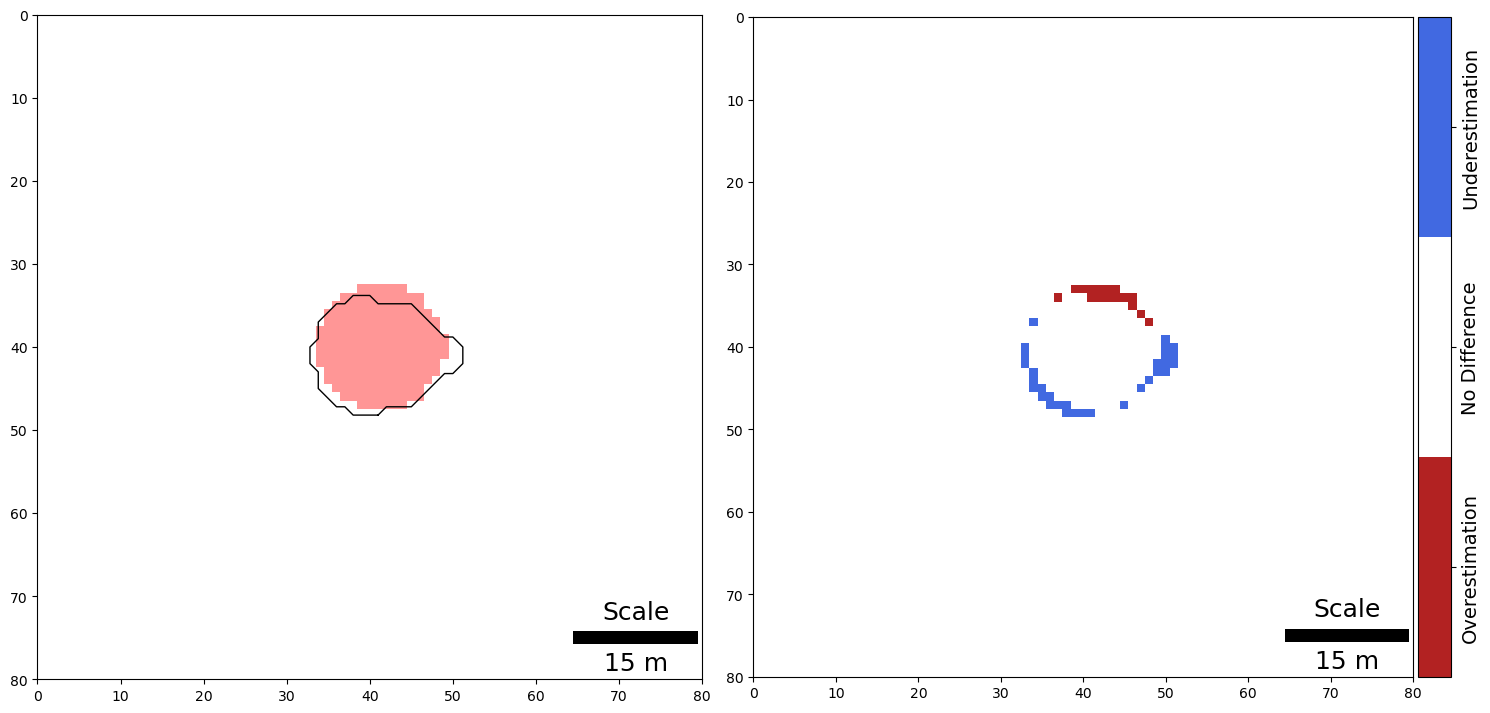

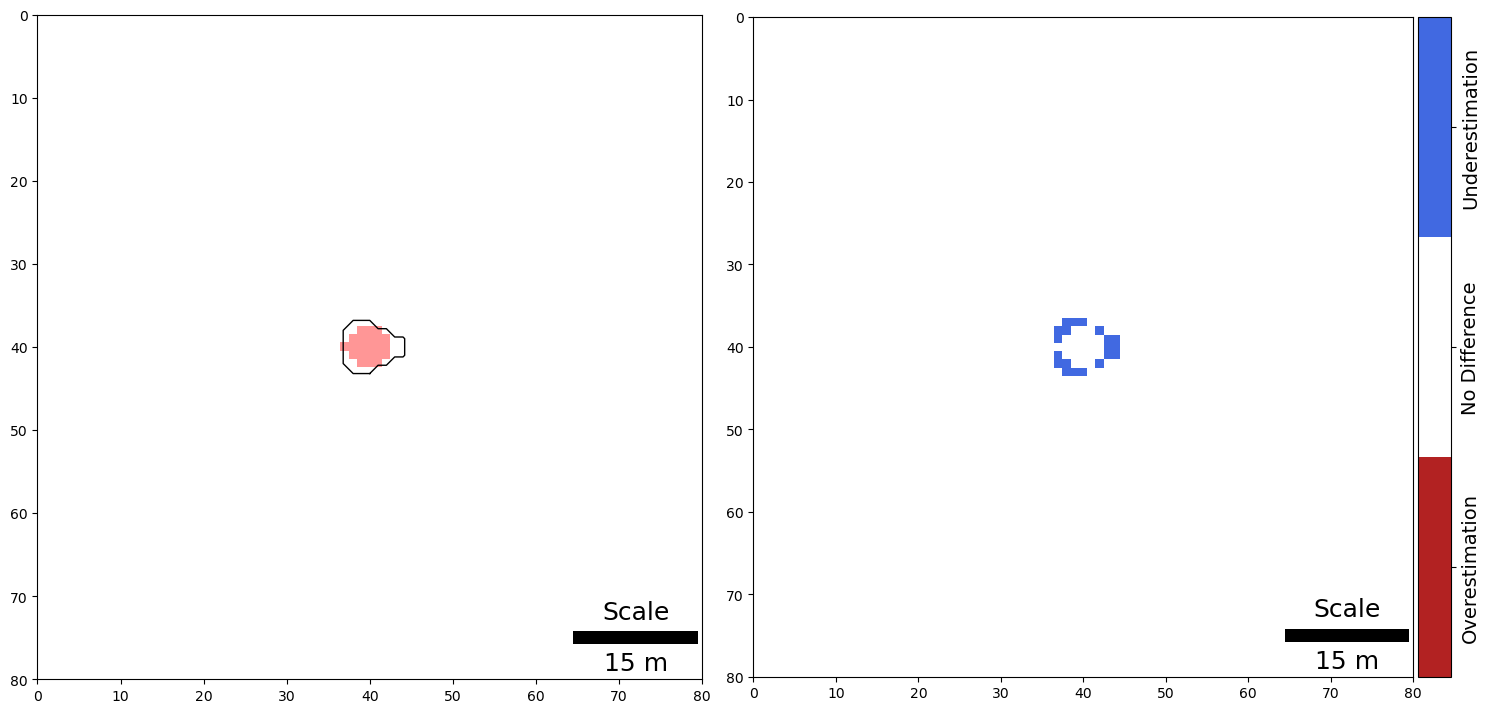

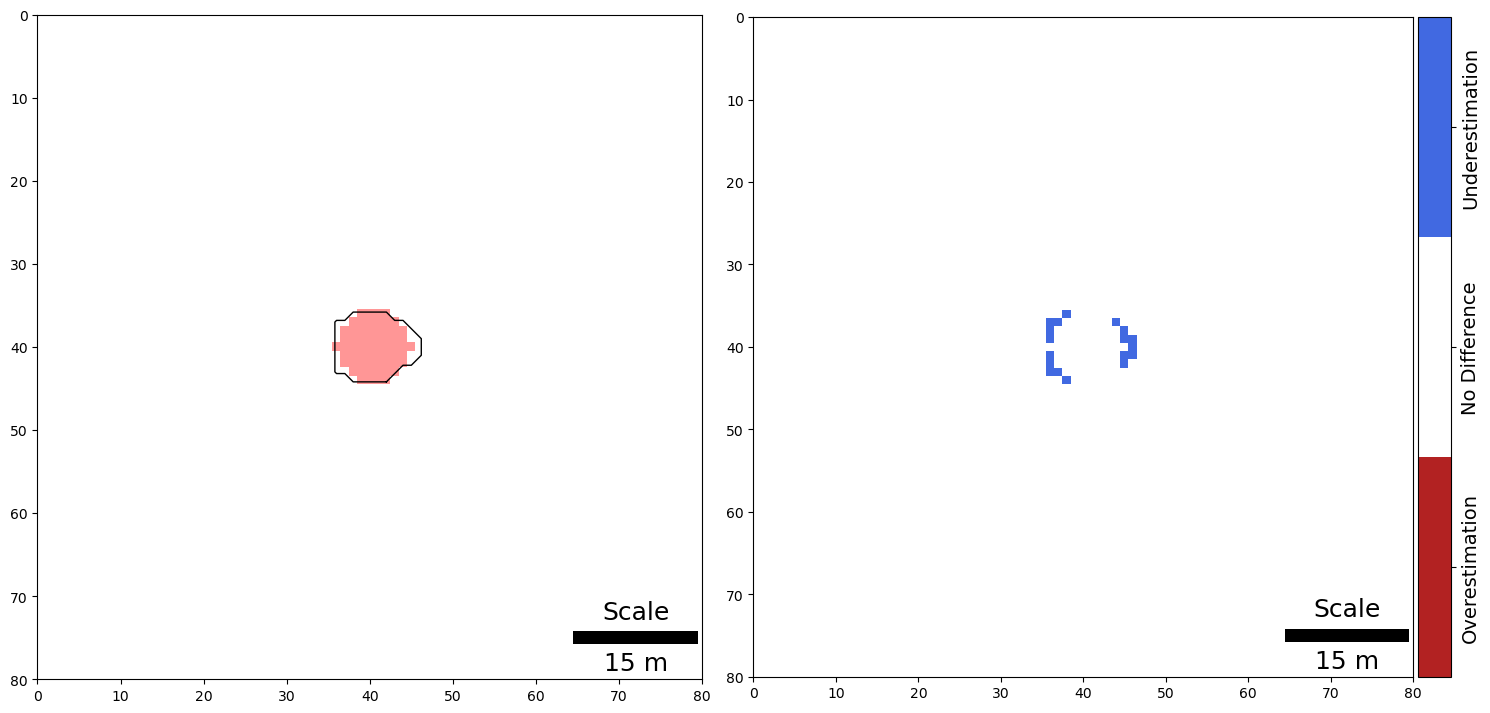

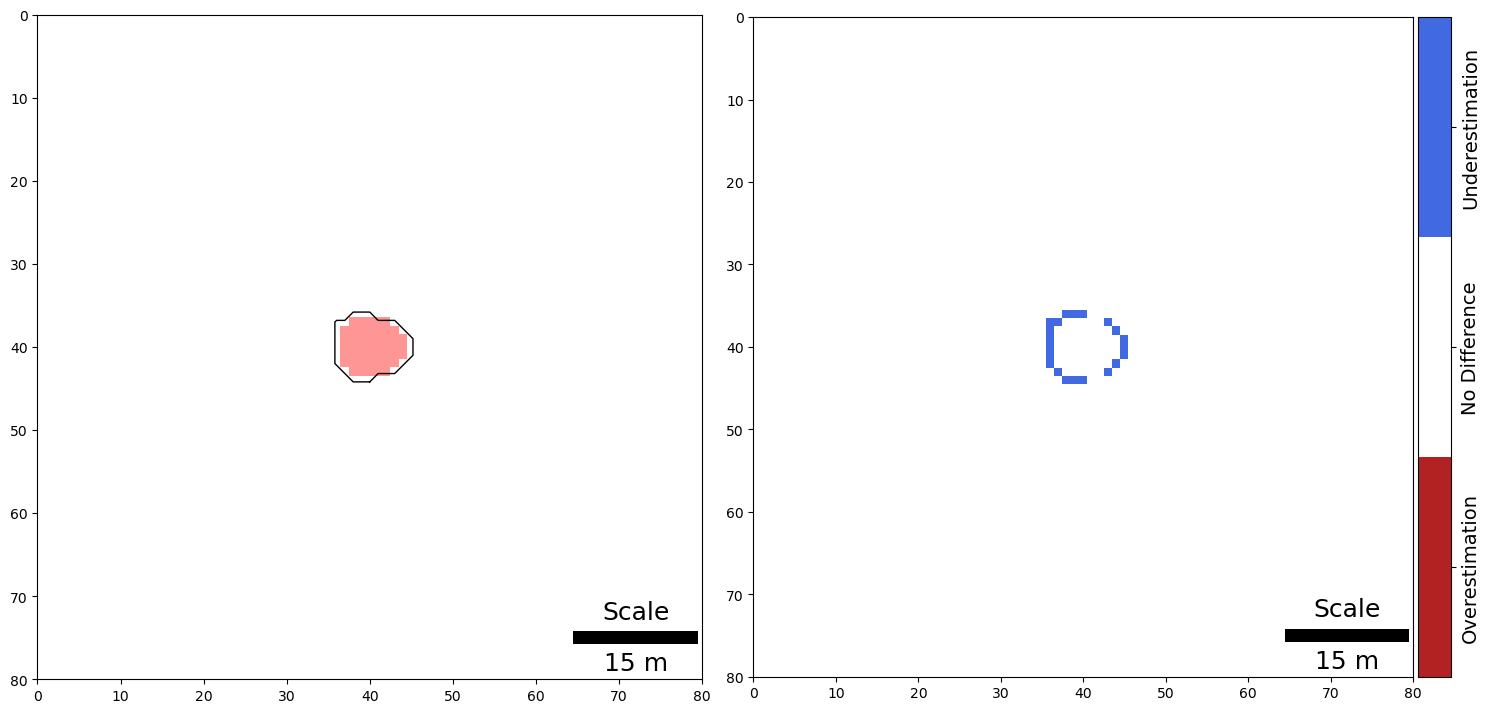

In [14]:
# Set base path
base_path = os.path.join(BASE_PATH, 'CHILE/homogeneous')

# Input parameters
fuel_types = np.arange(1, 32)

for fuel_type in fuel_types:
        
    # Input paths
    instance = 'Hom_Fuel_' + str(fuel_type)
    kitral_list = sorted(glob.glob(os.path.join(base_path, 'kitral_' + instance + "*.csv")))
    c2f_list = sorted(glob.glob(os.path.join(base_path, 'cell2fire_' + instance + ".csv")))

    # Load datasets
    cell2fire_img = load_cell2fire(c2f_list[0])
    kitral_img = load_farsite_list(kitral_list)

    # # Plot
    compare_single_grids(base_path=base_path, 
                        grid1=cell2fire_img, 
                        grid2=kitral_img, 
                        x_size=kitral_img[0].shape[0], 
                        y_size=kitral_img[0].shape[1], 
                        fuel_type=fuel_type,
                        instance=instance,
                        wind_field=False)